In [1]:
# import all necessary packages 

# to connect W&B platform
import wandb  

# to handle dataframe 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# to split dataset
from sklearn.model_selection import train_test_split

# to train model
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Main Purpose of CTR Prediction Model

The main purpose of CTR prediction is to enhance the performance of online advertising and content recommendation systems, leading to increased revenue, better user experiences, and more effective marketing strategies. Accurate CTR prediction allows organizations to optimize their digital interactions with users, resulting in tangible benefits for both businesses and consumers.

### Algorithms

Click-Through Rate (CTR) dataset includes only categorical features and a binary target indicating whether a click occurred (0 or 1), There are specific models that can work well for these kinds of datasets, such as; Logistic Regression, Field-Aware Factorization Machines, CatBoost, LightGBM, XGBoost, Deep learning models with embedding layers, etc. According to the research, the Catboost algorithm can be a more suitable algorithm than other algorithms for this purpose.


#### Catboost Algorithm
CatBoost is a supervised machine learning technique employed within the Train Using AutoML tool. It relies on decision trees for tasks involving classification and regression. The name CatBoost signifies its primary attributes: the ability to handle categorical data (represented by "Cat") and its utilization of gradient boosting (signified by "Boost"). 

Advantages;
* Handle categorical features without requiring one-hot encoding or other transformations.
* Automatically scales the gradient magnitudes of numerical features and the target variable.
* Includes built-in regularization to prevent overfitting. It includes embedded methods to avoid overfitting.
* Less preprocessing with no encoding and handling missing values. 
* Has both CPU and GPU implementations. The GPU implementation allows for much faster training and is faster than both state-of-the-art open-source implementations.

Because of the advantages above, Catboost was chosen for this study. CatBoost is a good choice, but the best model depends on your specific dataset and experiments. It's always a good idea to compare CatBoost's performance with other models like LightGBM, XGBoost, and Factorization Machines to find the optimal model for your task. 

CatBoost is based on gradient boosted decision trees. During training, a set of decision trees is built consecutively. Each successive tree is built with reduced loss compared to the previous trees. https://catboost.ai/en/docs/concepts/algorithm-main-stages

DON'T FORGET⚠ Cross-validation is an important technic to find best performed model, especially if you have a restricted number of data and need a more generalized model. CV will help you identify the most suitable model for your CTR prediction. In this notebook, CV is not applied, but the Catboost library also includes cv methods. (*from catboost import cv*)


Please check the Catboost paper: https://arxiv.org/pdf/1810.11363.pdf

Please check the documentation of Catboost: https://catboost.ai/en/docs/

In [2]:
# connect wandb with your key

# wandb.login(api_key="YOUR_API_KEY")

# wandb login e7af045db59ef2d253743f547f333040a785e5ce
# OR
# wandb.login(api_key="e7af045db59ef2d253743f547f333040a785e5ce")

### Preprocessing

For the Catboost algorithm no need to apply encoding techniques such as one-hot encoding, label encoding, or target encoding (encoding categorical variables for regression problems) as a preprocess. It is handled by the algorithm implicitly. 

But to prepare the dataset for the model training; 
* Datatypes of the loaded dataset will be indicated again,
* The features "id" and "hour" will be removed, because hour and day info are already extracted from the hour column,
* Target column "click" is removed from the feature dataset and X and y datasets are created,
* Train, validation, and test sets are prepared according to percentages; 80%, 10%, 10%.

#### Important Features Selection
You can remove uninformative or redundant categorical features by domain knowledge, and correlation techniques before training. But if you couldn't detect correlated columns in the dataset explicitly, don't worry, Catboost offers regularization parameters (L1, L2) that can help reduce the impact of less important features during training.

In [3]:
# give datatypes

dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(str),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str),
    'hour_of_day': np.dtype(str),
    'day_of_week': np.dtype(str),
      }

In [4]:
# load dataset

df = pd.read_csv('/Users/fatmaoztel/Desktop/avazu-ctr-prediction/adjusted_dataset.csv',dtype=dtype,)

In [5]:
# check non-null columns and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  uint64
 1   click             10000 non-null  int64 
 2   hour              10000 non-null  object
 3   C1                10000 non-null  object
 4   banner_pos        10000 non-null  object
 5   site_id           10000 non-null  object
 6   site_domain       10000 non-null  object
 7   site_category     10000 non-null  object
 8   app_id            10000 non-null  object
 9   app_domain        10000 non-null  object
 10  app_category      10000 non-null  object
 11  device_id         10000 non-null  object
 12  device_ip         10000 non-null  object
 13  device_model      10000 non-null  object
 14  device_type       10000 non-null  object
 15  device_conn_type  10000 non-null  object
 16  C14               10000 non-null  object
 17  C15          

In [6]:
# drop unnecessary columns

df.drop(columns=["id", "hour"], inplace=True)

In [7]:
# create feature df (X) and target df (y)
# X: Features, y: Target

X=df.drop(['click'],axis=1)
y=df['click']
X

C1 banner_pos   site_id site_domain site_category    app_id  \
0     1005          0  1fbe01fe    f3845767      28905ebd  ecad2386   
1     1005          0  3695113d    8a9459c0      3e814130  ecad2386   
2     1005          0  543a539e    c7ca3108      3e814130  ecad2386   
3     1005          0  1fbe01fe    f3845767      28905ebd  ecad2386   
4     1005          0  85f751fd    c4e18dd6      50e219e0  1779deee   
...    ...        ...       ...         ...           ...       ...   
9995  1005          0  85f751fd    c4e18dd6      50e219e0  febd1138   
9996  1005          0  85f751fd    c4e18dd6      50e219e0  9c13b419   
9997  1005          0  85f751fd    c4e18dd6      50e219e0  9c13b419   
9998  1005          1  e151e245    7e091613      f028772b  ecad2386   
9999  1005          0  1fbe01fe    f3845767      28905ebd  ecad2386   

     app_domain app_category device_id device_ip  ...    C14  C15 C16   C17  \
0      7801e8d9     07d7df22  a99f214a  431b3174  ...  15704  320  50  1722   
1      7801e8d9     07d7df22  a99f214a  e7ab261c  ...  20366  320  50  2333   
2      7801e8d9     07d7df22  a99f214a  d0aa00c7  ...  20352  320  50  2333   
3      7801e8d9     07d7df22  a99f214a  ef85aaad  ...  15705  320  50  1722   
4      2347f47a     f95efa07  a99f214a  ba92cd0f  ...  20596  320  50  2161   
...         ...          ...       ...       ...  ...    ...  ...  ..   ...   
9995   82e27996     0f2161f8  a99f214a  8f642135  ...  21611  320  50  2480   
9996   2347f47a     f95efa07  a99f214a  d30e5a48  ...  23161  320  50  2667   
9997   2347f47a     f95efa07  a99f214a  9cf8ab70  ...  23160  320  50  2667   
9998   7801e8d9     07d7df22  a99f214a  10dcdfb1  ...  23723  320  50  2716   
9999   7801e8d9     07d7df22  a99f214a  372c853c  ...  22257  320  50  2545   

     C18  C19     C20  C21 hour_of_day day_of_week  
0      0   35      -1   79           0     Tuesday  
1      0   39  100103  157           0     Tuesday  
2      0   39      -1  157           0     Tuesday  
3      0   35  100084   79           0     Tuesday  
4      0   35      -1  157           0     Tuesday  
...   ..  ...     ...  ...         ...         ...  
9995   3  299  100111   61          23    Thursday  
9996   0   47      -1  221          23    Thursday  
9997   0   47      -1  221          23    Thursday  
9998   3   47      -1   23          23    Thursday  
9999   0  431  100084  221          23    Thursday  

[10000 rows x 23 columns]

In [8]:
# split dataset for training

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 10% test, 10% valid


While the 80-10-10 split is common, it's not set in stone. For smaller datasets, you might want to allocate a larger portion to training. In some cases, you might even consider a 70-15-15 split or variations depending on your specific needs and constraints.

In [9]:
X_train

C1 banner_pos   site_id site_domain site_category    app_id  \
9254  1005          0  85f751fd    c4e18dd6      50e219e0  1cc958a2   
1561  1005          0  1fbe01fe    f3845767      28905ebd  ecad2386   
1670  1005          0  85f751fd    c4e18dd6      50e219e0  e9739828   
6087  1005          0  93eaba74    7687a86e      3e814130  ecad2386   
6669  1005          1  856e6d3f    58a89a43      f028772b  ecad2386   
...    ...        ...       ...         ...           ...       ...   
5734  1005          0  85f751fd    c4e18dd6      50e219e0  090d3a47   
5191  1005          1  178a7b89    b4598159      f028772b  ecad2386   
5390  1005          0  1fbe01fe    f3845767      28905ebd  ecad2386   
860   1005          0  85f751fd    c4e18dd6      50e219e0  2d869bee   
7270  1005          1  e151e245    7e091613      f028772b  ecad2386   

     app_domain app_category device_id device_ip  ...    C14  C15  C16   C17  \
9254   2347f47a     f95efa07  a99f214a  2022a4c8  ...  23804  320   50  2726   
1561   7801e8d9     07d7df22  a99f214a  a4afe726  ...  15702  320   50  1722   
1670   df32afa9     cef3e649  a99f214a  fe75d0c7  ...  21769  320   50  2507   
6087   7801e8d9     07d7df22  a99f214a  26b8bb1b  ...  17654  300  250  1994   
6669   7801e8d9     07d7df22  a99f214a  ab39bdf7  ...  19772  320   50  2227   
...         ...          ...       ...       ...  ...    ...  ...  ...   ...   
5734   0654b444     0f2161f8  a99f214a  b4b35bee  ...  17212  320   50  1887   
5191   7801e8d9     07d7df22  a99f214a  7ab43b94  ...  19771  320   50  2227   
5390   7801e8d9     07d7df22  a99f214a  0fa21480  ...  15706  320   50  1722   
860    d9b5648e     0f2161f8  a99f214a  1ca2d148  ...  20751  320   50  1895   
7270   7801e8d9     07d7df22  a99f214a  0be07df1  ...  17264  320   50  1872   

     C18  C19     C20  C21 hour_of_day day_of_week  
9254   3  803  100148  229           5    Thursday  
1561   0   35      -1   79          10   Wednesday  
1670   0   35      -1  157          11   Wednesday  
6087   2   39      -1   33           6      Monday  
6669   0  935      -1   48          22      Monday  
...   ..  ...     ...  ...         ...         ...  
5734   3   39  100194   23          17      Sunday  
5191   0  679  100081   48           7      Sunday  
5390   0   35      -1   79          11      Sunday  
860    0  681  100028  101          19     Tuesday  
7270   3   39      -1   23          11     Tuesday  

[8000 rows x 23 columns]

In [10]:
y_train

9254    0
1561    1
1670    0
6087    0
6669    0
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: click, Length: 8000, dtype: int64

### Model Development

In this section, the Catboost algorithm is used for the training process. This algorithm includes various parameters to tune in the model development process. Weight&Bias platform is used to log every iteration results in the model development. 

Weights & Biases (W&B) is a comprehensive platform designed to aid machine learning practitioners throughout the entire model development and experimentation process. For this study, it is used to fine tune with a range of hyperparameters, the Bayesian search method is used to find the best combination of the hyperparameters. W&B helps to see the performance metrics of each different model and helps to find the best model by comparing the important metrics. 

CatBoost's integration with Bayesian optimization can help you find good hyperparameter settings in fewer iterations compared to grid search or random search. It takes into account the information from previous iterations to guide the search towards areas that are likely to lead to better performance.

In [11]:
# create list to keep index of the features to put into the model

cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22]

#### Which parameters can be tuned?

In tuning CatBoost, there are six main hyperparameters to focus on:

* **Number of Trees (iterations)**: represents the number of iterations the algorithm takes to create a more accurate model that learns from the data.
* **Learning Rate (learning_rate)**: adjusts how much each decision tree contributes to maintain the model's overall balance and precision. A larger learning rate means each tree has a more significant impact on the model, speeding up the learning process.
* **Depth**: “height” of decision trees. If you put high numbers, it can cause overfitting.
* **Subsample (subsample)**: a technique used to randomly choose a fraction of the dataset when constructing each tree, which helps to reduce overfitting. It controls the fraction of the training data (rows) to be randomly sampled for each tree.
* **Random Subspace Method (rms)**: controls the fraction of features (columns) to be randomly selected for each tree in the ensemble.
* **Minimum Data in Leaf (min_data_in_leaf)**: determines the minimum number of samples needed to form a leaf during the tree-building process. This parameter plays a crucial role in controlling the complexity of the trees generated by the model. Larger values promote simpler trees, reducing the risk of overfitting but potentially causing underfitting. Conversely, smaller values encourage more complex trees, which can lead to overfitting.


Other parameters which are not tuned:

* **early_stopping_rounds**: determines when to stop training based on the validation loss. It specifies the number of consecutive rounds with no improvement in the validation loss before training is halted. This helps prevent overfitting and saves time. It is determined 10 for this case, you can be determined according to your resources and needs.
* **use_best_model**: when set to True, instructs CatBoost to use the best model found during training, which is determined by monitoring the validation loss. The best model is the one with the lowest validation loss. This ensures that the model used for predictions is the one that generalizes best to unseen data.
* **verbose**: is not an important parameter that determines how much information about the training progress and metrics is displayed in the console or log files.

In [12]:
# define the sweep configuration to tune hyperparameters

sweep_config = {
    "method": "bayes",
    
    'metric': {
      'name': 'average_train_loss',
      'goal': 'minimize'   
    },
    
    "metric": {
        "name": "average_valid_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {"min": 0.001 , "max": 0.1},
        "depth": {"min": 1, "max": 10}, # depth of tree
        "iterations": {"min": 100, "max": 500}, # learning iteration
        "subsample": {"min": 0.05, "max": 1.0},  # subsample parameter
        "rsm": {"min": 0.05, "max": 1.0},        # feature sampling by level
        "min_data_in_leaf": {"min": 1, "max": 100}  # minimum data in leaf
    }
}

# create the sweep
sweep_id = wandb.sweep(sweep_config, project="ctr-prediction")

# define the train function
def train():
    # initialize wandb for the current run
    with wandb.init(config=wandb.config):
        # get hyperparameters from the wandb.config object that includes parameter values
        learning_rate = wandb.config.learning_rate
        depth = wandb.config.depth
        iterations = wandb.config.iterations
        subsample = wandb.config.subsample  
        rsm = wandb.config.rsm              
        min_data_in_leaf = wandb.config.min_data_in_leaf  

        # create CatBoost model with the current hyperparameters
        model = CatBoostClassifier(
            learning_rate=learning_rate,
            depth=depth,
            iterations=iterations,
            cat_features=cat_features,  # add your categorical feature indices here
            early_stopping_rounds=10,  # stop if the validation loss doesn't improve for 10 rounds
            use_best_model=True,  # enable early stopping using the best model
            subsample=subsample,   
            rsm=rsm,            
            min_data_in_leaf=min_data_in_leaf, 
            verbose=0
        )

        # train the model
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

        # calculate the average training loss
        train_preds = model.predict_proba(X_train)
        average_train_loss = log_loss(y_train, train_preds) #cross-entropy loss

        # calculate the average validation loss
        valid_preds = model.predict_proba(X_valid)
        average_valid_loss = log_loss(y_valid, valid_preds) #cross-entropy loss

        # log average losses to the W&B
        wandb.log({"average_train_loss": average_train_loss, "average_valid_loss": average_valid_loss})

        # make predictions on the validation set
        y_valid_pred = model.predict(X_valid)

        # calculate and log accuracy, precision, recall, and F1-score for validation set
        accuracy = accuracy_score(y_valid, y_valid_pred)
        precision = precision_score(y_valid, y_valid_pred)
        recall = recall_score(y_valid, y_valid_pred)
        f1 = f1_score(y_valid, y_valid_pred)

        # log the scores
        wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})

# run the sweep
wandb.agent(sweep_id, train)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: o05gi869
Sweep URL: https://wandb.ai/ftmoztl/ctr-prediction/sweeps/o05gi869


wandb: Agent Starting Run: 95gothk8 with config:
wandb: 	depth: 10
wandb: 	iterations: 313
wandb: 	learning_rate: 0.029159544875852175
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.5180180503203037
wandb: 	subsample: 0.9585264947969512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ftmoztl. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vs6gyrfo with config:
wandb: 	depth: 9
wandb: 	iterations: 485
wandb: 	learning_rate: 0.05245452915349827
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.4828954866792171
wandb: 	subsample: 0.5635695908643278
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: juqsmxbk with config:
wandb: 	depth: 9
wandb: 	iterations: 339
wandb: 	learning_rate: 0.050472990660054534
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.5214445792584667
wandb: 	subsample: 0.9047513066491288
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p3bv1oij with config:
wandb: 	depth: 8
wandb: 	iterations: 380
wandb: 	learning_rate: 0.0666822515156105
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.4188170270344539
wandb: 	subsample: 0.950192929336378
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: z3asxnna with config:
wandb: 	depth: 9
wandb: 	iterations: 337
wandb: 	learning_rate: 0.001960875077685686
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.49607055443135856
wandb: 	subsample: 0.17901286197700322
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jpkrdjq7 with config:
wandb: 	depth: 9
wandb: 	iterations: 447
wandb: 	learning_rate: 0.09715731376933916
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.7383792735059979
wandb: 	subsample: 0.7368158848113089
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n0k4kcta with config:
wandb: 	depth: 10
wandb: 	iterations: 413
wandb: 	learning_rate: 0.06863754701727903
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.46528057645151893
wandb: 	subsample: 0.9664134388520876
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jh9d1dcw with config:
wandb: 	depth: 2
wandb: 	iterations: 459
wandb: 	learning_rate: 0.08921421832611778
wandb: 	min_data_in_leaf: 81
wandb: 	rsm: 0.858238450669624
wandb: 	subsample: 0.9230232238068592
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: usqf8hhs with config:
wandb: 	depth: 6
wandb: 	iterations: 466
wandb: 	learning_rate: 0.09990876736547089
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.7689002701009529
wandb: 	subsample: 0.8754526976981076
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8dfdyluq with config:
wandb: 	depth: 8
wandb: 	iterations: 474
wandb: 	learning_rate: 0.06027696933128507
wandb: 	min_data_in_leaf: 78
wandb: 	rsm: 0.7507911687894608
wandb: 	subsample: 0.8529310718357137
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 40cic3xk with config:
wandb: 	depth: 10
wandb: 	iterations: 486
wandb: 	learning_rate: 0.0923165822255484
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.20101776946764663
wandb: 	subsample: 0.772898627375393
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: o88qy1cs with config:
wandb: 	depth: 1
wandb: 	iterations: 189
wandb: 	learning_rate: 0.098192027838138
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.8708330720843371
wandb: 	subsample: 0.9886633363828906
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 00an3kdh with config:
wandb: 	depth: 2
wandb: 	iterations: 486
wandb: 	learning_rate: 0.09909493697085052
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.10876061225861372
wandb: 	subsample: 0.874164754763194
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kdkswe7y with config:
wandb: 	depth: 1
wandb: 	iterations: 377
wandb: 	learning_rate: 0.09416566736498087
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.0927064623932452
wandb: 	subsample: 0.911755368997009
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b5w3kgn6 with config:
wandb: 	depth: 1
wandb: 	iterations: 454
wandb: 	learning_rate: 0.08886725893947606
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.7145062464743404
wandb: 	subsample: 0.8646196488069645
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wrmvxw2q with config:
wandb: 	depth: 10
wandb: 	iterations: 463
wandb: 	learning_rate: 0.09530319366162018
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.2973451303682149
wandb: 	subsample: 0.540625618144347
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ehfqncs9 with config:
wandb: 	depth: 10
wandb: 	iterations: 134
wandb: 	learning_rate: 0.09844320178628228
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.7345343521218857
wandb: 	subsample: 0.9876515016470616
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xb9wenbh with config:
wandb: 	depth: 5
wandb: 	iterations: 481
wandb: 	learning_rate: 0.08510461485855327
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.3840005721392615
wandb: 	subsample: 0.9823064467543944
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mozpkmes with config:
wandb: 	depth: 4
wandb: 	iterations: 111
wandb: 	learning_rate: 0.07812531618185362
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.9755455425594614
wandb: 	subsample: 0.8661770899199814
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hg4eanbd with config:
wandb: 	depth: 6
wandb: 	iterations: 134
wandb: 	learning_rate: 0.09522267825010491
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.2418121952804656
wandb: 	subsample: 0.965199978616366
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: desih6lb with config:
wandb: 	depth: 3
wandb: 	iterations: 158
wandb: 	learning_rate: 0.08899988260934144
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.7384729570496538
wandb: 	subsample: 0.9616516329472896
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: doh60vix with config:
wandb: 	depth: 9
wandb: 	iterations: 137
wandb: 	learning_rate: 0.07768503659317454
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.8873050944704082
wandb: 	subsample: 0.9561210066984152
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 81i0fgjs with config:
wandb: 	depth: 1
wandb: 	iterations: 235
wandb: 	learning_rate: 0.0998066105545494
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.3679032734052298
wandb: 	subsample: 0.9508762127724444
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jedi74u4 with config:
wandb: 	depth: 1
wandb: 	iterations: 165
wandb: 	learning_rate: 0.09891417480210166
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.06372716812429101
wandb: 	subsample: 0.7874142105080912
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0jgpkohl with config:
wandb: 	depth: 10
wandb: 	iterations: 498
wandb: 	learning_rate: 0.09810486473763434
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.6874891846294249
wandb: 	subsample: 0.6496043998342975
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mcj2z2lm with config:
wandb: 	depth: 1
wandb: 	iterations: 135
wandb: 	learning_rate: 0.099363267620405
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.9876501563039436
wandb: 	subsample: 0.6860610405842434
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xajj9pjf with config:
wandb: 	depth: 9
wandb: 	iterations: 400
wandb: 	learning_rate: 0.0984587760404107
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.9499715717513864
wandb: 	subsample: 0.999825766671826
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 83iyuifg with config:
wandb: 	depth: 10
wandb: 	iterations: 207
wandb: 	learning_rate: 0.09057306291186049
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.2552891462181402
wandb: 	subsample: 0.9756996205154284
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wqhqu802 with config:
wandb: 	depth: 1
wandb: 	iterations: 148
wandb: 	learning_rate: 0.02403143797752053
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.9319194859138004
wandb: 	subsample: 0.9723391513513568
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3ethb4kk with config:
wandb: 	depth: 10
wandb: 	iterations: 389
wandb: 	learning_rate: 0.04407530152670927
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.24929029897145255
wandb: 	subsample: 0.9843212110801508
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gmuv6x4z with config:
wandb: 	depth: 2
wandb: 	iterations: 491
wandb: 	learning_rate: 0.09705562235209812
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.9851348335797548
wandb: 	subsample: 0.943599534579728
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0b3ztpkz with config:
wandb: 	depth: 10
wandb: 	iterations: 486
wandb: 	learning_rate: 0.06408827283477117
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.9315398318033088
wandb: 	subsample: 0.9686794255975456
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i3j7otsr with config:
wandb: 	depth: 1
wandb: 	iterations: 441
wandb: 	learning_rate: 0.09737153055576583
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.4773066763898938
wandb: 	subsample: 0.5244525096664322
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: emrdygjb with config:
wandb: 	depth: 4
wandb: 	iterations: 311
wandb: 	learning_rate: 0.09809750753472288
wandb: 	min_data_in_leaf: 76
wandb: 	rsm: 0.9867868418318892
wandb: 	subsample: 0.9803190677043724
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5p1pucbz with config:
wandb: 	depth: 8
wandb: 	iterations: 499
wandb: 	learning_rate: 0.06361302146484767
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.30557502352736776
wandb: 	subsample: 0.9578549204772304
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u3dobpdj with config:
wandb: 	depth: 10
wandb: 	iterations: 498
wandb: 	learning_rate: 0.03288631761992903
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.47215270235487694
wandb: 	subsample: 0.9969058202096226
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9hnozm9q with config:
wandb: 	depth: 10
wandb: 	iterations: 499
wandb: 	learning_rate: 0.08527419932989566
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.5065993913365503
wandb: 	subsample: 0.8950376848024211
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tncm4rye with config:
wandb: 	depth: 1
wandb: 	iterations: 483
wandb: 	learning_rate: 0.09762358126531236
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.4805224159008285
wandb: 	subsample: 0.6624093079758411
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: roezkf6l with config:
wandb: 	depth: 6
wandb: 	iterations: 187
wandb: 	learning_rate: 0.09882893866388044
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.12782476357613373
wandb: 	subsample: 0.9610248492105692
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p63q2w51 with config:
wandb: 	depth: 3
wandb: 	iterations: 162
wandb: 	learning_rate: 0.09534881122355102
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.9839362178209328
wandb: 	subsample: 0.9877385008431484
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lqudx3xu with config:
wandb: 	depth: 2
wandb: 	iterations: 459
wandb: 	learning_rate: 0.0914571761644816
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.991806149002877
wandb: 	subsample: 0.5203748608153768
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0zoso6he with config:
wandb: 	depth: 2
wandb: 	iterations: 494
wandb: 	learning_rate: 0.05499877818415462
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.33255844927713507
wandb: 	subsample: 0.9135018153047508
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 75stomcz with config:
wandb: 	depth: 10
wandb: 	iterations: 498
wandb: 	learning_rate: 0.09170864252755466
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.6088126504875655
wandb: 	subsample: 0.8579105223464204
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qs0wn7gb with config:
wandb: 	depth: 1
wandb: 	iterations: 445
wandb: 	learning_rate: 0.05419703064183087
wandb: 	min_data_in_leaf: 82
wandb: 	rsm: 0.9936555129752096
wandb: 	subsample: 0.9599571897017952
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q3ba4lj3 with config:
wandb: 	depth: 1
wandb: 	iterations: 474
wandb: 	learning_rate: 0.09075375410403144
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.48605445030150246
wandb: 	subsample: 0.985816680584404
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q40y22j8 with config:
wandb: 	depth: 5
wandb: 	iterations: 290
wandb: 	learning_rate: 0.09886222502182954
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.6561919228122159
wandb: 	subsample: 0.9876594265376638
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0umquky1 with config:
wandb: 	depth: 5
wandb: 	iterations: 263
wandb: 	learning_rate: 0.09930584070865006
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.9740513008544164
wandb: 	subsample: 0.7835733216226813
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2597xb6m with config:
wandb: 	depth: 3
wandb: 	iterations: 462
wandb: 	learning_rate: 0.09859691557562722
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.36546329030757224
wandb: 	subsample: 0.8789853353132832
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: id6yjmx7 with config:
wandb: 	depth: 1
wandb: 	iterations: 245
wandb: 	learning_rate: 0.0472871543666391
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.06101712021503275
wandb: 	subsample: 0.9918339361118228
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: furqh5p4 with config:
wandb: 	depth: 7
wandb: 	iterations: 287
wandb: 	learning_rate: 0.08619791028342369
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.9525514037068464
wandb: 	subsample: 0.9979173147441815
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lf4gsg3q with config:
wandb: 	depth: 1
wandb: 	iterations: 340
wandb: 	learning_rate: 0.09729413636253588
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.9530246753100452
wandb: 	subsample: 0.900671614555663
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qqlc4r4o with config:
wandb: 	depth: 9
wandb: 	iterations: 287
wandb: 	learning_rate: 0.06770521802995569
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.517473363993856
wandb: 	subsample: 0.9987513483613996
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 86t6jx2c with config:
wandb: 	depth: 5
wandb: 	iterations: 370
wandb: 	learning_rate: 0.0991777463953141
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.9357023265011276
wandb: 	subsample: 0.9241507293467012
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pjo3hdpx with config:
wandb: 	depth: 2
wandb: 	iterations: 489
wandb: 	learning_rate: 0.04141626965240126
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.7672106638214193
wandb: 	subsample: 0.9997328543431568
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 86i8pp0m with config:
wandb: 	depth: 1
wandb: 	iterations: 442
wandb: 	learning_rate: 0.06194845227680539
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.3589132436624279
wandb: 	subsample: 0.9269789916640812
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nnrpx3ky with config:
wandb: 	depth: 3
wandb: 	iterations: 337
wandb: 	learning_rate: 0.06040516334151679
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.875533679412143
wandb: 	subsample: 0.9925648187689262
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: eunzrulo with config:
wandb: 	depth: 1
wandb: 	iterations: 355
wandb: 	learning_rate: 0.01232156639558342
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.7794977345429405
wandb: 	subsample: 0.996590190214424
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mg1paijv with config:
wandb: 	depth: 10
wandb: 	iterations: 398
wandb: 	learning_rate: 0.06780614799589078
wandb: 	min_data_in_leaf: 32
wandb: 	rsm: 0.7156655433030025
wandb: 	subsample: 0.9925258169933924
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6sveplob with config:
wandb: 	depth: 7
wandb: 	iterations: 430
wandb: 	learning_rate: 0.07659543952796058
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.8024744309021286
wandb: 	subsample: 0.9814549239508656
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qfu8p0zk with config:
wandb: 	depth: 2
wandb: 	iterations: 464
wandb: 	learning_rate: 0.03894271318389603
wandb: 	min_data_in_leaf: 44
wandb: 	rsm: 0.5442052383191057
wandb: 	subsample: 0.9796596079443128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dnjl5kzi with config:
wandb: 	depth: 3
wandb: 	iterations: 492
wandb: 	learning_rate: 0.06589727685828574
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.7429181769746269
wandb: 	subsample: 0.9780921137842596
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: aq8bvewl with config:
wandb: 	depth: 2
wandb: 	iterations: 495
wandb: 	learning_rate: 0.008969897819759324
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.3812672520397262
wandb: 	subsample: 0.9922727721754904
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sxien3b7 with config:
wandb: 	depth: 1
wandb: 	iterations: 374
wandb: 	learning_rate: 0.06604003212782382
wandb: 	min_data_in_leaf: 27
wandb: 	rsm: 0.6972275597323636
wandb: 	subsample: 0.916510664630392
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: z21n2i7c with config:
wandb: 	depth: 4
wandb: 	iterations: 455
wandb: 	learning_rate: 0.03899547044129271
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.572174874036036
wandb: 	subsample: 0.9977530647274356
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 67wej12s with config:
wandb: 	depth: 4
wandb: 	iterations: 496
wandb: 	learning_rate: 0.059888686719420554
wandb: 	min_data_in_leaf: 57
wandb: 	rsm: 0.2856492862287187
wandb: 	subsample: 0.9962260669471374
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: scpdxvic with config:
wandb: 	depth: 1
wandb: 	iterations: 486
wandb: 	learning_rate: 0.06186625462478358
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.7027969648632075
wandb: 	subsample: 0.9572870936357434
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9r38ovra with config:
wandb: 	depth: 1
wandb: 	iterations: 476
wandb: 	learning_rate: 0.09837578840201966
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.10854399267278858
wandb: 	subsample: 0.21236702014476228
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tin8mqcz with config:
wandb: 	depth: 1
wandb: 	iterations: 439
wandb: 	learning_rate: 0.07583154849338633
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.9885148389583284
wandb: 	subsample: 0.97650492511786
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tnzzs3ej with config:
wandb: 	depth: 7
wandb: 	iterations: 328
wandb: 	learning_rate: 0.07674505191969284
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.6205025679778793
wandb: 	subsample: 0.998064227232333
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nr3ixrsx with config:
wandb: 	depth: 6
wandb: 	iterations: 498
wandb: 	learning_rate: 0.03567672650457918
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.4299628548164597
wandb: 	subsample: 0.959813174110352
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zrukt0sw with config:
wandb: 	depth: 6
wandb: 	iterations: 246
wandb: 	learning_rate: 0.0874732523551646
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.7195143312086554
wandb: 	subsample: 0.9983317639901268
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9sph7bgc with config:
wandb: 	depth: 1
wandb: 	iterations: 469
wandb: 	learning_rate: 0.04258477238606354
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.923049728290436
wandb: 	subsample: 0.9762026195210974
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 66js549g with config:
wandb: 	depth: 3
wandb: 	iterations: 119
wandb: 	learning_rate: 0.08739286812920523
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.7748419812435697
wandb: 	subsample: 0.984952006760532
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n06w51nk with config:
wandb: 	depth: 8
wandb: 	iterations: 334
wandb: 	learning_rate: 0.03480672101536486
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.9409321204592714
wandb: 	subsample: 0.9955897149658112
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5qf08r5z with config:
wandb: 	depth: 7
wandb: 	iterations: 485
wandb: 	learning_rate: 0.09849769024737712
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.3710115360675098
wandb: 	subsample: 0.6670768911096389
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: amhkrzaq with config:
wandb: 	depth: 6
wandb: 	iterations: 341
wandb: 	learning_rate: 0.07371667960690902
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.8762539790845727
wandb: 	subsample: 0.9786152829141151
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h6npdp5b with config:
wandb: 	depth: 10
wandb: 	iterations: 420
wandb: 	learning_rate: 0.04016684430239264
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.5689417550368904
wandb: 	subsample: 0.9487305613043
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 19gxoa3d with config:
wandb: 	depth: 6
wandb: 	iterations: 484
wandb: 	learning_rate: 0.09747056916290468
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.48693602505158834
wandb: 	subsample: 0.5301839291879488
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: knspl0nk with config:
wandb: 	depth: 2
wandb: 	iterations: 480
wandb: 	learning_rate: 0.07614254909279987
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.10653974166379468
wandb: 	subsample: 0.9693440153389684
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9owxfwe1 with config:
wandb: 	depth: 1
wandb: 	iterations: 469
wandb: 	learning_rate: 0.04642730719717667
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.4592554736613435
wandb: 	subsample: 0.9918138147438
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9y5q1tw4 with config:
wandb: 	depth: 9
wandb: 	iterations: 489
wandb: 	learning_rate: 0.0668489794500452
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.3545058749446275
wandb: 	subsample: 0.7050708081420632
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dz6on3r0 with config:
wandb: 	depth: 10
wandb: 	iterations: 464
wandb: 	learning_rate: 0.09455650398809055
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.9968998596177384
wandb: 	subsample: 0.9813417149931772
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 05jv65cj with config:
wandb: 	depth: 1
wandb: 	iterations: 435
wandb: 	learning_rate: 0.09626297731387094
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.5324930732928863
wandb: 	subsample: 0.2927698862600111
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xbs3tbop with config:
wandb: 	depth: 9
wandb: 	iterations: 308
wandb: 	learning_rate: 0.08984956165015706
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.982131082194996
wandb: 	subsample: 0.9827285284699478
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1y88c9co with config:
wandb: 	depth: 7
wandb: 	iterations: 316
wandb: 	learning_rate: 0.04963710873090303
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.7450161769515236
wandb: 	subsample: 0.9981570210237056
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x88gy4sq with config:
wandb: 	depth: 10
wandb: 	iterations: 372
wandb: 	learning_rate: 0.09755803820656112
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.8775566588357201
wandb: 	subsample: 0.9830530459841612
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ou6ym05l with config:
wandb: 	depth: 4
wandb: 	iterations: 485
wandb: 	learning_rate: 0.03901277626128552
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.9415370780104684
wandb: 	subsample: 0.9925226620360516
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 91ge2lmw with config:
wandb: 	depth: 7
wandb: 	iterations: 488
wandb: 	learning_rate: 0.09850412230430228
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.9382404270275108
wandb: 	subsample: 0.7306801576211809
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i23khazu with config:
wandb: 	depth: 1
wandb: 	iterations: 499
wandb: 	learning_rate: 0.09950620548705578
wandb: 	min_data_in_leaf: 85
wandb: 	rsm: 0.6908075174220224
wandb: 	subsample: 0.08985319925024404
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yb2s3wqf with config:
wandb: 	depth: 5
wandb: 	iterations: 352
wandb: 	learning_rate: 0.07971860004743764
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.6484715497115346
wandb: 	subsample: 0.994272929514575
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dd1pq5uz with config:
wandb: 	depth: 4
wandb: 	iterations: 347
wandb: 	learning_rate: 0.09755757767300582
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.6775780053306248
wandb: 	subsample: 0.9845118103001071
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1efum2ei with config:
wandb: 	depth: 10
wandb: 	iterations: 465
wandb: 	learning_rate: 0.04945720868929245
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.7701470242020643
wandb: 	subsample: 0.979679207044842
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bri802ff with config:
wandb: 	depth: 4
wandb: 	iterations: 496
wandb: 	learning_rate: 0.03465881348410558
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.4576349223290111
wandb: 	subsample: 0.9847467728270158
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i40ul973 with config:
wandb: 	depth: 4
wandb: 	iterations: 230
wandb: 	learning_rate: 0.07450652110651408
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.7606322742745615
wandb: 	subsample: 0.976588662701462
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ye1eyhfw with config:
wandb: 	depth: 6
wandb: 	iterations: 446
wandb: 	learning_rate: 0.0935509237106434
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.9943129039580012
wandb: 	subsample: 0.5567019303516063
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4duhkdtm with config:
wandb: 	depth: 4
wandb: 	iterations: 483
wandb: 	learning_rate: 0.05368689949048374
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.3734883015801152
wandb: 	subsample: 0.9500758768291478
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ye5k8jz4 with config:
wandb: 	depth: 2
wandb: 	iterations: 484
wandb: 	learning_rate: 0.0979450603932298
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.999861064692676
wandb: 	subsample: 0.7558097604808075
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6hy8oips with config:
wandb: 	depth: 3
wandb: 	iterations: 457
wandb: 	learning_rate: 0.096934203144185
wandb: 	min_data_in_leaf: 14
wandb: 	rsm: 0.9935468199645308
wandb: 	subsample: 0.45893017169873546
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ba7uq7zv with config:
wandb: 	depth: 6
wandb: 	iterations: 477
wandb: 	learning_rate: 0.03505818494044214
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.8307820479804797
wandb: 	subsample: 0.9960850983082064
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ty2wxi8x with config:
wandb: 	depth: 3
wandb: 	iterations: 478
wandb: 	learning_rate: 0.09926332007760837
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.7012130955883393
wandb: 	subsample: 0.6155218251493582
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bl3gavyo with config:
wandb: 	depth: 1
wandb: 	iterations: 488
wandb: 	learning_rate: 0.09831172786326978
wandb: 	min_data_in_leaf: 24
wandb: 	rsm: 0.6135010040770132
wandb: 	subsample: 0.5030804324268484
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wi03i6lg with config:
wandb: 	depth: 2
wandb: 	iterations: 487
wandb: 	learning_rate: 0.09975420028808012
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.649930124582435
wandb: 	subsample: 0.9866927250551766
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hnf8ayr4 with config:
wandb: 	depth: 1
wandb: 	iterations: 483
wandb: 	learning_rate: 0.08327296610859744
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.09968750095255348
wandb: 	subsample: 0.99704322660524
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: l2spwcuh with config:
wandb: 	depth: 3
wandb: 	iterations: 463
wandb: 	learning_rate: 0.03856684883638196
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.7002893712951858
wandb: 	subsample: 0.9927746309503184
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ymhiyiwg with config:
wandb: 	depth: 5
wandb: 	iterations: 131
wandb: 	learning_rate: 0.09637956931880784
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.7442355822349984
wandb: 	subsample: 0.9735237991143766
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 09oth45g with config:
wandb: 	depth: 1
wandb: 	iterations: 487
wandb: 	learning_rate: 0.021590916240743413
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.6276514008767992
wandb: 	subsample: 0.9620214720232024
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1d405yav with config:
wandb: 	depth: 3
wandb: 	iterations: 484
wandb: 	learning_rate: 0.0999028308065778
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.381015095871558
wandb: 	subsample: 0.5736289367811012
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9i95gh8e with config:
wandb: 	depth: 5
wandb: 	iterations: 496
wandb: 	learning_rate: 0.0935587117938124
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.9585869720272844
wandb: 	subsample: 0.6963165816506238
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7i19k7z8 with config:
wandb: 	depth: 8
wandb: 	iterations: 500
wandb: 	learning_rate: 0.03187639547463003
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.8937239734513769
wandb: 	subsample: 0.984246112327177
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: uhzjjs97 with config:
wandb: 	depth: 1
wandb: 	iterations: 145
wandb: 	learning_rate: 0.05501305446227354
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.8377133183542751
wandb: 	subsample: 0.9942915806961424
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8o77nirx with config:
wandb: 	depth: 9
wandb: 	iterations: 497
wandb: 	learning_rate: 0.09118511225054284
wandb: 	min_data_in_leaf: 25
wandb: 	rsm: 0.9923059130838312
wandb: 	subsample: 0.8102557200355475
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bbdus86d with config:
wandb: 	depth: 5
wandb: 	iterations: 239
wandb: 	learning_rate: 0.08043404280298973
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.15108125392985355
wandb: 	subsample: 0.9634341033951872
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gjf47n8y with config:
wandb: 	depth: 1
wandb: 	iterations: 113
wandb: 	learning_rate: 0.083898343508566
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.8289516172931249
wandb: 	subsample: 0.9977221987853953
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wvwhixkf with config:
wandb: 	depth: 1
wandb: 	iterations: 497
wandb: 	learning_rate: 0.02930280873701197
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.2647474598904123
wandb: 	subsample: 0.9493518072630104
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: phg9w4ya with config:
wandb: 	depth: 4
wandb: 	iterations: 362
wandb: 	learning_rate: 0.08408075732745103
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.6401818900555312
wandb: 	subsample: 0.9854566900283256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: e0irckr8 with config:
wandb: 	depth: 5
wandb: 	iterations: 469
wandb: 	learning_rate: 0.06341086043351554
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.8711514830967882
wandb: 	subsample: 0.9642154998176472
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3wr7snmn with config:
wandb: 	depth: 1
wandb: 	iterations: 105
wandb: 	learning_rate: 0.05177445601055523
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.141784106966171
wandb: 	subsample: 0.9716967715478734
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ug490jfo with config:
wandb: 	depth: 1
wandb: 	iterations: 130
wandb: 	learning_rate: 0.05267438023721993
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.9793456580369364
wandb: 	subsample: 0.9604880130403668
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p3xeqle7 with config:
wandb: 	depth: 10
wandb: 	iterations: 494
wandb: 	learning_rate: 0.038582596483262725
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.13272553584767627
wandb: 	subsample: 0.9715016975656404
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x0um93yi with config:
wandb: 	depth: 3
wandb: 	iterations: 498
wandb: 	learning_rate: 0.08946701597163507
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.9985000951923684
wandb: 	subsample: 0.6975957981516011
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dm118ia0 with config:
wandb: 	depth: 10
wandb: 	iterations: 129
wandb: 	learning_rate: 0.061062065808458896
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.9851664498070216
wandb: 	subsample: 0.98581068891256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i1snrag0 with config:
wandb: 	depth: 4
wandb: 	iterations: 363
wandb: 	learning_rate: 0.0937683373150108
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.17279402181699643
wandb: 	subsample: 0.9659150123186908
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mipw10z6 with config:
wandb: 	depth: 3
wandb: 	iterations: 490
wandb: 	learning_rate: 0.08629613129101381
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.5820842159021009
wandb: 	subsample: 0.9889105397377286
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dyi18fr4 with config:
wandb: 	depth: 3
wandb: 	iterations: 493
wandb: 	learning_rate: 0.09616959318419016
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.21348693151345224
wandb: 	subsample: 0.49112347499948655
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bg5lvpxq with config:
wandb: 	depth: 4
wandb: 	iterations: 437
wandb: 	learning_rate: 0.0998560412058159
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.8556072565806776
wandb: 	subsample: 0.6976934234201126
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ov99tio0 with config:
wandb: 	depth: 2
wandb: 	iterations: 139
wandb: 	learning_rate: 0.09820625522423534
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.16738851604768268
wandb: 	subsample: 0.9787285420005792
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: knjfzz36 with config:
wandb: 	depth: 2
wandb: 	iterations: 202
wandb: 	learning_rate: 0.08702777981103613
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.392727018731901
wandb: 	subsample: 0.9401935613569576
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f5ushhln with config:
wandb: 	depth: 8
wandb: 	iterations: 101
wandb: 	learning_rate: 0.07359594021193243
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.839416460192515
wandb: 	subsample: 0.9649686317454264
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 150sjmia with config:
wandb: 	depth: 8
wandb: 	iterations: 440
wandb: 	learning_rate: 0.09437384674664807
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.06248441138588939
wandb: 	subsample: 0.6547294529133908
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6wgq9nrr with config:
wandb: 	depth: 6
wandb: 	iterations: 362
wandb: 	learning_rate: 0.09056435956807764
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.5945730957936882
wandb: 	subsample: 0.9620049719123104
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 14f897mi with config:
wandb: 	depth: 8
wandb: 	iterations: 274
wandb: 	learning_rate: 0.04994509626408872
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.9111824187224123
wandb: 	subsample: 0.9861945190777271
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0jt315af with config:
wandb: 	depth: 1
wandb: 	iterations: 427
wandb: 	learning_rate: 0.07347293784859317
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.6554113458518515
wandb: 	subsample: 0.9655503676246984
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8dviwdko with config:
wandb: 	depth: 1
wandb: 	iterations: 444
wandb: 	learning_rate: 0.0981183858456509
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.12502327119026702
wandb: 	subsample: 0.21846244086327965
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rw5thwtx with config:
wandb: 	depth: 10
wandb: 	iterations: 499
wandb: 	learning_rate: 0.06688359423351106
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.17482406780481613
wandb: 	subsample: 0.9848652647117248
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2z349ge4 with config:
wandb: 	depth: 6
wandb: 	iterations: 191
wandb: 	learning_rate: 0.0927113568367972
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.21387910532229265
wandb: 	subsample: 0.9553987714029772
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3qfmo6ae with config:
wandb: 	depth: 4
wandb: 	iterations: 237
wandb: 	learning_rate: 0.08328255235604544
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.6450258489490092
wandb: 	subsample: 0.9927661578259308
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nh22hkbd with config:
wandb: 	depth: 5
wandb: 	iterations: 411
wandb: 	learning_rate: 0.06321800082118464
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.579531748599208
wandb: 	subsample: 0.9892845065765836
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 42078tfr with config:
wandb: 	depth: 7
wandb: 	iterations: 480
wandb: 	learning_rate: 0.09961230136925082
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.1617141970057578
wandb: 	subsample: 0.9541848480227376
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ag4koyar with config:
wandb: 	depth: 10
wandb: 	iterations: 447
wandb: 	learning_rate: 0.07893947283632209
wandb: 	min_data_in_leaf: 40
wandb: 	rsm: 0.2353988779084073
wandb: 	subsample: 0.989334902139158
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5aeffwfj with config:
wandb: 	depth: 7
wandb: 	iterations: 283
wandb: 	learning_rate: 0.09401056950925787
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.9237889457823648
wandb: 	subsample: 0.976096047344814
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: l81y6y1o with config:
wandb: 	depth: 6
wandb: 	iterations: 210
wandb: 	learning_rate: 0.09308550587557352
wandb: 	min_data_in_leaf: 42
wandb: 	rsm: 0.5911309615066118
wandb: 	subsample: 0.9643413740322953
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsvdzjsv with config:
wandb: 	depth: 5
wandb: 	iterations: 492
wandb: 	learning_rate: 0.011307158101736183
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.8519501594948774
wandb: 	subsample: 0.999267252774402
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gquzt9ok with config:
wandb: 	depth: 10
wandb: 	iterations: 431
wandb: 	learning_rate: 0.05710712419639799
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.9113266508031316
wandb: 	subsample: 0.96923635442552
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fz0ipx0n with config:
wandb: 	depth: 2
wandb: 	iterations: 488
wandb: 	learning_rate: 0.0498930952455712
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.6688834049350563
wandb: 	subsample: 0.9252211387112468
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xxvcx6uk with config:
wandb: 	depth: 2
wandb: 	iterations: 278
wandb: 	learning_rate: 0.08608311272540142
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.2334150951640635
wandb: 	subsample: 0.9214317889648308
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ya4mpv4y with config:
wandb: 	depth: 10
wandb: 	iterations: 490
wandb: 	learning_rate: 0.08387282754211195
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.9911367470086084
wandb: 	subsample: 0.5595673884260544
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n6jzokht with config:
wandb: 	depth: 6
wandb: 	iterations: 118
wandb: 	learning_rate: 0.09549610107244416
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.10329974494215154
wandb: 	subsample: 0.8134791792464018
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9s8pgfyq with config:
wandb: 	depth: 9
wandb: 	iterations: 462
wandb: 	learning_rate: 0.09811178132648282
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.7465286723689553
wandb: 	subsample: 0.5485839647778059
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: o5vzy3ne with config:
wandb: 	depth: 1
wandb: 	iterations: 284
wandb: 	learning_rate: 0.09918401930087786
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.3975359553559301
wandb: 	subsample: 0.9583277027898088
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9r0lr8xh with config:
wandb: 	depth: 7
wandb: 	iterations: 417
wandb: 	learning_rate: 0.045222094094834325
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.09376468627782016
wandb: 	subsample: 0.9862305934171754
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: avka41eh with config:
wandb: 	depth: 1
wandb: 	iterations: 121
wandb: 	learning_rate: 0.045686163242955914
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.43701231387115447
wandb: 	subsample: 0.9219706526758806
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6wbc9f38 with config:
wandb: 	depth: 1
wandb: 	iterations: 133
wandb: 	learning_rate: 0.0976880384837006
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.7057661586562836
wandb: 	subsample: 0.9597546425379972
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vr8avkh2 with config:
wandb: 	depth: 5
wandb: 	iterations: 351
wandb: 	learning_rate: 0.04850822551059355
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.7211700111633764
wandb: 	subsample: 0.8749805565430906
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7uj9wgdx with config:
wandb: 	depth: 6
wandb: 	iterations: 175
wandb: 	learning_rate: 0.0983653388078502
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.34447382604482685
wandb: 	subsample: 0.9294840555634986
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rydsta6v with config:
wandb: 	depth: 6
wandb: 	iterations: 295
wandb: 	learning_rate: 0.08644728660861353
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.5706759579042617
wandb: 	subsample: 0.9206709430856892
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rckvcdic with config:
wandb: 	depth: 2
wandb: 	iterations: 492
wandb: 	learning_rate: 0.0949402821854085
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.6267575314218975
wandb: 	subsample: 0.676475588501469
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yrsnck6t with config:
wandb: 	depth: 5
wandb: 	iterations: 303
wandb: 	learning_rate: 0.07293028446547162
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.6626821300572792
wandb: 	subsample: 0.8585372455163194
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: w7tvyvlu with config:
wandb: 	depth: 7
wandb: 	iterations: 114
wandb: 	learning_rate: 0.09565309746054172
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.11817711041169912
wandb: 	subsample: 0.9686049760525458
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4qnmcf0z with config:
wandb: 	depth: 3
wandb: 	iterations: 471
wandb: 	learning_rate: 0.09485922862562532
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.609060634440373
wandb: 	subsample: 0.6573299453729053
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k9ucdnmx with config:
wandb: 	depth: 5
wandb: 	iterations: 499
wandb: 	learning_rate: 0.08976494888880664
wandb: 	min_data_in_leaf: 32
wandb: 	rsm: 0.4573846600581852
wandb: 	subsample: 0.6571501798556967
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3jjanpsm with config:
wandb: 	depth: 6
wandb: 	iterations: 419
wandb: 	learning_rate: 0.07376291065681398
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.7047008626765359
wandb: 	subsample: 0.9952809579564976
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pgo33y22 with config:
wandb: 	depth: 7
wandb: 	iterations: 355
wandb: 	learning_rate: 0.09274662593125756
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.6055937465809543
wandb: 	subsample: 0.7971285514481126
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: m8ahezud with config:
wandb: 	depth: 3
wandb: 	iterations: 148
wandb: 	learning_rate: 0.09952222109270784
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.6137904327580112
wandb: 	subsample: 0.984786857912379
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ui00mpuo with config:
wandb: 	depth: 3
wandb: 	iterations: 310
wandb: 	learning_rate: 0.06335488611520143
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.8769715646488896
wandb: 	subsample: 0.9093308048541852
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: czl7yqnt with config:
wandb: 	depth: 3
wandb: 	iterations: 451
wandb: 	learning_rate: 0.08014156297363523
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.5882144568810254
wandb: 	subsample: 0.844760548344678
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: odgsjii7 with config:
wandb: 	depth: 7
wandb: 	iterations: 477
wandb: 	learning_rate: 0.08963928843854733
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.15551477735715974
wandb: 	subsample: 0.9860069196006134
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8uhik3mt with config:
wandb: 	depth: 1
wandb: 	iterations: 148
wandb: 	learning_rate: 0.09208642344762095
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.5594687072484354
wandb: 	subsample: 0.8482842674253193
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x6eqby3m with config:
wandb: 	depth: 5
wandb: 	iterations: 393
wandb: 	learning_rate: 0.08418078661658887
wandb: 	min_data_in_leaf: 9
wandb: 	rsm: 0.5249887190164318
wandb: 	subsample: 0.91869234167464
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpwbfxie with config:
wandb: 	depth: 5
wandb: 	iterations: 459
wandb: 	learning_rate: 0.08092653447282244
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.6270662564759898
wandb: 	subsample: 0.9043136121669988
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: c0u9dniu with config:
wandb: 	depth: 10
wandb: 	iterations: 498
wandb: 	learning_rate: 0.07885006161044826
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.4437808506595028
wandb: 	subsample: 0.9516747734668148
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sdxtzd8t with config:
wandb: 	depth: 6
wandb: 	iterations: 355
wandb: 	learning_rate: 0.0713334716908992
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.5985763603694768
wandb: 	subsample: 0.966224692882128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mdkxfq0b with config:
wandb: 	depth: 5
wandb: 	iterations: 418
wandb: 	learning_rate: 0.034383197101444815
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.6380349224248241
wandb: 	subsample: 0.9467343958128784
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2p2z4tlu with config:
wandb: 	depth: 8
wandb: 	iterations: 476
wandb: 	learning_rate: 0.030536432768785746
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.524323726710429
wandb: 	subsample: 0.99894377055421
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: npvsbccg with config:
wandb: 	depth: 4
wandb: 	iterations: 474
wandb: 	learning_rate: 0.03432310268653804
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.4565619509124914
wandb: 	subsample: 0.8193021608288364
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i7tltmah with config:
wandb: 	depth: 7
wandb: 	iterations: 255
wandb: 	learning_rate: 0.08206261866505803
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.7636770617183417
wandb: 	subsample: 0.9855796490237876
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0cutq7nj with config:
wandb: 	depth: 2
wandb: 	iterations: 496
wandb: 	learning_rate: 0.02434791466315432
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.848698989156759
wandb: 	subsample: 0.9945122671558236
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: no5up0u2 with config:
wandb: 	depth: 7
wandb: 	iterations: 347
wandb: 	learning_rate: 0.07505518382620313
wandb: 	min_data_in_leaf: 9
wandb: 	rsm: 0.8074373356259433
wandb: 	subsample: 0.9096290744762644
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8u9rean4 with config:
wandb: 	depth: 1
wandb: 	iterations: 136
wandb: 	learning_rate: 0.034733148098918504
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.6462371274345022
wandb: 	subsample: 0.9436192404144296
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x0i6ra8z with config:
wandb: 	depth: 3
wandb: 	iterations: 449
wandb: 	learning_rate: 0.04708818240457306
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.6186269633030944
wandb: 	subsample: 0.9935308736971488
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: okwuesyx with config:
wandb: 	depth: 5
wandb: 	iterations: 138
wandb: 	learning_rate: 0.09597953980907378
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.1694064508676139
wandb: 	subsample: 0.2196515946358774
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zowubw44 with config:
wandb: 	depth: 4
wandb: 	iterations: 400
wandb: 	learning_rate: 0.07982245302870684
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.6823317235482755
wandb: 	subsample: 0.8977198365749434
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 94nq914x with config:
wandb: 	depth: 5
wandb: 	iterations: 142
wandb: 	learning_rate: 0.0923923338203137
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.9714072425177096
wandb: 	subsample: 0.9697069710181478
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zl5r84mx with config:
wandb: 	depth: 1
wandb: 	iterations: 494
wandb: 	learning_rate: 0.011623209464586224
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.46887515905135746
wandb: 	subsample: 0.9869720737664632
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ncxrllvq with config:
wandb: 	depth: 4
wandb: 	iterations: 482
wandb: 	learning_rate: 0.017914151513829454
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.7404504733069518
wandb: 	subsample: 0.9970272636869252
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: squ55s11 with config:
wandb: 	depth: 5
wandb: 	iterations: 493
wandb: 	learning_rate: 0.07906073093330446
wandb: 	min_data_in_leaf: 27
wandb: 	rsm: 0.8831250568614777
wandb: 	subsample: 0.5095979212128972
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: m2llh4sr with config:
wandb: 	depth: 1
wandb: 	iterations: 411
wandb: 	learning_rate: 0.09221280257537044
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.9587903635877804
wandb: 	subsample: 0.5567889210849877
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vg42rjj9 with config:
wandb: 	depth: 9
wandb: 	iterations: 211
wandb: 	learning_rate: 0.005428436651637514
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.4989216427583906
wandb: 	subsample: 0.9739209546058448
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 390xp96i with config:
wandb: 	depth: 5
wandb: 	iterations: 401
wandb: 	learning_rate: 0.09058331351827024
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.868685194994865
wandb: 	subsample: 0.9682719421613286
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ov7b3i53 with config:
wandb: 	depth: 8
wandb: 	iterations: 485
wandb: 	learning_rate: 0.08342735709869258
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.142942125652399
wandb: 	subsample: 0.17755723856663358
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nr8tz4sq with config:
wandb: 	depth: 8
wandb: 	iterations: 190
wandb: 	learning_rate: 0.08886064913407171
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.6756974682703425
wandb: 	subsample: 0.9789266667301584
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5x6fr7yl with config:
wandb: 	depth: 1
wandb: 	iterations: 350
wandb: 	learning_rate: 0.06099426312895015
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.08357795994033297
wandb: 	subsample: 0.9871697320569528
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lkpoq7yk with config:
wandb: 	depth: 1
wandb: 	iterations: 471
wandb: 	learning_rate: 0.00407114591261562
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.5667804991363484
wandb: 	subsample: 0.9964496454654764
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: np4fo8sg with config:
wandb: 	depth: 6
wandb: 	iterations: 445
wandb: 	learning_rate: 0.05760965076290133
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.9071318829884568
wandb: 	subsample: 0.948022796038336
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6gq2ivk0 with config:
wandb: 	depth: 8
wandb: 	iterations: 497
wandb: 	learning_rate: 0.05478615607897855
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.4301963720619964
wandb: 	subsample: 0.9971211165348574
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dzhu61iw with config:
wandb: 	depth: 2
wandb: 	iterations: 216
wandb: 	learning_rate: 0.09538176875744922
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.27862300931560163
wandb: 	subsample: 0.8322162819084092
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: eq0iy2qj with config:
wandb: 	depth: 9
wandb: 	iterations: 453
wandb: 	learning_rate: 0.052152529500335554
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.7112908585994718
wandb: 	subsample: 0.9608612521761196
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: iu3k73ek with config:
wandb: 	depth: 1
wandb: 	iterations: 478
wandb: 	learning_rate: 0.04293563844053927
wandb: 	min_data_in_leaf: 90
wandb: 	rsm: 0.34715173545592387
wandb: 	subsample: 0.913213578281851
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mx7a4goa with config:
wandb: 	depth: 3
wandb: 	iterations: 438
wandb: 	learning_rate: 0.0812960286027681
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.7712949998482048
wandb: 	subsample: 0.7292487561289759
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y8te6fnm with config:
wandb: 	depth: 1
wandb: 	iterations: 312
wandb: 	learning_rate: 0.09079646245836352
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.0580155811288757
wandb: 	subsample: 0.9956931354866932
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6jw66cxu with config:
wandb: 	depth: 4
wandb: 	iterations: 307
wandb: 	learning_rate: 0.0971932659671503
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.4302970152391968
wandb: 	subsample: 0.8870944185521166
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0n5g9oq8 with config:
wandb: 	depth: 4
wandb: 	iterations: 256
wandb: 	learning_rate: 0.04907822685315502
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.12459121796083689
wandb: 	subsample: 0.400253100106682
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: axse8c56 with config:
wandb: 	depth: 2
wandb: 	iterations: 119
wandb: 	learning_rate: 0.08574600939758804
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.1217212005879079
wandb: 	subsample: 0.4750913742014623
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yfbcffzd with config:
wandb: 	depth: 5
wandb: 	iterations: 318
wandb: 	learning_rate: 0.06970355856745829
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.12758755078586265
wandb: 	subsample: 0.5432807377341271
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jorg3kds with config:
wandb: 	depth: 4
wandb: 	iterations: 483
wandb: 	learning_rate: 0.0948825250556058
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.7759495940131778
wandb: 	subsample: 0.8647320863341489
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: krgmy418 with config:
wandb: 	depth: 4
wandb: 	iterations: 274
wandb: 	learning_rate: 0.08121705503376155
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.09679324588170188
wandb: 	subsample: 0.4087392896889423
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jnj09k7e with config:
wandb: 	depth: 1
wandb: 	iterations: 499
wandb: 	learning_rate: 0.051532686156376434
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.6216513585741775
wandb: 	subsample: 0.9568248738579952
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7f7arecb with config:
wandb: 	depth: 4
wandb: 	iterations: 236
wandb: 	learning_rate: 0.051620389577758
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.17983164199734653
wandb: 	subsample: 0.7364454669108018
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x73ed854 with config:
wandb: 	depth: 4
wandb: 	iterations: 354
wandb: 	learning_rate: 0.060167810221322914
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.0779737549124889
wandb: 	subsample: 0.7171764904071664
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vuwghhfy with config:
wandb: 	depth: 5
wandb: 	iterations: 301
wandb: 	learning_rate: 0.0856129222036732
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.7087197324743326
wandb: 	subsample: 0.7846687588625761
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3nrygwzl with config:
wandb: 	depth: 2
wandb: 	iterations: 239
wandb: 	learning_rate: 0.09262758195240783
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.3578562264195553
wandb: 	subsample: 0.5352486801657341
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zrbk1hew with config:
wandb: 	depth: 6
wandb: 	iterations: 254
wandb: 	learning_rate: 0.03860302639496955
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.3196073829365777
wandb: 	subsample: 0.8136797889298064
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vbo67usu with config:
wandb: 	depth: 10
wandb: 	iterations: 330
wandb: 	learning_rate: 0.062391374848331946
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.4967573265217829
wandb: 	subsample: 0.816345374613613
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4up04vmr with config:
wandb: 	depth: 4
wandb: 	iterations: 384
wandb: 	learning_rate: 0.09343410840598004
wandb: 	min_data_in_leaf: 9
wandb: 	rsm: 0.5838132060054455
wandb: 	subsample: 0.982333142273508
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gw8s506v with config:
wandb: 	depth: 3
wandb: 	iterations: 137
wandb: 	learning_rate: 0.07087657877363689
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.21006506157919547
wandb: 	subsample: 0.5727649514820728
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: et18fg50 with config:
wandb: 	depth: 5
wandb: 	iterations: 442
wandb: 	learning_rate: 0.09509223365141946
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.11523663996849996
wandb: 	subsample: 0.8328875970249017
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: esjzrt44 with config:
wandb: 	depth: 5
wandb: 	iterations: 186
wandb: 	learning_rate: 0.05897086723113476
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.5557716244880678
wandb: 	subsample: 0.973807417088475
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fufe8fv1 with config:
wandb: 	depth: 6
wandb: 	iterations: 458
wandb: 	learning_rate: 0.08651153037906202
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.944013911473246
wandb: 	subsample: 0.4672697486088889
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: loudztu4 with config:
wandb: 	depth: 5
wandb: 	iterations: 491
wandb: 	learning_rate: 0.026953700878714928
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.944432308367415
wandb: 	subsample: 0.9811677093418028
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2ng1a46c with config:
wandb: 	depth: 9
wandb: 	iterations: 411
wandb: 	learning_rate: 0.05399276088105947
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.4929507869134361
wandb: 	subsample: 0.9668294850128376
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6okszyeh with config:
wandb: 	depth: 6
wandb: 	iterations: 369
wandb: 	learning_rate: 0.07102168601587201
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.2594267356901789
wandb: 	subsample: 0.2984662198100378
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: khf8eyi7 with config:
wandb: 	depth: 1
wandb: 	iterations: 325
wandb: 	learning_rate: 0.06902180730022447
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.9906940051645952
wandb: 	subsample: 0.2954442069926925
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3vgtk49n with config:
wandb: 	depth: 4
wandb: 	iterations: 121
wandb: 	learning_rate: 0.06312046273363003
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.12557765232357782
wandb: 	subsample: 0.7213807237782193
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Network error (ReadTimeout), entering retry loop.
wandb: ERROR Run 3vgtk49n errored: CommError('Run initialization has timed out after 60.0 sec. \nPlease refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-')


Problem at: /opt/homebrew/lib/python3.11/site-packages/wandb/sdk/wandb_init.py 846 getcaller


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ix30lhxu with config:
wandb: 	depth: 5
wandb: 	iterations: 329
wandb: 	learning_rate: 0.06428624115671827
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.8027414567007951
wandb: 	subsample: 0.9019343971529128
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Network error (ReadTimeout), entering retry loop.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p1xsgurx with config:
wandb: 	depth: 5
wandb: 	iterations: 453
wandb: 	learning_rate: 0.06639474008748779
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.9975305863714984
wandb: 	subsample: 0.8987159379066849


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1rr8dqoz with config:
wandb: 	depth: 4
wandb: 	iterations: 266
wandb: 	learning_rate: 0.07223024165778862
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.10273638465943824
wandb: 	subsample: 0.26425663569973334


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3rjn808w with config:
wandb: 	depth: 5
wandb: 	iterations: 494
wandb: 	learning_rate: 0.04588610461665506
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.9124063089665015
wandb: 	subsample: 0.976240783697604


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: chd5i1c8 with config:
wandb: 	depth: 4
wandb: 	iterations: 465
wandb: 	learning_rate: 0.08489968053207766
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.10238061914679585
wandb: 	subsample: 0.6101765153914889


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oc0bpybr with config:
wandb: 	depth: 4
wandb: 	iterations: 344
wandb: 	learning_rate: 0.04939369393777973
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.2897129173667484
wandb: 	subsample: 0.8701863038763112


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2n1z4zda with config:
wandb: 	depth: 7
wandb: 	iterations: 300
wandb: 	learning_rate: 0.05064225156347228
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.2267765039605341
wandb: 	subsample: 0.9905768076120368


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 62vs3475 with config:
wandb: 	depth: 2
wandb: 	iterations: 369
wandb: 	learning_rate: 0.059906845782375706
wandb: 	min_data_in_leaf: 78
wandb: 	rsm: 0.2016838392559383
wandb: 	subsample: 0.34835802564224383


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1xn6s1nc with config:
wandb: 	depth: 10
wandb: 	iterations: 298
wandb: 	learning_rate: 0.09320534240426225
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.40816935651612535
wandb: 	subsample: 0.8717734666993198


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ys59xpc0 with config:
wandb: 	depth: 9
wandb: 	iterations: 382
wandb: 	learning_rate: 0.04648149012283438
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.9220468137979092
wandb: 	subsample: 0.8207001333805661


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7piadcoy with config:
wandb: 	depth: 3
wandb: 	iterations: 462
wandb: 	learning_rate: 0.0017888276596506008
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.3985010518330171
wandb: 	subsample: 0.6285057117324041


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 72i1hrpe with config:
wandb: 	depth: 2
wandb: 	iterations: 188
wandb: 	learning_rate: 0.09070444697349224
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.3398030479881746
wandb: 	subsample: 0.28672995495166875


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oo4ub3t8 with config:
wandb: 	depth: 6
wandb: 	iterations: 352
wandb: 	learning_rate: 0.07832964216675033
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.33431832375517223
wandb: 	subsample: 0.8449373707584168


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1fjvzv65 with config:
wandb: 	depth: 7
wandb: 	iterations: 238
wandb: 	learning_rate: 0.027217675847520755
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.5073195406575013
wandb: 	subsample: 0.250389484173541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: l6lrgtlg with config:
wandb: 	depth: 3
wandb: 	iterations: 408
wandb: 	learning_rate: 0.05820788402097691
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.8845335923021134
wandb: 	subsample: 0.9326579289685706


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 87ho5u49 with config:
wandb: 	depth: 8
wandb: 	iterations: 363
wandb: 	learning_rate: 0.07067279164068423
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.30985285725101575
wandb: 	subsample: 0.4840523529006005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: d4jalphb with config:
wandb: 	depth: 1
wandb: 	iterations: 145
wandb: 	learning_rate: 0.09781579424171875
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.24943107136433773
wandb: 	subsample: 0.2882292886083221


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 74856hku with config:
wandb: 	depth: 3
wandb: 	iterations: 344
wandb: 	learning_rate: 0.06774465459412052
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.07204460337456733
wandb: 	subsample: 0.22934435442647572


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oxcpblhj with config:
wandb: 	depth: 6
wandb: 	iterations: 497
wandb: 	learning_rate: 0.04763825155017471
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.5915243731129151
wandb: 	subsample: 0.9709528892300612


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b4xyb8v5 with config:
wandb: 	depth: 7
wandb: 	iterations: 113
wandb: 	learning_rate: 0.056068948153912106
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.5512195075083849
wandb: 	subsample: 0.33328007038582236


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: migw0c53 with config:
wandb: 	depth: 4
wandb: 	iterations: 360
wandb: 	learning_rate: 0.021648931635645845
wandb: 	min_data_in_leaf: 75
wandb: 	rsm: 0.9655474811075754
wandb: 	subsample: 0.1175034070230391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gtbqxzjv with config:
wandb: 	depth: 8
wandb: 	iterations: 198
wandb: 	learning_rate: 0.05330614427009303
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.4300663720389762
wandb: 	subsample: 0.15102696248145842


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q8g4bq2q with config:
wandb: 	depth: 8
wandb: 	iterations: 422
wandb: 	learning_rate: 0.08668964392986506
wandb: 	min_data_in_leaf: 99
wandb: 	rsm: 0.2453552949778383
wandb: 	subsample: 0.7996940663925323


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9pbuqlq8 with config:
wandb: 	depth: 6
wandb: 	iterations: 179
wandb: 	learning_rate: 0.09354548622338058
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.18977363148013637
wandb: 	subsample: 0.19245454856145483


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: amfkquja with config:
wandb: 	depth: 7
wandb: 	iterations: 354
wandb: 	learning_rate: 0.051990436908272035
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.3999803016426245
wandb: 	subsample: 0.7307839534186696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yvp7g7zx with config:
wandb: 	depth: 2
wandb: 	iterations: 190
wandb: 	learning_rate: 0.06356361974379661
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.18441324160979217
wandb: 	subsample: 0.4762341501190635


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8m1sydy2 with config:
wandb: 	depth: 7
wandb: 	iterations: 393
wandb: 	learning_rate: 0.04088603766546822
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.11396699693788118
wandb: 	subsample: 0.6180533240144416


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pjmoo9ea with config:
wandb: 	depth: 4
wandb: 	iterations: 363
wandb: 	learning_rate: 0.06242767322903138
wandb: 	min_data_in_leaf: 85
wandb: 	rsm: 0.13259425366356137
wandb: 	subsample: 0.7137222665159247


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p3o1t4iq with config:
wandb: 	depth: 1
wandb: 	iterations: 456
wandb: 	learning_rate: 0.05465203512821295
wandb: 	min_data_in_leaf: 51
wandb: 	rsm: 0.6117867500198428
wandb: 	subsample: 0.9779667545430764


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: josfkhok with config:
wandb: 	depth: 4
wandb: 	iterations: 351
wandb: 	learning_rate: 0.05593147269887165
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.34772650063124955
wandb: 	subsample: 0.2781407708015582


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1264f2ut with config:
wandb: 	depth: 4
wandb: 	iterations: 220
wandb: 	learning_rate: 0.0991646626740272
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.25424316176863015
wandb: 	subsample: 0.109435342224696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lc2paxs1 with config:
wandb: 	depth: 4
wandb: 	iterations: 293
wandb: 	learning_rate: 0.034347211841609826
wandb: 	min_data_in_leaf: 44
wandb: 	rsm: 0.5590394176689029
wandb: 	subsample: 0.13305432052530958


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fqdqm8os with config:
wandb: 	depth: 5
wandb: 	iterations: 351
wandb: 	learning_rate: 0.07198297973423849
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.9183065386407764
wandb: 	subsample: 0.4079220745264121


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qpyq0p73 with config:
wandb: 	depth: 6
wandb: 	iterations: 443
wandb: 	learning_rate: 0.0634194270993982
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.10133743891955072
wandb: 	subsample: 0.4098418602653331


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ccgwcswt with config:
wandb: 	depth: 10
wandb: 	iterations: 367
wandb: 	learning_rate: 0.04059847738857027
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.6442782397095401
wandb: 	subsample: 0.6785552311291473


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wea97xff with config:
wandb: 	depth: 6
wandb: 	iterations: 322
wandb: 	learning_rate: 0.04207470057140126
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.09847107527599612
wandb: 	subsample: 0.5713749168381731


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2fwrvcfl with config:
wandb: 	depth: 6
wandb: 	iterations: 428
wandb: 	learning_rate: 0.06541468120230921
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.20186715273789008
wandb: 	subsample: 0.7114532117879208


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xjlt3cs4 with config:
wandb: 	depth: 4
wandb: 	iterations: 448
wandb: 	learning_rate: 0.04787131603189443
wandb: 	min_data_in_leaf: 53
wandb: 	rsm: 0.5982226166159265
wandb: 	subsample: 0.9808905146802424


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ovz284lm with config:
wandb: 	depth: 2
wandb: 	iterations: 488
wandb: 	learning_rate: 0.0676561706307937
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.7281273996061757
wandb: 	subsample: 0.603868835608049


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mjr453rp with config:
wandb: 	depth: 1
wandb: 	iterations: 342
wandb: 	learning_rate: 0.09132641142547283
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.5995029515611259
wandb: 	subsample: 0.43295680939969783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pwxk4kjb with config:
wandb: 	depth: 4
wandb: 	iterations: 166
wandb: 	learning_rate: 0.06618845242459312
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.7187848945491008
wandb: 	subsample: 0.05204226022868216


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0euf8c5s with config:
wandb: 	depth: 5
wandb: 	iterations: 334
wandb: 	learning_rate: 0.0950862285725424
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.6492264454976512
wandb: 	subsample: 0.8688256133384062


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qu50knvc with config:
wandb: 	depth: 3
wandb: 	iterations: 141
wandb: 	learning_rate: 0.07279067674117834
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.26085220956740623
wandb: 	subsample: 0.4589388912287478


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: y7tn1pf0 with config:
wandb: 	depth: 10
wandb: 	iterations: 265
wandb: 	learning_rate: 0.07094200653762744
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.11973940127633796
wandb: 	subsample: 0.6434158292654801


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vonqy1v5 with config:
wandb: 	depth: 4
wandb: 	iterations: 234
wandb: 	learning_rate: 0.09572630155137118
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.30764517937161634
wandb: 	subsample: 0.884987895203723


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ultqtw17 with config:
wandb: 	depth: 8
wandb: 	iterations: 340
wandb: 	learning_rate: 0.07001884990430642
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.3441470032834846
wandb: 	subsample: 0.8149341056614384


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7qyd0tf1 with config:
wandb: 	depth: 5
wandb: 	iterations: 105
wandb: 	learning_rate: 0.04346803956071363
wandb: 	min_data_in_leaf: 41
wandb: 	rsm: 0.558648648574243
wandb: 	subsample: 0.2939217295886754


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2qa287vk with config:
wandb: 	depth: 2
wandb: 	iterations: 268
wandb: 	learning_rate: 0.05904994375006416
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.5836656694999149
wandb: 	subsample: 0.10924899151502226


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ikg32f1s with config:
wandb: 	depth: 3
wandb: 	iterations: 189
wandb: 	learning_rate: 0.07629486095295997
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.2156080507784729
wandb: 	subsample: 0.22065274996813056


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pmtsxdcq with config:
wandb: 	depth: 6
wandb: 	iterations: 377
wandb: 	learning_rate: 0.07924355050922091
wandb: 	min_data_in_leaf: 14
wandb: 	rsm: 0.06597143645919434
wandb: 	subsample: 0.5867257379002859


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9aqa5ngw with config:
wandb: 	depth: 8
wandb: 	iterations: 424
wandb: 	learning_rate: 0.07428750259926019
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.05023692577939584
wandb: 	subsample: 0.9489796755460004


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pzpznhp2 with config:
wandb: 	depth: 4
wandb: 	iterations: 446
wandb: 	learning_rate: 0.07896638648321042
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.6256406389220838
wandb: 	subsample: 0.9516687874003424


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qlxp108y with config:
wandb: 	depth: 7
wandb: 	iterations: 264
wandb: 	learning_rate: 0.06453841004188335
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.4367528915392305
wandb: 	subsample: 0.34263726058517713


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vfobtcn7 with config:
wandb: 	depth: 8
wandb: 	iterations: 449
wandb: 	learning_rate: 0.0997260488018386
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.8374142646572024
wandb: 	subsample: 0.9746306388161248


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bxev49ym with config:
wandb: 	depth: 4
wandb: 	iterations: 309
wandb: 	learning_rate: 0.03149815523623909
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.28057584991146955
wandb: 	subsample: 0.6880397736067276


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 21bjx8ar with config:
wandb: 	depth: 7
wandb: 	iterations: 380
wandb: 	learning_rate: 0.05410517564070067
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.4143451067608929
wandb: 	subsample: 0.428578533722195


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: t23rb5kz with config:
wandb: 	depth: 2
wandb: 	iterations: 106
wandb: 	learning_rate: 0.09625680745350056
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.8368119664692532
wandb: 	subsample: 0.4694133877437583


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 56zvnv0n with config:
wandb: 	depth: 2
wandb: 	iterations: 467
wandb: 	learning_rate: 0.04909891977868034
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.6444554312974421
wandb: 	subsample: 0.9989034361364124


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xqm12p8r with config:
wandb: 	depth: 4
wandb: 	iterations: 448
wandb: 	learning_rate: 0.07288427878304088
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.055195424554985335
wandb: 	subsample: 0.32809347758435065


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 68awryf3 with config:
wandb: 	depth: 5
wandb: 	iterations: 320
wandb: 	learning_rate: 0.07139650832796564
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.6598148128595862
wandb: 	subsample: 0.9768333119964566


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fmby2xes with config:
wandb: 	depth: 9
wandb: 	iterations: 408
wandb: 	learning_rate: 0.06730469699200546
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.352040073380223
wandb: 	subsample: 0.17207815453095882


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v6pr7csb with config:
wandb: 	depth: 8
wandb: 	iterations: 473
wandb: 	learning_rate: 0.05303149265581465
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.9757815698700631
wandb: 	subsample: 0.9799544132457406


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5mphmn33 with config:
wandb: 	depth: 2
wandb: 	iterations: 485
wandb: 	learning_rate: 0.0342867529634263
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.772815021920334
wandb: 	subsample: 0.9588234974447382


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0yltkwqt with config:
wandb: 	depth: 4
wandb: 	iterations: 361
wandb: 	learning_rate: 0.07303913329349154
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.32680702109447185
wandb: 	subsample: 0.28818105491153456


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fkq5l9x4 with config:
wandb: 	depth: 7
wandb: 	iterations: 493
wandb: 	learning_rate: 0.04879692962950822
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.9266367044352362
wandb: 	subsample: 0.1921823878088934


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s08bbmm6 with config:
wandb: 	depth: 4
wandb: 	iterations: 386
wandb: 	learning_rate: 0.07819616814082024
wandb: 	min_data_in_leaf: 24
wandb: 	rsm: 0.6509927068873378
wandb: 	subsample: 0.9548055561069368


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8otul1ss with config:
wandb: 	depth: 8
wandb: 	iterations: 225
wandb: 	learning_rate: 0.08150742311656589
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.5005698047778018
wandb: 	subsample: 0.3942571637554985


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r0xzisy1 with config:
wandb: 	depth: 4
wandb: 	iterations: 479
wandb: 	learning_rate: 0.08005466192689753
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.0802467348235309
wandb: 	subsample: 0.9414308862071108


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n8q15fuw with config:
wandb: 	depth: 1
wandb: 	iterations: 235
wandb: 	learning_rate: 0.06845384696303852
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.605775314466736
wandb: 	subsample: 0.16992120116247414


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ov9rpwkv with config:
wandb: 	depth: 7
wandb: 	iterations: 205
wandb: 	learning_rate: 0.053488522954901384
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.3882172335401113
wandb: 	subsample: 0.3840373530874678


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: w8bm1wwd with config:
wandb: 	depth: 5
wandb: 	iterations: 377
wandb: 	learning_rate: 0.07500138761082159
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.7131981179581466
wandb: 	subsample: 0.1212129846476071


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vf2l7ljs with config:
wandb: 	depth: 10
wandb: 	iterations: 437
wandb: 	learning_rate: 0.05850327512645314
wandb: 	min_data_in_leaf: 82
wandb: 	rsm: 0.08100784451644001
wandb: 	subsample: 0.4126695049422703


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3tbf6nux with config:
wandb: 	depth: 7
wandb: 	iterations: 151
wandb: 	learning_rate: 0.08281326274840195
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.7072698020670838
wandb: 	subsample: 0.6995507386380233


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0nlnzas8 with config:
wandb: 	depth: 3
wandb: 	iterations: 470
wandb: 	learning_rate: 0.08593853785762745
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.3252876318716409
wandb: 	subsample: 0.5390082494678897


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 710g4dyj with config:
wandb: 	depth: 2
wandb: 	iterations: 480
wandb: 	learning_rate: 0.04523443724285381
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.757158314583764
wandb: 	subsample: 0.9147866921129608


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qde67c55 with config:
wandb: 	depth: 7
wandb: 	iterations: 304
wandb: 	learning_rate: 0.08043065667633077
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.5119569458879891
wandb: 	subsample: 0.2655735324835374


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pngvto92 with config:
wandb: 	depth: 1
wandb: 	iterations: 220
wandb: 	learning_rate: 0.03938994429990871
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.5884966699346857
wandb: 	subsample: 0.09367190826451584


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hoamj9d6 with config:
wandb: 	depth: 6
wandb: 	iterations: 162
wandb: 	learning_rate: 0.07631156182656282
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.6484182513824347
wandb: 	subsample: 0.07613529982603842


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: iii7h9n2 with config:
wandb: 	depth: 6
wandb: 	iterations: 445
wandb: 	learning_rate: 0.04227655694954388
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.5944912145354284
wandb: 	subsample: 0.9693646938471584


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s04zsqqt with config:
wandb: 	depth: 4
wandb: 	iterations: 408
wandb: 	learning_rate: 0.038317809309422496
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.6822640022694141
wandb: 	subsample: 0.9852892489679026


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3wfdilq4 with config:
wandb: 	depth: 1
wandb: 	iterations: 438
wandb: 	learning_rate: 0.04882410559639815
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.8916801983262186
wandb: 	subsample: 0.973866430491688


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: owgahtbn with config:
wandb: 	depth: 5
wandb: 	iterations: 479
wandb: 	learning_rate: 0.056208812486275066
wandb: 	min_data_in_leaf: 57
wandb: 	rsm: 0.7878713605272796
wandb: 	subsample: 0.8719421976124276


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w9r789im with config:
wandb: 	depth: 4
wandb: 	iterations: 342
wandb: 	learning_rate: 0.052031568370991266
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.3152239397390806
wandb: 	subsample: 0.6116269974765435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nw926dx0 with config:
wandb: 	depth: 9
wandb: 	iterations: 367
wandb: 	learning_rate: 0.05731761358360281
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.2991910164014582
wandb: 	subsample: 0.43383138750844386


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r3l4rqo6 with config:
wandb: 	depth: 3
wandb: 	iterations: 339
wandb: 	learning_rate: 0.09961354284529168
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.514951560232412
wandb: 	subsample: 0.30694421264848243


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9v8yq19u with config:
wandb: 	depth: 8
wandb: 	iterations: 408
wandb: 	learning_rate: 0.073713123212225
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.6286709555511093
wandb: 	subsample: 0.9963933573857694


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vrrw00xn with config:
wandb: 	depth: 8
wandb: 	iterations: 283
wandb: 	learning_rate: 0.08593980013204966
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.5046925768131407
wandb: 	subsample: 0.6355203135201443


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zwg7qwc9 with config:
wandb: 	depth: 5
wandb: 	iterations: 423
wandb: 	learning_rate: 0.06686730205137277
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.930750821456693
wandb: 	subsample: 0.24817469003114973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: crc3adu4 with config:
wandb: 	depth: 7
wandb: 	iterations: 352
wandb: 	learning_rate: 0.08499157884303864
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.6805706109703142
wandb: 	subsample: 0.7485865727562201


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ipn447z4 with config:
wandb: 	depth: 5
wandb: 	iterations: 169
wandb: 	learning_rate: 0.06229801107899865
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.6806736900111385
wandb: 	subsample: 0.0539852866430088


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6i55guxo with config:
wandb: 	depth: 6
wandb: 	iterations: 173
wandb: 	learning_rate: 0.040888412788333085
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.20437294212187335
wandb: 	subsample: 0.5338215184482031


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cqxasxbq with config:
wandb: 	depth: 5
wandb: 	iterations: 220
wandb: 	learning_rate: 0.007063174685592422
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.3869268583538767
wandb: 	subsample: 0.09943175710297172


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lkb0p7rv with config:
wandb: 	depth: 10
wandb: 	iterations: 228
wandb: 	learning_rate: 0.03525902872483139
wandb: 	min_data_in_leaf: 53
wandb: 	rsm: 0.3483956708491791
wandb: 	subsample: 0.3855418439106449


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r2i69dq7 with config:
wandb: 	depth: 6
wandb: 	iterations: 235
wandb: 	learning_rate: 0.05998283141029173
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.32924493661886167
wandb: 	subsample: 0.8666027393682403


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qpe8rsa1 with config:
wandb: 	depth: 7
wandb: 	iterations: 253
wandb: 	learning_rate: 0.07306304332581695
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.44999753155082417
wandb: 	subsample: 0.5607292903814852


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1cnngtmi with config:
wandb: 	depth: 6
wandb: 	iterations: 414
wandb: 	learning_rate: 0.08522516986069673
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.39072353531382026
wandb: 	subsample: 0.7998224174947483


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nnyezmnm with config:
wandb: 	depth: 2
wandb: 	iterations: 497
wandb: 	learning_rate: 0.07269084248701878
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.2229413479105928
wandb: 	subsample: 0.5306052610682369


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qu08d37j with config:
wandb: 	depth: 5
wandb: 	iterations: 235
wandb: 	learning_rate: 0.011434790889118866
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.20168585720637505
wandb: 	subsample: 0.9846734703481892


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: g3v3cpzo with config:
wandb: 	depth: 1
wandb: 	iterations: 422
wandb: 	learning_rate: 0.08845094551777588
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.9277435544882072
wandb: 	subsample: 0.8433764426613949


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: y0en9qw5 with config:
wandb: 	depth: 9
wandb: 	iterations: 484
wandb: 	learning_rate: 0.08899332481344688
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.4480916057541496
wandb: 	subsample: 0.11992389776251829


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n6b8z1ui with config:
wandb: 	depth: 5
wandb: 	iterations: 209
wandb: 	learning_rate: 0.040653145657856035
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.43191966641171897
wandb: 	subsample: 0.325888546494432


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6lg6hv54 with config:
wandb: 	depth: 7
wandb: 	iterations: 200
wandb: 	learning_rate: 0.059057630004964654
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.2284241762791928
wandb: 	subsample: 0.7961100786902565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2rus9m59 with config:
wandb: 	depth: 9
wandb: 	iterations: 391
wandb: 	learning_rate: 0.08837608236302119
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.44809381140503135
wandb: 	subsample: 0.13937995136653136


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hpnbc6l2 with config:
wandb: 	depth: 8
wandb: 	iterations: 370
wandb: 	learning_rate: 0.07793777976758823
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.06831300747770351
wandb: 	subsample: 0.6055287648372647


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yaqsn9dj with config:
wandb: 	depth: 6
wandb: 	iterations: 494
wandb: 	learning_rate: 0.03829418934271997
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.8728018121198788
wandb: 	subsample: 0.9020163902873978


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jgui58tl with config:
wandb: 	depth: 10
wandb: 	iterations: 204
wandb: 	learning_rate: 0.0893180121679952
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.768225825750613
wandb: 	subsample: 0.1361635677197416


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1bu15trc with config:
wandb: 	depth: 7
wandb: 	iterations: 313
wandb: 	learning_rate: 0.05214816280783026
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.6002228411273466
wandb: 	subsample: 0.2929836732304809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jjxny9cr with config:
wandb: 	depth: 7
wandb: 	iterations: 254
wandb: 	learning_rate: 0.04363127716648394
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.3388217784914237
wandb: 	subsample: 0.4034150292817972


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: j17wb9e4 with config:
wandb: 	depth: 5
wandb: 	iterations: 210
wandb: 	learning_rate: 0.03315985688831859
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.3096940973528428
wandb: 	subsample: 0.7781896644129996


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u61foxwy with config:
wandb: 	depth: 3
wandb: 	iterations: 279
wandb: 	learning_rate: 0.0941145752138495
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.2930939449285373
wandb: 	subsample: 0.727269140671705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: usou9hhz with config:
wandb: 	depth: 5
wandb: 	iterations: 287
wandb: 	learning_rate: 0.08390348803999255
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.5983436792991063
wandb: 	subsample: 0.11874302263086328


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k828p319 with config:
wandb: 	depth: 6
wandb: 	iterations: 200
wandb: 	learning_rate: 0.06360854918198762
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.21269061521097263
wandb: 	subsample: 0.5024702074112709


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qjcipbyr with config:
wandb: 	depth: 9
wandb: 	iterations: 473
wandb: 	learning_rate: 0.006746680328913767
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.13681970409645824
wandb: 	subsample: 0.3924079413582876


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r65tk4jr with config:
wandb: 	depth: 10
wandb: 	iterations: 306
wandb: 	learning_rate: 0.009459942062348748
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.28006701423005437
wandb: 	subsample: 0.1664352377115481


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8c7x5s1g with config:
wandb: 	depth: 9
wandb: 	iterations: 494
wandb: 	learning_rate: 0.05002239143753917
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.5842570243131616
wandb: 	subsample: 0.5091580441312415


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1naipk14 with config:
wandb: 	depth: 7
wandb: 	iterations: 173
wandb: 	learning_rate: 0.05702197137521771
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.5509378713960009
wandb: 	subsample: 0.6986667546812645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k0vmff9l with config:
wandb: 	depth: 6
wandb: 	iterations: 209
wandb: 	learning_rate: 0.06418982286162499
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.31217299399495324
wandb: 	subsample: 0.49308133571220386


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: caf0f0u9 with config:
wandb: 	depth: 10
wandb: 	iterations: 152
wandb: 	learning_rate: 0.049992781787571154
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.30272833771160446
wandb: 	subsample: 0.537112245258572


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 08dw5e3f with config:
wandb: 	depth: 6
wandb: 	iterations: 392
wandb: 	learning_rate: 0.07531046826525102
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.7093470739430923
wandb: 	subsample: 0.8991700413531243


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: eo812mk9 with config:
wandb: 	depth: 5
wandb: 	iterations: 279
wandb: 	learning_rate: 0.06600837475745293
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.3910003408711916
wandb: 	subsample: 0.6891756016943491


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kpifkged with config:
wandb: 	depth: 7
wandb: 	iterations: 187
wandb: 	learning_rate: 0.06385853040869023
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.47358255702299207
wandb: 	subsample: 0.35760113379907593


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qbi2cbdn with config:
wandb: 	depth: 10
wandb: 	iterations: 477
wandb: 	learning_rate: 0.0925261079631659
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.5607760658393651
wandb: 	subsample: 0.2427349247070118


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cilyjnzw with config:
wandb: 	depth: 4
wandb: 	iterations: 251
wandb: 	learning_rate: 0.06878635305538296
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.2630087353219767
wandb: 	subsample: 0.3582381164248117


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nod78nbs with config:
wandb: 	depth: 7
wandb: 	iterations: 298
wandb: 	learning_rate: 0.0955766530470454
wandb: 	min_data_in_leaf: 47
wandb: 	rsm: 0.4426922563346881
wandb: 	subsample: 0.8462304341836107


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xa21ewom with config:
wandb: 	depth: 6
wandb: 	iterations: 239
wandb: 	learning_rate: 0.04749431845671996
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.394161246528002
wandb: 	subsample: 0.5882478619342365


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fa3lc4xo with config:
wandb: 	depth: 7
wandb: 	iterations: 499
wandb: 	learning_rate: 0.07636300641625107
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.4399607565381768
wandb: 	subsample: 0.3571552697809144


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zd5jodit with config:
wandb: 	depth: 6
wandb: 	iterations: 318
wandb: 	learning_rate: 0.04625632847657937
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.22599380092819657
wandb: 	subsample: 0.5828618429795913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: urd2brz9 with config:
wandb: 	depth: 5
wandb: 	iterations: 470
wandb: 	learning_rate: 0.04783090458081512
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.9720020387856452
wandb: 	subsample: 0.9659071637083692


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s79coi40 with config:
wandb: 	depth: 5
wandb: 	iterations: 490
wandb: 	learning_rate: 0.09479317785371157
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.1417524787074464
wandb: 	subsample: 0.7822641951015418


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: t9bzv8ab with config:
wandb: 	depth: 8
wandb: 	iterations: 188
wandb: 	learning_rate: 0.06708441434304278
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.39121749760803215
wandb: 	subsample: 0.42535152735627846


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2ywegsrz with config:
wandb: 	depth: 10
wandb: 	iterations: 225
wandb: 	learning_rate: 0.07480370829583
wandb: 	min_data_in_leaf: 42
wandb: 	rsm: 0.21140228315091397
wandb: 	subsample: 0.8381625330291227


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dpu7vizq with config:
wandb: 	depth: 10
wandb: 	iterations: 487
wandb: 	learning_rate: 0.0918883876420702
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.5506191220568245
wandb: 	subsample: 0.0686557573786625


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jc596gto with config:
wandb: 	depth: 7
wandb: 	iterations: 351
wandb: 	learning_rate: 0.03679326891391073
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.44403849658760575
wandb: 	subsample: 0.4699264682458096


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7iyx3scv with config:
wandb: 	depth: 8
wandb: 	iterations: 439
wandb: 	learning_rate: 0.08368268785725078
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.3354226476547122
wandb: 	subsample: 0.19214246814555297


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7aqowf4k with config:
wandb: 	depth: 8
wandb: 	iterations: 440
wandb: 	learning_rate: 0.08232609639879189
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.24215153249520144
wandb: 	subsample: 0.45395114508355133


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lxxszcls with config:
wandb: 	depth: 7
wandb: 	iterations: 338
wandb: 	learning_rate: 0.04403870427453202
wandb: 	min_data_in_leaf: 27
wandb: 	rsm: 0.42097746834057254
wandb: 	subsample: 0.4935659532499178


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7k8yonh0 with config:
wandb: 	depth: 10
wandb: 	iterations: 329
wandb: 	learning_rate: 0.07501107705150738
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.8272381334749374
wandb: 	subsample: 0.980220637727758


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i44nr0b0 with config:
wandb: 	depth: 5
wandb: 	iterations: 106
wandb: 	learning_rate: 0.06218109455463779
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.501607361067957
wandb: 	subsample: 0.13520205889333448


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hsv3vgi3 with config:
wandb: 	depth: 3
wandb: 	iterations: 236
wandb: 	learning_rate: 0.05953725564942832
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.8981606169118445
wandb: 	subsample: 0.7620616077473752


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 57ukdy0o with config:
wandb: 	depth: 7
wandb: 	iterations: 235
wandb: 	learning_rate: 0.0764081782946802
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.3513721665805715
wandb: 	subsample: 0.7074618271935647


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yv67grwa with config:
wandb: 	depth: 5
wandb: 	iterations: 396
wandb: 	learning_rate: 0.09189484810888976
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.7235615262039312
wandb: 	subsample: 0.9454036187235144


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yj0bu3kc with config:
wandb: 	depth: 8
wandb: 	iterations: 346
wandb: 	learning_rate: 0.043840714506453146
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.07135498496278486
wandb: 	subsample: 0.1245375785442945


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: psxy7jq3 with config:
wandb: 	depth: 6
wandb: 	iterations: 329
wandb: 	learning_rate: 0.06231520258722307
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.7688969056821434
wandb: 	subsample: 0.7810778402461335


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jj3arcdz with config:
wandb: 	depth: 6
wandb: 	iterations: 293
wandb: 	learning_rate: 0.04413540188775261
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.4444550911916824
wandb: 	subsample: 0.3802704183833941


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9patoyuc with config:
wandb: 	depth: 5
wandb: 	iterations: 218
wandb: 	learning_rate: 0.023693479212582556
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.5471060785857755
wandb: 	subsample: 0.6681858280221742


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p9w7n49u with config:
wandb: 	depth: 2
wandb: 	iterations: 202
wandb: 	learning_rate: 0.07020088865726079
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.48409507629574433
wandb: 	subsample: 0.33566099181561937


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pi5atvw8 with config:
wandb: 	depth: 4
wandb: 	iterations: 251
wandb: 	learning_rate: 0.04492717966568451
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.5715160591192587
wandb: 	subsample: 0.6947194138805806


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3b1ip67z with config:
wandb: 	depth: 8
wandb: 	iterations: 154
wandb: 	learning_rate: 0.0941821144579814
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.4658590146329809
wandb: 	subsample: 0.2611453828053261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kiny9eor with config:
wandb: 	depth: 3
wandb: 	iterations: 433
wandb: 	learning_rate: 0.0419075140821434
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.5245041318236671
wandb: 	subsample: 0.5616675990160086


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oc0fuj2l with config:
wandb: 	depth: 8
wandb: 	iterations: 262
wandb: 	learning_rate: 0.07082175089803926
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.16821052079651588
wandb: 	subsample: 0.4778329942032704


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3kguftof with config:
wandb: 	depth: 6
wandb: 	iterations: 394
wandb: 	learning_rate: 0.08026017121033996
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.6008780874115429
wandb: 	subsample: 0.32547797573948756


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zm7qe2tq with config:
wandb: 	depth: 6
wandb: 	iterations: 402
wandb: 	learning_rate: 0.07411757029856908
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.7912268534905237
wandb: 	subsample: 0.9740916170941568


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9498ue6m with config:
wandb: 	depth: 3
wandb: 	iterations: 238
wandb: 	learning_rate: 0.03626219789457171
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.452175861836458
wandb: 	subsample: 0.4490230826564874


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5hodfnyk with config:
wandb: 	depth: 1
wandb: 	iterations: 230
wandb: 	learning_rate: 0.09511324837736466
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.13796333268492209
wandb: 	subsample: 0.4087685226519281


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qnaypm53 with config:
wandb: 	depth: 2
wandb: 	iterations: 359
wandb: 	learning_rate: 0.0778432255666642
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.8153970756759675
wandb: 	subsample: 0.99441169001805


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r76mlboy with config:
wandb: 	depth: 6
wandb: 	iterations: 473
wandb: 	learning_rate: 0.0990657273450472
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.3924972309668598
wandb: 	subsample: 0.2908430116521446


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f0msnfve with config:
wandb: 	depth: 3
wandb: 	iterations: 243
wandb: 	learning_rate: 0.007103022509828415
wandb: 	min_data_in_leaf: 40
wandb: 	rsm: 0.38004720783811297
wandb: 	subsample: 0.4813658217471727


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3c9383uu with config:
wandb: 	depth: 5
wandb: 	iterations: 460
wandb: 	learning_rate: 0.05385105516364114
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.7144180853159413
wandb: 	subsample: 0.8787080990902881


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: epfrdmyy with config:
wandb: 	depth: 4
wandb: 	iterations: 287
wandb: 	learning_rate: 0.06746129459291064
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.5279704775420295
wandb: 	subsample: 0.5300094169566811


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8yep19xj with config:
wandb: 	depth: 6
wandb: 	iterations: 292
wandb: 	learning_rate: 0.053381872806694736
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.3876142325675002
wandb: 	subsample: 0.3412396371723873


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s4emwdbq with config:
wandb: 	depth: 2
wandb: 	iterations: 466
wandb: 	learning_rate: 0.04227067002927912
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.445793877208771
wandb: 	subsample: 0.8768441296732546


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xg9fy0ht with config:
wandb: 	depth: 3
wandb: 	iterations: 487
wandb: 	learning_rate: 0.02694683682662647
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.8592423678578451
wandb: 	subsample: 0.959872857081646


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hojctw6u with config:
wandb: 	depth: 3
wandb: 	iterations: 192
wandb: 	learning_rate: 0.07547416760875496
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.4165151867878256
wandb: 	subsample: 0.7453499360638056


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nc02rlwj with config:
wandb: 	depth: 8
wandb: 	iterations: 169
wandb: 	learning_rate: 0.05179897708565822
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.4875989845454832
wandb: 	subsample: 0.40773184071182866


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1zuyz5uv with config:
wandb: 	depth: 3
wandb: 	iterations: 137
wandb: 	learning_rate: 0.0742619859109258
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.4542183872626712
wandb: 	subsample: 0.3338501062321561


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dxzhdgbe with config:
wandb: 	depth: 5
wandb: 	iterations: 398
wandb: 	learning_rate: 0.036467409303851506
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.37716618071693897
wandb: 	subsample: 0.9616845139000264


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cjt4y7lg with config:
wandb: 	depth: 6
wandb: 	iterations: 211
wandb: 	learning_rate: 0.03749031769454592
wandb: 	min_data_in_leaf: 50
wandb: 	rsm: 0.6320139006704527
wandb: 	subsample: 0.40031488955087674


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pdh6bd17 with config:
wandb: 	depth: 7
wandb: 	iterations: 471
wandb: 	learning_rate: 0.0784077379952791
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.5270321112765235
wandb: 	subsample: 0.05951460241028456


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xpkewg9k with config:
wandb: 	depth: 10
wandb: 	iterations: 464
wandb: 	learning_rate: 0.03182776469847996
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.06370902608593898
wandb: 	subsample: 0.6368665138157364


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sc00f8mq with config:
wandb: 	depth: 9
wandb: 	iterations: 225
wandb: 	learning_rate: 0.010340260193534435
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.8604933905022887
wandb: 	subsample: 0.4383920850386818


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 413lklnn with config:
wandb: 	depth: 9
wandb: 	iterations: 487
wandb: 	learning_rate: 0.08683593380417462
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.10768827539070668
wandb: 	subsample: 0.12091682289391632


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r9c2qos2 with config:
wandb: 	depth: 6
wandb: 	iterations: 200
wandb: 	learning_rate: 0.07632805454987555
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.2897034645770452
wandb: 	subsample: 0.4227675503163171


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k036f2el with config:
wandb: 	depth: 4
wandb: 	iterations: 237
wandb: 	learning_rate: 0.06319819996623607
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.6031803715508569
wandb: 	subsample: 0.5715034042218683


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wstmxy3z with config:
wandb: 	depth: 4
wandb: 	iterations: 352
wandb: 	learning_rate: 0.09912453830944508
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.6971728921128756
wandb: 	subsample: 0.8317612495414075


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tn7w2i9d with config:
wandb: 	depth: 6
wandb: 	iterations: 249
wandb: 	learning_rate: 0.05429659522211788
wandb: 	min_data_in_leaf: 81
wandb: 	rsm: 0.4846026909219948
wandb: 	subsample: 0.6004987549716717


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: c2g4q2sk with config:
wandb: 	depth: 4
wandb: 	iterations: 334
wandb: 	learning_rate: 0.05371348908966167
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.514342773133572
wandb: 	subsample: 0.520862367107125


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: l2enub3y with config:
wandb: 	depth: 4
wandb: 	iterations: 288
wandb: 	learning_rate: 0.063353428582007
wandb: 	min_data_in_leaf: 78
wandb: 	rsm: 0.5648505216468624
wandb: 	subsample: 0.5240266237559674


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2enpyscs with config:
wandb: 	depth: 7
wandb: 	iterations: 114
wandb: 	learning_rate: 0.04860692571432822
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.40361010522827184
wandb: 	subsample: 0.7336608724950071


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lszu9e3v with config:
wandb: 	depth: 5
wandb: 	iterations: 280
wandb: 	learning_rate: 0.06408980511087141
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.18788139421535135
wandb: 	subsample: 0.6175599952724704


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wezjoa2i with config:
wandb: 	depth: 4
wandb: 	iterations: 284
wandb: 	learning_rate: 0.0667819940858146
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.5978960857739108
wandb: 	subsample: 0.13119510902817713


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dbqazhfv with config:
wandb: 	depth: 8
wandb: 	iterations: 203
wandb: 	learning_rate: 0.07817266418801032
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.9336679182320156
wandb: 	subsample: 0.5101567605029713


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 26n9q41z with config:
wandb: 	depth: 8
wandb: 	iterations: 437
wandb: 	learning_rate: 0.07573219971225646
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.42016286384466167
wandb: 	subsample: 0.09466077733056012


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zrizpg7g with config:
wandb: 	depth: 5
wandb: 	iterations: 419
wandb: 	learning_rate: 0.08254657934030099
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.4091008463419108
wandb: 	subsample: 0.7005912239046673


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qqg7iuny with config:
wandb: 	depth: 4
wandb: 	iterations: 345
wandb: 	learning_rate: 0.07572727928499019
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.5381699336280157
wandb: 	subsample: 0.566399092715718


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qjswpt91 with config:
wandb: 	depth: 5
wandb: 	iterations: 100
wandb: 	learning_rate: 0.024313410148914704
wandb: 	min_data_in_leaf: 81
wandb: 	rsm: 0.8142174719594177
wandb: 	subsample: 0.8794027917562498


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: irsy4km8 with config:
wandb: 	depth: 2
wandb: 	iterations: 450
wandb: 	learning_rate: 0.06631134354712649
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.47647503999948215
wandb: 	subsample: 0.9521592424912492


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ktu9b4eg with config:
wandb: 	depth: 10
wandb: 	iterations: 445
wandb: 	learning_rate: 0.08147183104313223
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.3957094024730002
wandb: 	subsample: 0.415952904551088


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s2xmbezl with config:
wandb: 	depth: 7
wandb: 	iterations: 269
wandb: 	learning_rate: 0.04612378446826727
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.42527324041080633
wandb: 	subsample: 0.8163752449452618


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7462dcut with config:
wandb: 	depth: 5
wandb: 	iterations: 418
wandb: 	learning_rate: 0.09547567619620465
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.9655700307869656
wandb: 	subsample: 0.4446276610071459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gu5fbq3b with config:
wandb: 	depth: 3
wandb: 	iterations: 398
wandb: 	learning_rate: 0.07738293326579367
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.1789565029610738
wandb: 	subsample: 0.9873506137600802


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6usqamjn with config:
wandb: 	depth: 5
wandb: 	iterations: 436
wandb: 	learning_rate: 0.07833033769026997
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.9177349569364988
wandb: 	subsample: 0.9654626826962468


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lgqa195d with config:
wandb: 	depth: 8
wandb: 	iterations: 440
wandb: 	learning_rate: 0.08317610101351645
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.653137665862587
wandb: 	subsample: 0.08728403038209709


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2z0zk247 with config:
wandb: 	depth: 10
wandb: 	iterations: 334
wandb: 	learning_rate: 0.0705088243301487
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.19440609030274125
wandb: 	subsample: 0.7438175354741804


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3p4w27fx with config:
wandb: 	depth: 5
wandb: 	iterations: 324
wandb: 	learning_rate: 0.07412124250208335
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.5717472250073811
wandb: 	subsample: 0.5732182388454833


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 46ml4vz9 with config:
wandb: 	depth: 7
wandb: 	iterations: 281
wandb: 	learning_rate: 0.0417557893545122
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.31556402465429056
wandb: 	subsample: 0.5806946794112797


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2550bmxx with config:
wandb: 	depth: 6
wandb: 	iterations: 356
wandb: 	learning_rate: 0.07532395773834655
wandb: 	min_data_in_leaf: 25
wandb: 	rsm: 0.4927254821345165
wandb: 	subsample: 0.41169697015823686


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 35uzowj7 with config:
wandb: 	depth: 6
wandb: 	iterations: 438
wandb: 	learning_rate: 0.06326483933844688
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.5301138855864576
wandb: 	subsample: 0.983703610995787


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ea8v0k3x with config:
wandb: 	depth: 5
wandb: 	iterations: 407
wandb: 	learning_rate: 0.02795622367361011
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.4978618650659995
wandb: 	subsample: 0.8481284311219431


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fc652wax with config:
wandb: 	depth: 7
wandb: 	iterations: 247
wandb: 	learning_rate: 0.07485683580892678
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.2511942651011376
wandb: 	subsample: 0.6759263701978316


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2ysqngip with config:
wandb: 	depth: 4
wandb: 	iterations: 179
wandb: 	learning_rate: 0.07142860253042947
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.6597447644542549
wandb: 	subsample: 0.18443470940125628


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9l5yps5o with config:
wandb: 	depth: 3
wandb: 	iterations: 112
wandb: 	learning_rate: 0.09561798467788286
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.7080491599389205
wandb: 	subsample: 0.3389407408345368


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hokp4ijm with config:
wandb: 	depth: 7
wandb: 	iterations: 122
wandb: 	learning_rate: 0.06434827461526035
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.3896795265865595
wandb: 	subsample: 0.34537871885104815


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: juabpw2e with config:
wandb: 	depth: 5
wandb: 	iterations: 416
wandb: 	learning_rate: 0.03162095825869214
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.1076882166664222
wandb: 	subsample: 0.9208765025367452


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eaa5x8hz with config:
wandb: 	depth: 5
wandb: 	iterations: 434
wandb: 	learning_rate: 0.0995140280867196
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.2469715515112791
wandb: 	subsample: 0.943341041115916


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6hogn3kw with config:
wandb: 	depth: 3
wandb: 	iterations: 354
wandb: 	learning_rate: 0.06937479232516844
wandb: 	min_data_in_leaf: 40
wandb: 	rsm: 0.5807338622872991
wandb: 	subsample: 0.8522434870821157


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gy0bpan3 with config:
wandb: 	depth: 7
wandb: 	iterations: 427
wandb: 	learning_rate: 0.09065733525279972
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.8932234325237564
wandb: 	subsample: 0.8716234116118692


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zhdpv84i with config:
wandb: 	depth: 2
wandb: 	iterations: 499
wandb: 	learning_rate: 0.0968139671587229
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.4642691206780761
wandb: 	subsample: 0.714209101258705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r6vq0wwe with config:
wandb: 	depth: 7
wandb: 	iterations: 201
wandb: 	learning_rate: 0.040110126814445576
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.49561541933139713
wandb: 	subsample: 0.2117210713122294


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kjss3jjf with config:
wandb: 	depth: 9
wandb: 	iterations: 461
wandb: 	learning_rate: 0.07809025302245495
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.3689183494143715
wandb: 	subsample: 0.0773168248448937


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: is5rfv3b with config:
wandb: 	depth: 2
wandb: 	iterations: 466
wandb: 	learning_rate: 0.016706056043342434
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.6970886384996112
wandb: 	subsample: 0.9252351240093496


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: udewvqdo with config:
wandb: 	depth: 5
wandb: 	iterations: 423
wandb: 	learning_rate: 0.033011464386692446
wandb: 	min_data_in_leaf: 9
wandb: 	rsm: 0.8845036300993309
wandb: 	subsample: 0.9962768930404334


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: shbaq5du with config:
wandb: 	depth: 8
wandb: 	iterations: 465
wandb: 	learning_rate: 0.09322817846744152
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.38582833918362686
wandb: 	subsample: 0.3304687195211542


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 268b3a1h with config:
wandb: 	depth: 6
wandb: 	iterations: 385
wandb: 	learning_rate: 0.05545384687620286
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.25272681941293934
wandb: 	subsample: 0.06099796826667488


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: uqtlbeoq with config:
wandb: 	depth: 5
wandb: 	iterations: 460
wandb: 	learning_rate: 0.08506601310600334
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.7678664595220134
wandb: 	subsample: 0.7284583392039774


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q74otrue with config:
wandb: 	depth: 5
wandb: 	iterations: 346
wandb: 	learning_rate: 0.08554225208433248
wandb: 	min_data_in_leaf: 32
wandb: 	rsm: 0.21355469669930785
wandb: 	subsample: 0.5595974511785572


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7u74hene with config:
wandb: 	depth: 7
wandb: 	iterations: 374
wandb: 	learning_rate: 0.09362486176370637
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.1535426248143399
wandb: 	subsample: 0.1506318662960185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ph3zv4k2 with config:
wandb: 	depth: 6
wandb: 	iterations: 444
wandb: 	learning_rate: 0.06544313245808414
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.6530385399429498
wandb: 	subsample: 0.6929800778994517


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ekjf048r with config:
wandb: 	depth: 6
wandb: 	iterations: 316
wandb: 	learning_rate: 0.05531196823978106
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.5499131659075649
wandb: 	subsample: 0.5383046790520467


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b09xp75j with config:
wandb: 	depth: 10
wandb: 	iterations: 375
wandb: 	learning_rate: 0.05562118563671434
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.5242044365473538
wandb: 	subsample: 0.5413168042579262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: uupv1hm6 with config:
wandb: 	depth: 1
wandb: 	iterations: 277
wandb: 	learning_rate: 0.06083551455765085
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.7601119172283409
wandb: 	subsample: 0.537099005085658


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: isjpdpeu with config:
wandb: 	depth: 10
wandb: 	iterations: 467
wandb: 	learning_rate: 0.08610067468624727
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.20877497605358675
wandb: 	subsample: 0.4734392697883434


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3gih3bbd with config:
wandb: 	depth: 4
wandb: 	iterations: 457
wandb: 	learning_rate: 0.08704918387668241
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.5973925323977469
wandb: 	subsample: 0.8056899771639767


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ivu58c1j with config:
wandb: 	depth: 1
wandb: 	iterations: 459
wandb: 	learning_rate: 0.08388543468741837
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.4373352183274792
wandb: 	subsample: 0.9452326000492394


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8hc8ba2p with config:
wandb: 	depth: 1
wandb: 	iterations: 439
wandb: 	learning_rate: 0.08911612888752608
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.4296953022758904
wandb: 	subsample: 0.1907919582710136


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: eg4lgm4a with config:
wandb: 	depth: 4
wandb: 	iterations: 395
wandb: 	learning_rate: 0.06025916360605451
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.8042207114309048
wandb: 	subsample: 0.5676595175288972


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ljdptyp0 with config:
wandb: 	depth: 3
wandb: 	iterations: 318
wandb: 	learning_rate: 0.025455975520504354
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.937456571035622
wandb: 	subsample: 0.9574109052289886


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 76nnjiu8 with config:
wandb: 	depth: 10
wandb: 	iterations: 166
wandb: 	learning_rate: 0.0037595000909048143
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.8212216006990196
wandb: 	subsample: 0.5838966819130146


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jmkhoryw with config:
wandb: 	depth: 10
wandb: 	iterations: 433
wandb: 	learning_rate: 0.09513739217542544
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.6459377792380486
wandb: 	subsample: 0.18798498528321156


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3tyi9bl3 with config:
wandb: 	depth: 6
wandb: 	iterations: 342
wandb: 	learning_rate: 0.08106472439828812
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.7417275088913469
wandb: 	subsample: 0.9294312983574934


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fryqjssy with config:
wandb: 	depth: 9
wandb: 	iterations: 427
wandb: 	learning_rate: 0.020331695026690307
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.3548052629617193
wandb: 	subsample: 0.2924728996014511


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7idvvadn with config:
wandb: 	depth: 7
wandb: 	iterations: 301
wandb: 	learning_rate: 0.05152575359804264
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.3667013970266018
wandb: 	subsample: 0.3492898472832741


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: augg5y7x with config:
wandb: 	depth: 4
wandb: 	iterations: 472
wandb: 	learning_rate: 0.08781963313499319
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.6622355910355532
wandb: 	subsample: 0.9836444924947048


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 40pmtuh2 with config:
wandb: 	depth: 8
wandb: 	iterations: 219
wandb: 	learning_rate: 0.02006157508222192
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.9252562148431152
wandb: 	subsample: 0.29316042674314263


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6xhvzfo4 with config:
wandb: 	depth: 7
wandb: 	iterations: 294
wandb: 	learning_rate: 0.04139651776620342
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.4566394275720791
wandb: 	subsample: 0.6363683009519653


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gwajkcgi with config:
wandb: 	depth: 8
wandb: 	iterations: 252
wandb: 	learning_rate: 0.03522453676723182
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.09385918431108316
wandb: 	subsample: 0.5821171535668694


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ekplm95m with config:
wandb: 	depth: 8
wandb: 	iterations: 249
wandb: 	learning_rate: 0.06989394459842416
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.7585285708463949
wandb: 	subsample: 0.2879849130350587


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2olpyo06 with config:
wandb: 	depth: 7
wandb: 	iterations: 464
wandb: 	learning_rate: 0.018979520504073377
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.06806035420225216
wandb: 	subsample: 0.7500222535387513


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n0vk1dnu with config:
wandb: 	depth: 5
wandb: 	iterations: 495
wandb: 	learning_rate: 0.04399341324759131
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.3376518207695223
wandb: 	subsample: 0.8819738205955722


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sq7uqq2d with config:
wandb: 	depth: 4
wandb: 	iterations: 495
wandb: 	learning_rate: 0.03502368492100635
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.5082351794921186
wandb: 	subsample: 0.9692556217293656


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jjx4exng with config:
wandb: 	depth: 4
wandb: 	iterations: 165
wandb: 	learning_rate: 0.06532727817099213
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.7528526437913334
wandb: 	subsample: 0.5653009530068063


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sulhhap5 with config:
wandb: 	depth: 6
wandb: 	iterations: 178
wandb: 	learning_rate: 0.07090821896267815
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.3593385391504098
wandb: 	subsample: 0.36460002858584334


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b9f63w6u with config:
wandb: 	depth: 1
wandb: 	iterations: 472
wandb: 	learning_rate: 0.004053309166831263
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.9789594200264295
wandb: 	subsample: 0.8403761526068597


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dn61hvtz with config:
wandb: 	depth: 1
wandb: 	iterations: 214
wandb: 	learning_rate: 0.04724134203380392
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.6506878238544097
wandb: 	subsample: 0.8183517486437896


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f4kcqiu1 with config:
wandb: 	depth: 9
wandb: 	iterations: 486
wandb: 	learning_rate: 0.07351157324900996
wandb: 	min_data_in_leaf: 57
wandb: 	rsm: 0.3080238800344039
wandb: 	subsample: 0.0963613215447912


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7nb7oajs with config:
wandb: 	depth: 10
wandb: 	iterations: 471
wandb: 	learning_rate: 0.08838889915452225
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.12327070936037696
wandb: 	subsample: 0.12696190243001337


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9nhnx9gw with config:
wandb: 	depth: 8
wandb: 	iterations: 301
wandb: 	learning_rate: 0.06888932132671376
wandb: 	min_data_in_leaf: 85
wandb: 	rsm: 0.34305099637887443
wandb: 	subsample: 0.7821027642182676


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lrlmgqtm with config:
wandb: 	depth: 7
wandb: 	iterations: 197
wandb: 	learning_rate: 0.0634322297490452
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.6604105453291003
wandb: 	subsample: 0.6377337465083375


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ylil02nr with config:
wandb: 	depth: 5
wandb: 	iterations: 326
wandb: 	learning_rate: 0.06650002197181781
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.8593091683172847
wandb: 	subsample: 0.2556480628736054


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h8m9ozw4 with config:
wandb: 	depth: 9
wandb: 	iterations: 164
wandb: 	learning_rate: 0.04034680900493077
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.6966125070950336
wandb: 	subsample: 0.3894486499432405


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vjh2od9a with config:
wandb: 	depth: 9
wandb: 	iterations: 154
wandb: 	learning_rate: 0.07651333586534956
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.9368122404634336
wandb: 	subsample: 0.23216047332103096


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 06wrh0k3 with config:
wandb: 	depth: 2
wandb: 	iterations: 431
wandb: 	learning_rate: 0.05545852162585198
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.5156131943649589
wandb: 	subsample: 0.5041855541968486


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: iwr4wz15 with config:
wandb: 	depth: 2
wandb: 	iterations: 325
wandb: 	learning_rate: 0.04151154712760598
wandb: 	min_data_in_leaf: 14
wandb: 	rsm: 0.20474999030284305
wandb: 	subsample: 0.7839899128217437


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7ibs73c4 with config:
wandb: 	depth: 6
wandb: 	iterations: 306
wandb: 	learning_rate: 0.050092495666261304
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.6815778969965216
wandb: 	subsample: 0.7281956695273917


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2q2u6x85 with config:
wandb: 	depth: 1
wandb: 	iterations: 381
wandb: 	learning_rate: 0.029432344393110182
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.91359380402391
wandb: 	subsample: 0.828144662276873


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: krb02mw5 with config:
wandb: 	depth: 6
wandb: 	iterations: 164
wandb: 	learning_rate: 0.07258611137266091
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.3105719598375078
wandb: 	subsample: 0.6274083429970958


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f0onts0w with config:
wandb: 	depth: 8
wandb: 	iterations: 180
wandb: 	learning_rate: 0.04751074203237473
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.931605297290264
wandb: 	subsample: 0.435096067448159


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: woslwka5 with config:
wandb: 	depth: 5
wandb: 	iterations: 181
wandb: 	learning_rate: 0.0701502341908466
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.05465223367521066
wandb: 	subsample: 0.8243182471015654


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jlf34rao with config:
wandb: 	depth: 6
wandb: 	iterations: 174
wandb: 	learning_rate: 0.0018515818082941696
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.7349965311600672
wandb: 	subsample: 0.09310203164495189


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: daznumf0 with config:
wandb: 	depth: 4
wandb: 	iterations: 199
wandb: 	learning_rate: 0.04898811506652272
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.999832187710264
wandb: 	subsample: 0.3914329820558135


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k2o5o3j1 with config:
wandb: 	depth: 6
wandb: 	iterations: 243
wandb: 	learning_rate: 0.0506165147818217
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.2031238283292609
wandb: 	subsample: 0.8551871574344578


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pp458cs8 with config:
wandb: 	depth: 7
wandb: 	iterations: 412
wandb: 	learning_rate: 0.07348963008178341
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.523685373423757
wandb: 	subsample: 0.599452613280641


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pbqdsl9e with config:
wandb: 	depth: 5
wandb: 	iterations: 364
wandb: 	learning_rate: 0.04478883682308386
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.35962301623065324
wandb: 	subsample: 0.8768544809747564


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: icssxlt7 with config:
wandb: 	depth: 7
wandb: 	iterations: 364
wandb: 	learning_rate: 0.06350415870698621
wandb: 	min_data_in_leaf: 14
wandb: 	rsm: 0.7246806520689654
wandb: 	subsample: 0.9565787553745496


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cpc9h3iz with config:
wandb: 	depth: 4
wandb: 	iterations: 193
wandb: 	learning_rate: 0.09209764516591672
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.4816327928195299
wandb: 	subsample: 0.07206959033315012


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ordwbjq4 with config:
wandb: 	depth: 4
wandb: 	iterations: 370
wandb: 	learning_rate: 0.09295763109710536
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.7158598110012512
wandb: 	subsample: 0.850926529677795


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dxdfydky with config:
wandb: 	depth: 8
wandb: 	iterations: 211
wandb: 	learning_rate: 0.02252382804585527
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.928606890683908
wandb: 	subsample: 0.1833119007432283


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8403s65r with config:
wandb: 	depth: 10
wandb: 	iterations: 206
wandb: 	learning_rate: 0.04037300825907753
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.9819906676712218
wandb: 	subsample: 0.5981554863670884


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 84xtm9z6 with config:
wandb: 	depth: 6
wandb: 	iterations: 293
wandb: 	learning_rate: 0.04961661061438728
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.3481928458332956
wandb: 	subsample: 0.20445668075346363


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: w7xqhs8g with config:
wandb: 	depth: 6
wandb: 	iterations: 229
wandb: 	learning_rate: 0.07191384665527607
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.9090897721868374
wandb: 	subsample: 0.9369712223057614


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: m32vtu3p with config:
wandb: 	depth: 10
wandb: 	iterations: 202
wandb: 	learning_rate: 0.08536916203348546
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.4408701603176368
wandb: 	subsample: 0.31670832406616395


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ypp8kpzv with config:
wandb: 	depth: 10
wandb: 	iterations: 437
wandb: 	learning_rate: 0.032487619542216406
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.12336751103422018
wandb: 	subsample: 0.6820919188912185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n7a2mm3a with config:
wandb: 	depth: 8
wandb: 	iterations: 483
wandb: 	learning_rate: 0.09782206719913702
wandb: 	min_data_in_leaf: 9
wandb: 	rsm: 0.5019678179351167
wandb: 	subsample: 0.8978271445221259


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5ysfcuv0 with config:
wandb: 	depth: 7
wandb: 	iterations: 378
wandb: 	learning_rate: 0.018606790195860173
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.766884652723842
wandb: 	subsample: 0.98808022705759


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ekaq6gfs with config:
wandb: 	depth: 1
wandb: 	iterations: 265
wandb: 	learning_rate: 0.08210316774501215
wandb: 	min_data_in_leaf: 76
wandb: 	rsm: 0.1852285361975085
wandb: 	subsample: 0.3640821076883407


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x2ecvywu with config:
wandb: 	depth: 6
wandb: 	iterations: 258
wandb: 	learning_rate: 0.09645143603199964
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.25051961275031864
wandb: 	subsample: 0.4251348196437027


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mk1yq4pb with config:
wandb: 	depth: 5
wandb: 	iterations: 357
wandb: 	learning_rate: 0.04409674655888724
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.471217031849455
wandb: 	subsample: 0.6914057116213185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lx73fo5c with config:
wandb: 	depth: 8
wandb: 	iterations: 104
wandb: 	learning_rate: 0.07111490566115786
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.5229697268277961
wandb: 	subsample: 0.3179799402993335


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iqixbi6z with config:
wandb: 	depth: 3
wandb: 	iterations: 323
wandb: 	learning_rate: 0.0928525507975446
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.4407029852949843
wandb: 	subsample: 0.6529086771360684


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lhvhn2ok with config:
wandb: 	depth: 7
wandb: 	iterations: 267
wandb: 	learning_rate: 0.05570212597416134
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.4176649667301461
wandb: 	subsample: 0.390640163991087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tfckiyae with config:
wandb: 	depth: 7
wandb: 	iterations: 321
wandb: 	learning_rate: 0.09078550285305768
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.1818248099319552
wandb: 	subsample: 0.7489181950724055


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 30w1e62r with config:
wandb: 	depth: 7
wandb: 	iterations: 338
wandb: 	learning_rate: 0.07531294659293351
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.44544727617730584
wandb: 	subsample: 0.18752305872855163


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 66yrrd7p with config:
wandb: 	depth: 5
wandb: 	iterations: 500
wandb: 	learning_rate: 0.09650644746306304
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.927686417183711
wandb: 	subsample: 0.7357802802896046


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fl41gck3 with config:
wandb: 	depth: 5
wandb: 	iterations: 264
wandb: 	learning_rate: 0.043161198391624175
wandb: 	min_data_in_leaf: 51
wandb: 	rsm: 0.3036494718343055
wandb: 	subsample: 0.1943584475710636


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rkf2ti8a with config:
wandb: 	depth: 10
wandb: 	iterations: 445
wandb: 	learning_rate: 0.057432864922074826
wandb: 	min_data_in_leaf: 73
wandb: 	rsm: 0.22786667414063663
wandb: 	subsample: 0.12927868649839824


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 37iu649r with config:
wandb: 	depth: 10
wandb: 	iterations: 209
wandb: 	learning_rate: 0.05980942122126862
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.9947315471581828
wandb: 	subsample: 0.5197754651656391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9ah4bldh with config:
wandb: 	depth: 6
wandb: 	iterations: 412
wandb: 	learning_rate: 0.07933496699847478
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.5411198254285923
wandb: 	subsample: 0.6158834385124825


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: z9jmv7zk with config:
wandb: 	depth: 4
wandb: 	iterations: 339
wandb: 	learning_rate: 0.04871922891316515
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.953215893578504
wandb: 	subsample: 0.34456830781329717


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 10z9kndy with config:
wandb: 	depth: 5
wandb: 	iterations: 476
wandb: 	learning_rate: 0.052750982357606696
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.5432580882706137
wandb: 	subsample: 0.6428869903219454


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tdx3eoft with config:
wandb: 	depth: 6
wandb: 	iterations: 327
wandb: 	learning_rate: 0.05326671291986324
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.4638749439640955
wandb: 	subsample: 0.6990178534887979


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v8dcthkl with config:
wandb: 	depth: 9
wandb: 	iterations: 339
wandb: 	learning_rate: 0.08348293912613158
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.9242186548103613
wandb: 	subsample: 0.8861957472404813


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5y20e6wh with config:
wandb: 	depth: 2
wandb: 	iterations: 446
wandb: 	learning_rate: 0.0696329759895277
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.6643083041123905
wandb: 	subsample: 0.9802510851231796


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bi0vuyg8 with config:
wandb: 	depth: 10
wandb: 	iterations: 470
wandb: 	learning_rate: 0.0882823261881792
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.4254292705124961
wandb: 	subsample: 0.21673117678738635


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9s5ddl4k with config:
wandb: 	depth: 5
wandb: 	iterations: 422
wandb: 	learning_rate: 0.027742202046357738
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.6116642862371449
wandb: 	subsample: 0.9309885295550774


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x3ezgvn1 with config:
wandb: 	depth: 1
wandb: 	iterations: 412
wandb: 	learning_rate: 0.056569263801219426
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.942855014180068
wandb: 	subsample: 0.7666736457374571


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xx5box79 with config:
wandb: 	depth: 3
wandb: 	iterations: 137
wandb: 	learning_rate: 0.08790623884066256
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.39841801728550447
wandb: 	subsample: 0.34881106876913087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: e4mmo3qn with config:
wandb: 	depth: 10
wandb: 	iterations: 205
wandb: 	learning_rate: 0.052364663728603184
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.1423325308432859
wandb: 	subsample: 0.3903990097879594


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mdzoiuq9 with config:
wandb: 	depth: 10
wandb: 	iterations: 106
wandb: 	learning_rate: 0.05722096868178823
wandb: 	min_data_in_leaf: 73
wandb: 	rsm: 0.963377671112174
wandb: 	subsample: 0.23832087424646375


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mg915kq2 with config:
wandb: 	depth: 6
wandb: 	iterations: 306
wandb: 	learning_rate: 0.07517649828318784
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.35737624729653283
wandb: 	subsample: 0.9236150273382232


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: av4fkbku with config:
wandb: 	depth: 8
wandb: 	iterations: 316
wandb: 	learning_rate: 0.038214847394638894
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.3334905352614655
wandb: 	subsample: 0.4102043047138431


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0ml1o5yj with config:
wandb: 	depth: 6
wandb: 	iterations: 405
wandb: 	learning_rate: 0.031343669192513725
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.6161246864141625
wandb: 	subsample: 0.3959963566534978


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: buc1vxak with config:
wandb: 	depth: 9
wandb: 	iterations: 212
wandb: 	learning_rate: 0.04967803976657192
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.9735068380156808
wandb: 	subsample: 0.1336109825982118


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mbh7egag with config:
wandb: 	depth: 2
wandb: 	iterations: 152
wandb: 	learning_rate: 0.09890890438080534
wandb: 	min_data_in_leaf: 95
wandb: 	rsm: 0.7560479743041975
wandb: 	subsample: 0.9490988822189648


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7gew97lj with config:
wandb: 	depth: 5
wandb: 	iterations: 395
wandb: 	learning_rate: 0.0021251617211590665
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.1462286957446601
wandb: 	subsample: 0.1933563971481454


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 069f3jzy with config:
wandb: 	depth: 5
wandb: 	iterations: 307
wandb: 	learning_rate: 0.04266519726497426
wandb: 	min_data_in_leaf: 53
wandb: 	rsm: 0.31002986654692083
wandb: 	subsample: 0.25196761884641233


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rvr6hcxm with config:
wandb: 	depth: 10
wandb: 	iterations: 267
wandb: 	learning_rate: 0.0520725549300001
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.7871562339075151
wandb: 	subsample: 0.2614246359027283


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p9xh98hj with config:
wandb: 	depth: 7
wandb: 	iterations: 290
wandb: 	learning_rate: 0.07773914837467191
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.813689131203459
wandb: 	subsample: 0.34922690984126736


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: butpy93h with config:
wandb: 	depth: 8
wandb: 	iterations: 344
wandb: 	learning_rate: 0.04256789552635015
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.9938261421453336
wandb: 	subsample: 0.20618250745801175


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pxxk6rio with config:
wandb: 	depth: 5
wandb: 	iterations: 357
wandb: 	learning_rate: 0.03964745103884018
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.6637366619575025
wandb: 	subsample: 0.9367074085592608


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: umakfduf with config:
wandb: 	depth: 2
wandb: 	iterations: 173
wandb: 	learning_rate: 0.06803581826840456
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.40740516049090736
wandb: 	subsample: 0.27683818656984066


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ej92lwu1 with config:
wandb: 	depth: 10
wandb: 	iterations: 365
wandb: 	learning_rate: 0.0820692261392252
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.9354611801527688
wandb: 	subsample: 0.977079523979247


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lv0zt5yv with config:
wandb: 	depth: 10
wandb: 	iterations: 468
wandb: 	learning_rate: 0.0900457697175158
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.7079542911904301
wandb: 	subsample: 0.4193971968507936


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fio3tg9f with config:
wandb: 	depth: 7
wandb: 	iterations: 328
wandb: 	learning_rate: 0.08862222496729173
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.10847316364377466
wandb: 	subsample: 0.5538921663820616


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: t4qagkul with config:
wandb: 	depth: 6
wandb: 	iterations: 258
wandb: 	learning_rate: 0.06880577177992979
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.327994560199177
wandb: 	subsample: 0.5965977550317181


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ictj7iih with config:
wandb: 	depth: 2
wandb: 	iterations: 496
wandb: 	learning_rate: 0.04798535005126071
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.978052990261612
wandb: 	subsample: 0.8004691043515226


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: clccuhhc with config:
wandb: 	depth: 7
wandb: 	iterations: 226
wandb: 	learning_rate: 0.08610948908597196
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.43240081923602736
wandb: 	subsample: 0.8964899968357003


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dj9gsjdq with config:
wandb: 	depth: 8
wandb: 	iterations: 444
wandb: 	learning_rate: 0.09646447898587816
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.7285769047158434
wandb: 	subsample: 0.9439987970356156


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mrrmk0l1 with config:
wandb: 	depth: 2
wandb: 	iterations: 331
wandb: 	learning_rate: 0.09781566462546117
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.6108491097339165
wandb: 	subsample: 0.9763654554282604


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nc8zac1y with config:
wandb: 	depth: 2
wandb: 	iterations: 384
wandb: 	learning_rate: 0.06395271899125772
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.8779980895184918
wandb: 	subsample: 0.9456440107487198


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q3insxy9 with config:
wandb: 	depth: 5
wandb: 	iterations: 168
wandb: 	learning_rate: 0.05435616078039406
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.3386919937711578
wandb: 	subsample: 0.1896802185165654


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfl1frv3 with config:
wandb: 	depth: 10
wandb: 	iterations: 312
wandb: 	learning_rate: 0.034200862348466754
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.8183560973066961
wandb: 	subsample: 0.44129567023901417


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rpxxrhd6 with config:
wandb: 	depth: 6
wandb: 	iterations: 369
wandb: 	learning_rate: 0.03809269473109568
wandb: 	min_data_in_leaf: 44
wandb: 	rsm: 0.43515449013717145
wandb: 	subsample: 0.9227453439795364


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mufjb65o with config:
wandb: 	depth: 4
wandb: 	iterations: 205
wandb: 	learning_rate: 0.04446837410396217
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.19780576731557176
wandb: 	subsample: 0.8984071669761995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7batbcgr with config:
wandb: 	depth: 9
wandb: 	iterations: 250
wandb: 	learning_rate: 0.05390771222145152
wandb: 	min_data_in_leaf: 32
wandb: 	rsm: 0.943174548960719
wandb: 	subsample: 0.1578386754923627


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8l0xsuno with config:
wandb: 	depth: 6
wandb: 	iterations: 442
wandb: 	learning_rate: 0.07324023480901992
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.6040777209050054
wandb: 	subsample: 0.3574548717381528


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hg5o2y6k with config:
wandb: 	depth: 1
wandb: 	iterations: 434
wandb: 	learning_rate: 0.0791168548707016
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.9727059160456106
wandb: 	subsample: 0.25147528436766103


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: iishte0p with config:
wandb: 	depth: 6
wandb: 	iterations: 282
wandb: 	learning_rate: 0.06023181923594715
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.5613490124471875
wandb: 	subsample: 0.1766214766770252


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1h230344 with config:
wandb: 	depth: 2
wandb: 	iterations: 467
wandb: 	learning_rate: 0.0985642113475686
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.7880894750075927
wandb: 	subsample: 0.26452058794908634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ohqinbp5 with config:
wandb: 	depth: 2
wandb: 	iterations: 498
wandb: 	learning_rate: 0.04810669197762204
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.8264350870304966
wandb: 	subsample: 0.8342308228871023


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pqz8jy1u with config:
wandb: 	depth: 9
wandb: 	iterations: 246
wandb: 	learning_rate: 0.052350092397623706
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.9322775066044354
wandb: 	subsample: 0.2164541919333504


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v3atmmgb with config:
wandb: 	depth: 4
wandb: 	iterations: 169
wandb: 	learning_rate: 0.06043638684237123
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.402903939203828
wandb: 	subsample: 0.22411707952364052


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oaikumsi with config:
wandb: 	depth: 9
wandb: 	iterations: 426
wandb: 	learning_rate: 0.03903725653236806
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.1482434927640619
wandb: 	subsample: 0.18646168236286464


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u0151u77 with config:
wandb: 	depth: 6
wandb: 	iterations: 250
wandb: 	learning_rate: 0.04326761067248208
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.15649466751156732
wandb: 	subsample: 0.3581460398865396


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fybgqzl4 with config:
wandb: 	depth: 5
wandb: 	iterations: 386
wandb: 	learning_rate: 0.05325688594308171
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.06358818332557703
wandb: 	subsample: 0.19349915742294185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: k23s26l2 with config:
wandb: 	depth: 3
wandb: 	iterations: 222
wandb: 	learning_rate: 0.08328426774452383
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.4294213300513812
wandb: 	subsample: 0.7978255688927033


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xs6zpw5o with config:
wandb: 	depth: 4
wandb: 	iterations: 263
wandb: 	learning_rate: 0.03621726245498417
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.1743719097625283
wandb: 	subsample: 0.8643490217793177


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8oipc3ha with config:
wandb: 	depth: 8
wandb: 	iterations: 284
wandb: 	learning_rate: 0.06543533280623073
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.97602082899037
wandb: 	subsample: 0.32522254694635916


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hi2pklzj with config:
wandb: 	depth: 6
wandb: 	iterations: 279
wandb: 	learning_rate: 0.03924060285884134
wandb: 	min_data_in_leaf: 49
wandb: 	rsm: 0.4923642172812275
wandb: 	subsample: 0.5998552449296723


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nf2nizrw with config:
wandb: 	depth: 9
wandb: 	iterations: 239
wandb: 	learning_rate: 0.09391927602249696
wandb: 	min_data_in_leaf: 23
wandb: 	rsm: 0.9721696000766296
wandb: 	subsample: 0.9806860501444108


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: z4pza5bh with config:
wandb: 	depth: 10
wandb: 	iterations: 479
wandb: 	learning_rate: 0.09078118934610692
wandb: 	min_data_in_leaf: 87
wandb: 	rsm: 0.3085514438727025
wandb: 	subsample: 0.4845721376790056


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hpu3vkj4 with config:
wandb: 	depth: 9
wandb: 	iterations: 119
wandb: 	learning_rate: 0.04197168200520904
wandb: 	min_data_in_leaf: 82
wandb: 	rsm: 0.945078356009348
wandb: 	subsample: 0.20333154142368848


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: anceyuc1 with config:
wandb: 	depth: 6
wandb: 	iterations: 305
wandb: 	learning_rate: 0.03121528071205119
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.943150049018648
wandb: 	subsample: 0.4235097989564055


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rtuvcjm5 with config:
wandb: 	depth: 8
wandb: 	iterations: 336
wandb: 	learning_rate: 0.07982342161149864
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.2279419579333385
wandb: 	subsample: 0.6104552301972512


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bxgpixe3 with config:
wandb: 	depth: 5
wandb: 	iterations: 198
wandb: 	learning_rate: 0.04738770220321187
wandb: 	min_data_in_leaf: 74
wandb: 	rsm: 0.5134313519039314
wandb: 	subsample: 0.7874553689691122


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: umndl5g1 with config:
wandb: 	depth: 6
wandb: 	iterations: 289
wandb: 	learning_rate: 0.07292863306897213
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.26718190849484463
wandb: 	subsample: 0.3358508067532281


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rp1jk1zo with config:
wandb: 	depth: 7
wandb: 	iterations: 358
wandb: 	learning_rate: 0.09306262230995124
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.44805710087003847
wandb: 	subsample: 0.6784336361791347


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: y78rn57i with config:
wandb: 	depth: 4
wandb: 	iterations: 449
wandb: 	learning_rate: 0.07077378710170606
wandb: 	min_data_in_leaf: 87
wandb: 	rsm: 0.7835305532925587
wandb: 	subsample: 0.9232006809836296


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lz9kwurv with config:
wandb: 	depth: 9
wandb: 	iterations: 415
wandb: 	learning_rate: 0.09231673268713109
wandb: 	min_data_in_leaf: 87
wandb: 	rsm: 0.9919586644277646
wandb: 	subsample: 0.0859434197991813


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h6s3wje9 with config:
wandb: 	depth: 6
wandb: 	iterations: 162
wandb: 	learning_rate: 0.07448834964506255
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.4993007760370595
wandb: 	subsample: 0.4837833779742774


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z5rwnlr7 with config:
wandb: 	depth: 3
wandb: 	iterations: 119
wandb: 	learning_rate: 0.04836783771899193
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.685042342543161
wandb: 	subsample: 0.19302538041879055


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 34e0bjre with config:
wandb: 	depth: 9
wandb: 	iterations: 346
wandb: 	learning_rate: 0.04109452231814549
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.689491148240789
wandb: 	subsample: 0.9621359240862024


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v46p9wbk with config:
wandb: 	depth: 10
wandb: 	iterations: 380
wandb: 	learning_rate: 0.055525498053314214
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.956527053606751
wandb: 	subsample: 0.6930560035505265


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 449fsj4d with config:
wandb: 	depth: 1
wandb: 	iterations: 302
wandb: 	learning_rate: 0.05517677029504544
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.4798496847648454
wandb: 	subsample: 0.8672471264546167


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4oxqcwfq with config:
wandb: 	depth: 10
wandb: 	iterations: 281
wandb: 	learning_rate: 0.04116162956022052
wandb: 	min_data_in_leaf: 72
wandb: 	rsm: 0.8438291602910573
wandb: 	subsample: 0.2830788644459335


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: eehcd4dd with config:
wandb: 	depth: 9
wandb: 	iterations: 265
wandb: 	learning_rate: 0.0948985510596276
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.940058937740716
wandb: 	subsample: 0.12350275479167191


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1e5j8a7q with config:
wandb: 	depth: 7
wandb: 	iterations: 257
wandb: 	learning_rate: 0.06336029146843523
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.09527021020451916
wandb: 	subsample: 0.1237198387066123


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xvznadlm with config:
wandb: 	depth: 5
wandb: 	iterations: 340
wandb: 	learning_rate: 0.02975309184447194
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.9848641275468636
wandb: 	subsample: 0.3469951755566089


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ljsjh549 with config:
wandb: 	depth: 5
wandb: 	iterations: 275
wandb: 	learning_rate: 0.04649411215587348
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.19458639447451528
wandb: 	subsample: 0.9994246953468808


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fuj3krrl with config:
wandb: 	depth: 9
wandb: 	iterations: 208
wandb: 	learning_rate: 0.03011509816766548
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.0891791847638016
wandb: 	subsample: 0.14616790066545732


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpg4wjou with config:
wandb: 	depth: 3
wandb: 	iterations: 334
wandb: 	learning_rate: 0.06612299755563254
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.925821279742556
wandb: 	subsample: 0.989565252824022


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: g8p93kko with config:
wandb: 	depth: 8
wandb: 	iterations: 199
wandb: 	learning_rate: 0.06865758745192412
wandb: 	min_data_in_leaf: 44
wandb: 	rsm: 0.2034163241906295
wandb: 	subsample: 0.33976629565486033


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: umeqgnj3 with config:
wandb: 	depth: 4
wandb: 	iterations: 221
wandb: 	learning_rate: 0.004421352842247558
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.4777846078169358
wandb: 	subsample: 0.6672409157833499


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9gazg6ez with config:
wandb: 	depth: 9
wandb: 	iterations: 202
wandb: 	learning_rate: 0.08869279595210927
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.22178331508035243
wandb: 	subsample: 0.577664158166117


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sj4tjrg4 with config:
wandb: 	depth: 10
wandb: 	iterations: 326
wandb: 	learning_rate: 0.07691167664758407
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.10201850949319728
wandb: 	subsample: 0.14213335543358985


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8p3qy60j with config:
wandb: 	depth: 7
wandb: 	iterations: 389
wandb: 	learning_rate: 0.012253756347366395
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.998010556459238
wandb: 	subsample: 0.9770140152956


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 95wx6k0w with config:
wandb: 	depth: 9
wandb: 	iterations: 458
wandb: 	learning_rate: 0.0802495936422597
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.5035743665765254
wandb: 	subsample: 0.21489813261936663


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: aru1tjuo with config:
wandb: 	depth: 4
wandb: 	iterations: 375
wandb: 	learning_rate: 0.04128104363371286
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.5164363751285258
wandb: 	subsample: 0.6354383560756767


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ydp1alic with config:
wandb: 	depth: 5
wandb: 	iterations: 150
wandb: 	learning_rate: 0.050769759769309704
wandb: 	min_data_in_leaf: 41
wandb: 	rsm: 0.6564598794771992
wandb: 	subsample: 0.174092377321645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gunyg8lp with config:
wandb: 	depth: 6
wandb: 	iterations: 147
wandb: 	learning_rate: 0.058708252498089634
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.3182852893869541
wandb: 	subsample: 0.693377184687279


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v515sbk9 with config:
wandb: 	depth: 8
wandb: 	iterations: 307
wandb: 	learning_rate: 0.06661355954167819
wandb: 	min_data_in_leaf: 27
wandb: 	rsm: 0.3881620171906803
wandb: 	subsample: 0.6319877359747675


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfmoaic1 with config:
wandb: 	depth: 3
wandb: 	iterations: 268
wandb: 	learning_rate: 0.04437319295374225
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.6698400779357117
wandb: 	subsample: 0.949157327399516


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: w99j2gq7 with config:
wandb: 	depth: 6
wandb: 	iterations: 323
wandb: 	learning_rate: 0.06192068688413117
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.24641081438443135
wandb: 	subsample: 0.9353456126829028


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 567b8789 with config:
wandb: 	depth: 7
wandb: 	iterations: 317
wandb: 	learning_rate: 0.053702197436973215
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.28099194130149524
wandb: 	subsample: 0.5769859352585943


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: m9407n7o with config:
wandb: 	depth: 5
wandb: 	iterations: 314
wandb: 	learning_rate: 0.06488290783679163
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.6701758805724942
wandb: 	subsample: 0.5559787197715382


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xpzi2vh5 with config:
wandb: 	depth: 7
wandb: 	iterations: 262
wandb: 	learning_rate: 0.06177142909844056
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.15828156920752606
wandb: 	subsample: 0.35862052070419215


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f1zlbc66 with config:
wandb: 	depth: 4
wandb: 	iterations: 337
wandb: 	learning_rate: 0.062418042818912785
wandb: 	min_data_in_leaf: 88
wandb: 	rsm: 0.8199336420744638
wandb: 	subsample: 0.7323385242629457


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cw90sage with config:
wandb: 	depth: 4
wandb: 	iterations: 293
wandb: 	learning_rate: 0.02967075095808027
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.12661440313469488
wandb: 	subsample: 0.5877898561278944


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bxvvkjqw with config:
wandb: 	depth: 5
wandb: 	iterations: 386
wandb: 	learning_rate: 0.05932041474448976
wandb: 	min_data_in_leaf: 47
wandb: 	rsm: 0.9909748400917466
wandb: 	subsample: 0.32810656321269627


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ojo7akm5 with config:
wandb: 	depth: 5
wandb: 	iterations: 298
wandb: 	learning_rate: 0.05477264905903118
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.14447184603101418
wandb: 	subsample: 0.7224807495990211


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b6v0kdkv with config:
wandb: 	depth: 4
wandb: 	iterations: 320
wandb: 	learning_rate: 0.06875633065455229
wandb: 	min_data_in_leaf: 100
wandb: 	rsm: 0.2861262061820678
wandb: 	subsample: 0.9882948965800944


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nc4sewsg with config:
wandb: 	depth: 4
wandb: 	iterations: 180
wandb: 	learning_rate: 0.07396758810762019
wandb: 	min_data_in_leaf: 90
wandb: 	rsm: 0.13854938444568754
wandb: 	subsample: 0.7633491269965692


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jw7m6f93 with config:
wandb: 	depth: 10
wandb: 	iterations: 464
wandb: 	learning_rate: 0.06290976816998367
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.1577344910840166
wandb: 	subsample: 0.5270053881991369


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mu7rdg7c with config:
wandb: 	depth: 9
wandb: 	iterations: 469
wandb: 	learning_rate: 0.058775638430523185
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.08194976805024701
wandb: 	subsample: 0.3613090401731093


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1pav4umg with config:
wandb: 	depth: 8
wandb: 	iterations: 206
wandb: 	learning_rate: 0.07954396695866091
wandb: 	min_data_in_leaf: 33
wandb: 	rsm: 0.531977744078434
wandb: 	subsample: 0.7000423469531563


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ii4vfhy7 with config:
wandb: 	depth: 9
wandb: 	iterations: 455
wandb: 	learning_rate: 0.05261759190472395
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.4831794672406906
wandb: 	subsample: 0.3455171910439574


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: txrbntuk with config:
wandb: 	depth: 7
wandb: 	iterations: 251
wandb: 	learning_rate: 0.051888105458614935
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.4987484585922457
wandb: 	subsample: 0.482758144489688


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: j441bgzm with config:
wandb: 	depth: 7
wandb: 	iterations: 309
wandb: 	learning_rate: 0.07900544652436094
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.19846926998637943
wandb: 	subsample: 0.7838709338571014


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tssjo0tt with config:
wandb: 	depth: 8
wandb: 	iterations: 337
wandb: 	learning_rate: 0.06266601831317992
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.8604769935548142
wandb: 	subsample: 0.34036852546256885


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nlq4u0er with config:
wandb: 	depth: 7
wandb: 	iterations: 362
wandb: 	learning_rate: 0.012692834221545516
wandb: 	min_data_in_leaf: 19
wandb: 	rsm: 0.8375872305221522
wandb: 	subsample: 0.8968641836033694


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dol5mc5k with config:
wandb: 	depth: 8
wandb: 	iterations: 295
wandb: 	learning_rate: 0.05080385500904932
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.3925739819809476
wandb: 	subsample: 0.8595681610153473


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 178m80rv with config:
wandb: 	depth: 8
wandb: 	iterations: 361
wandb: 	learning_rate: 0.04538735227618358
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.26367955274258853
wandb: 	subsample: 0.5600685858257172


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oaep54li with config:
wandb: 	depth: 5
wandb: 	iterations: 333
wandb: 	learning_rate: 0.07702071075173955
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.23161954651107752
wandb: 	subsample: 0.9464505715163344


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u1x2yd3t with config:
wandb: 	depth: 3
wandb: 	iterations: 267
wandb: 	learning_rate: 0.014976293688393032
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.8764897067563654
wandb: 	subsample: 0.18388178481374384


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2rpahf1x with config:
wandb: 	depth: 6
wandb: 	iterations: 234
wandb: 	learning_rate: 0.05820859042015525
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.2828196997838088
wandb: 	subsample: 0.9942548471189842


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0zjps83i with config:
wandb: 	depth: 7
wandb: 	iterations: 246
wandb: 	learning_rate: 0.07185440582356094
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.2514970701752702
wandb: 	subsample: 0.6838261448956392


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 5ql87eyc with config:
wandb: 	depth: 8
wandb: 	iterations: 373
wandb: 	learning_rate: 0.0517833505440428
wandb: 	min_data_in_leaf: 41
wandb: 	rsm: 0.13097800082456834
wandb: 	subsample: 0.8424402446609938


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: irczax13 with config:
wandb: 	depth: 7
wandb: 	iterations: 252
wandb: 	learning_rate: 0.06677431315958829
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.4383865753910094
wandb: 	subsample: 0.38449237833680133


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xmum03ta with config:
wandb: 	depth: 5
wandb: 	iterations: 198
wandb: 	learning_rate: 0.0529931718730114
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.9697675321445394
wandb: 	subsample: 0.29792298362552616


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: j80ydy7d with config:
wandb: 	depth: 9
wandb: 	iterations: 474
wandb: 	learning_rate: 0.02317422127335959
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.6640093510446533
wandb: 	subsample: 0.887917372999095


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p37q9wpz with config:
wandb: 	depth: 7
wandb: 	iterations: 370
wandb: 	learning_rate: 0.07268017934788151
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.6490595112971215
wandb: 	subsample: 0.8966010650090365


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qgxdz3x4 with config:
wandb: 	depth: 4
wandb: 	iterations: 287
wandb: 	learning_rate: 0.09163495943152453
wandb: 	min_data_in_leaf: 52
wandb: 	rsm: 0.4988207385330143
wandb: 	subsample: 0.21261120769042852


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kwng4s3k with config:
wandb: 	depth: 8
wandb: 	iterations: 381
wandb: 	learning_rate: 0.0475233712495149
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.7295810236273242
wandb: 	subsample: 0.24041793363798175


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cjy0vgqz with config:
wandb: 	depth: 3
wandb: 	iterations: 395
wandb: 	learning_rate: 0.06714481083737804
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.20821068555129313
wandb: 	subsample: 0.6281899398780801


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: v7lw61a0 with config:
wandb: 	depth: 10
wandb: 	iterations: 288
wandb: 	learning_rate: 0.025033988415611885
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.9219701909319074
wandb: 	subsample: 0.3367083218242665


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yqz6yhtq with config:
wandb: 	depth: 7
wandb: 	iterations: 336
wandb: 	learning_rate: 0.09324366617370285
wandb: 	min_data_in_leaf: 24
wandb: 	rsm: 0.49190094797407513
wandb: 	subsample: 0.9995563515948408


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3w6zkxc2 with config:
wandb: 	depth: 2
wandb: 	iterations: 369
wandb: 	learning_rate: 0.05798881659558673
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.2444960151178004
wandb: 	subsample: 0.9838785755626228


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cytcuqyh with config:
wandb: 	depth: 10
wandb: 	iterations: 468
wandb: 	learning_rate: 0.074120996599039
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.15287289152034814
wandb: 	subsample: 0.12248868191491748


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tvad1rew with config:
wandb: 	depth: 5
wandb: 	iterations: 203
wandb: 	learning_rate: 0.09414535487764768
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.7008825957039754
wandb: 	subsample: 0.230643038795532


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: b0bn5u0n with config:
wandb: 	depth: 5
wandb: 	iterations: 409
wandb: 	learning_rate: 0.043589236459885806
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.3182943135478917
wandb: 	subsample: 0.9168013624108164


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s8369mgn with config:
wandb: 	depth: 9
wandb: 	iterations: 307
wandb: 	learning_rate: 0.07270584586146732
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.25742700775367533
wandb: 	subsample: 0.4699015807206851


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kff9o29m with config:
wandb: 	depth: 6
wandb: 	iterations: 325
wandb: 	learning_rate: 0.06536774676159622
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.4772914896401312
wandb: 	subsample: 0.25263142095561136


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 22ingwba with config:
wandb: 	depth: 7
wandb: 	iterations: 495
wandb: 	learning_rate: 0.04804726756684093
wandb: 	min_data_in_leaf: 53
wandb: 	rsm: 0.8657003859671429
wandb: 	subsample: 0.9290542005807004


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sxxk9qjy with config:
wandb: 	depth: 5
wandb: 	iterations: 406
wandb: 	learning_rate: 0.08696761318233696
wandb: 	min_data_in_leaf: 16
wandb: 	rsm: 0.7676846281057714
wandb: 	subsample: 0.7899862771861607


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3gk1n0oa with config:
wandb: 	depth: 1
wandb: 	iterations: 276
wandb: 	learning_rate: 0.0669658348760227
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.52130666054753
wandb: 	subsample: 0.560584037776436


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: trqkp5c3 with config:
wandb: 	depth: 6
wandb: 	iterations: 344
wandb: 	learning_rate: 0.0502047970573701
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.943375053642992
wandb: 	subsample: 0.883538771899194


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mrd4vdcg with config:
wandb: 	depth: 3
wandb: 	iterations: 206
wandb: 	learning_rate: 0.07718358978862888
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.44276938358005
wandb: 	subsample: 0.13218926084356186


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xiixrawv with config:
wandb: 	depth: 5
wandb: 	iterations: 141
wandb: 	learning_rate: 0.08523596688780871
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.9095159874236624
wandb: 	subsample: 0.2871467791096527


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 629ceirm with config:
wandb: 	depth: 7
wandb: 	iterations: 230
wandb: 	learning_rate: 0.08421194161553641
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.6162470973966375
wandb: 	subsample: 0.6481376304838391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qtxp2wet with config:
wandb: 	depth: 4
wandb: 	iterations: 447
wandb: 	learning_rate: 0.07843742428066866
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.1855346779349223
wandb: 	subsample: 0.14721486614362045


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: pqaoktyl with config:
wandb: 	depth: 4
wandb: 	iterations: 235
wandb: 	learning_rate: 0.06446093670426283
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.17802955322969838
wandb: 	subsample: 0.7178710282688691


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: drwoqoeq with config:
wandb: 	depth: 3
wandb: 	iterations: 226
wandb: 	learning_rate: 0.0682011501864828
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.0855239945387162
wandb: 	subsample: 0.7093898366759424


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dlj5lsun with config:
wandb: 	depth: 6
wandb: 	iterations: 301
wandb: 	learning_rate: 0.07570015785710027
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.5584661399360872
wandb: 	subsample: 0.7387788109642857


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: a0olb4gh with config:
wandb: 	depth: 4
wandb: 	iterations: 354
wandb: 	learning_rate: 0.09271151965771383
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.8143827247845663
wandb: 	subsample: 0.9307358368407324


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: et3rtdg1 with config:
wandb: 	depth: 9
wandb: 	iterations: 418
wandb: 	learning_rate: 0.061553694128309126
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.0935320001481007
wandb: 	subsample: 0.5218594592946009


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cl1ypxyy with config:
wandb: 	depth: 5
wandb: 	iterations: 496
wandb: 	learning_rate: 0.061668635590394656
wandb: 	min_data_in_leaf: 51
wandb: 	rsm: 0.1113638839666368
wandb: 	subsample: 0.9338997703783116


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ff6szhp1 with config:
wandb: 	depth: 5
wandb: 	iterations: 390
wandb: 	learning_rate: 0.09587686109781234
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.21163749368935575
wandb: 	subsample: 0.348430629658686


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: x10eyr2w with config:
wandb: 	depth: 10
wandb: 	iterations: 284
wandb: 	learning_rate: 0.01574093503283341
wandb: 	min_data_in_leaf: 57
wandb: 	rsm: 0.8788044858695564
wandb: 	subsample: 0.2730561520774521


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dti5whij with config:
wandb: 	depth: 4
wandb: 	iterations: 135
wandb: 	learning_rate: 0.05758216021835728
wandb: 	min_data_in_leaf: 45
wandb: 	rsm: 0.4102303751266831
wandb: 	subsample: 0.4585787769646602


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6jny57xz with config:
wandb: 	depth: 2
wandb: 	iterations: 102
wandb: 	learning_rate: 0.03804245556794678
wandb: 	min_data_in_leaf: 36
wandb: 	rsm: 0.8941526963719882
wandb: 	subsample: 0.9029487569334864


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1ycs939v with config:
wandb: 	depth: 6
wandb: 	iterations: 406
wandb: 	learning_rate: 0.05334467485357472
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.9250601991876264
wandb: 	subsample: 0.5579430772873194


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: a6tmxmgv with config:
wandb: 	depth: 8
wandb: 	iterations: 261
wandb: 	learning_rate: 0.08968015893128699
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.15105563309230124
wandb: 	subsample: 0.6533497381645408


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8w1630h8 with config:
wandb: 	depth: 9
wandb: 	iterations: 265
wandb: 	learning_rate: 0.043813146545698366
wandb: 	min_data_in_leaf: 51
wandb: 	rsm: 0.3171492406996529
wandb: 	subsample: 0.27698134007839453


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0rmugjyn with config:
wandb: 	depth: 3
wandb: 	iterations: 459
wandb: 	learning_rate: 0.030277265729205843
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.7833221688121235
wandb: 	subsample: 0.7477501349996764


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nxt6vc21 with config:
wandb: 	depth: 5
wandb: 	iterations: 243
wandb: 	learning_rate: 0.09777138198895118
wandb: 	min_data_in_leaf: 26
wandb: 	rsm: 0.10458731651728392
wandb: 	subsample: 0.7986561758379833


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cdxc12wy with config:
wandb: 	depth: 10
wandb: 	iterations: 497
wandb: 	learning_rate: 0.09420645808884878
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.5104159389091758
wandb: 	subsample: 0.20000947236239053


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kggyluzu with config:
wandb: 	depth: 5
wandb: 	iterations: 396
wandb: 	learning_rate: 0.07217255355987949
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.532201157539295
wandb: 	subsample: 0.907274196405558


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 16yuny7z with config:
wandb: 	depth: 8
wandb: 	iterations: 237
wandb: 	learning_rate: 0.08026111327724098
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.3939151885462156
wandb: 	subsample: 0.8330011033200185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: awbvpdpg with config:
wandb: 	depth: 4
wandb: 	iterations: 255
wandb: 	learning_rate: 0.03949098429273902
wandb: 	min_data_in_leaf: 79
wandb: 	rsm: 0.3090953859077073
wandb: 	subsample: 0.9780479923646824


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6ockxl9o with config:
wandb: 	depth: 7
wandb: 	iterations: 470
wandb: 	learning_rate: 0.015543933441941122
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.95228746974816
wandb: 	subsample: 0.34415945260357383


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4zqo3w7n with config:
wandb: 	depth: 3
wandb: 	iterations: 315
wandb: 	learning_rate: 0.019462086882321764
wandb: 	min_data_in_leaf: 97
wandb: 	rsm: 0.9285950108668692
wandb: 	subsample: 0.2113028520622708


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3fqm6595 with config:
wandb: 	depth: 3
wandb: 	iterations: 362
wandb: 	learning_rate: 0.05125386862297152
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.7150567705222561
wandb: 	subsample: 0.29814361851207566


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4i81rskt with config:
wandb: 	depth: 9
wandb: 	iterations: 314
wandb: 	learning_rate: 0.08117697141617267
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.17023811532465125
wandb: 	subsample: 0.3584653071838


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n92bb7vk with config:
wandb: 	depth: 8
wandb: 	iterations: 161
wandb: 	learning_rate: 0.05391810716968631
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.2572823826096369
wandb: 	subsample: 0.8812021609685077


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: gydyhpns with config:
wandb: 	depth: 3
wandb: 	iterations: 226
wandb: 	learning_rate: 0.09065583892058394
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.5250826025707082
wandb: 	subsample: 0.3330981070434114


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5bbgylf9 with config:
wandb: 	depth: 3
wandb: 	iterations: 288
wandb: 	learning_rate: 0.05174051520863827
wandb: 	min_data_in_leaf: 81
wandb: 	rsm: 0.5409974609842234
wandb: 	subsample: 0.5994583427586715


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: tnsn22e1 with config:
wandb: 	depth: 2
wandb: 	iterations: 333
wandb: 	learning_rate: 0.032603623915256785
wandb: 	min_data_in_leaf: 73
wandb: 	rsm: 0.09628271868084316
wandb: 	subsample: 0.06821605409643923


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xyhg2qcc with config:
wandb: 	depth: 4
wandb: 	iterations: 455
wandb: 	learning_rate: 0.09228675310161284
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.372694565245426
wandb: 	subsample: 0.4459499698607771


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yq08t1vn with config:
wandb: 	depth: 9
wandb: 	iterations: 444
wandb: 	learning_rate: 0.08584178197820042
wandb: 	min_data_in_leaf: 82
wandb: 	rsm: 0.24224702967710385
wandb: 	subsample: 0.07816066467627938


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: oms52meb with config:
wandb: 	depth: 5
wandb: 	iterations: 206
wandb: 	learning_rate: 0.05985766644978576
wandb: 	min_data_in_leaf: 50
wandb: 	rsm: 0.4325616188834589
wandb: 	subsample: 0.860879306794504


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yy6ipn3f with config:
wandb: 	depth: 5
wandb: 	iterations: 231
wandb: 	learning_rate: 0.0430768689226065
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.5742214869213086
wandb: 	subsample: 0.4283034476671522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yvx4cxti with config:
wandb: 	depth: 8
wandb: 	iterations: 234
wandb: 	learning_rate: 0.041186081765997494
wandb: 	min_data_in_leaf: 59
wandb: 	rsm: 0.2784779182225236
wandb: 	subsample: 0.5169656187395423


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lhyc6jjk with config:
wandb: 	depth: 5
wandb: 	iterations: 452
wandb: 	learning_rate: 0.06338533897410398
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.31123176405236747
wandb: 	subsample: 0.9749224040835234


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: esuokkid with config:
wandb: 	depth: 3
wandb: 	iterations: 241
wandb: 	learning_rate: 0.05298252547598344
wandb: 	min_data_in_leaf: 96
wandb: 	rsm: 0.7055468660028965
wandb: 	subsample: 0.8838088340353438


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: r83kz1v9 with config:
wandb: 	depth: 9
wandb: 	iterations: 289
wandb: 	learning_rate: 0.03869941098341496
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.997724159839092
wandb: 	subsample: 0.1830280075095053


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dlfwngpi with config:
wandb: 	depth: 9
wandb: 	iterations: 412
wandb: 	learning_rate: 0.08380885028666485
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.4603642763838664
wandb: 	subsample: 0.6307312532224331


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ay5vl1bq with config:
wandb: 	depth: 9
wandb: 	iterations: 489
wandb: 	learning_rate: 0.09311741076531148
wandb: 	min_data_in_leaf: 85
wandb: 	rsm: 0.16680409570660826
wandb: 	subsample: 0.1600940932282987


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ig0wzfby with config:
wandb: 	depth: 8
wandb: 	iterations: 227
wandb: 	learning_rate: 0.06496572215137893
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.8865730154951732
wandb: 	subsample: 0.5573142255522235


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ha1gdx86 with config:
wandb: 	depth: 9
wandb: 	iterations: 354
wandb: 	learning_rate: 0.06596197993177227
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.918120377006341
wandb: 	subsample: 0.3682604874029242


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: vonu0452 with config:
wandb: 	depth: 8
wandb: 	iterations: 273
wandb: 	learning_rate: 0.07196020946194372
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.24833778387350416
wandb: 	subsample: 0.7383648213952166


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4v5dcxud with config:
wandb: 	depth: 5
wandb: 	iterations: 428
wandb: 	learning_rate: 0.0591651206740634
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.4716685490920862
wandb: 	subsample: 0.7304252697993409


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dprjqbtp with config:
wandb: 	depth: 7
wandb: 	iterations: 239
wandb: 	learning_rate: 0.048619888244754106
wandb: 	min_data_in_leaf: 41
wandb: 	rsm: 0.3226713821191123
wandb: 	subsample: 0.2904729156736966


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h1exkyt5 with config:
wandb: 	depth: 7
wandb: 	iterations: 338
wandb: 	learning_rate: 0.04292120552133592
wandb: 	min_data_in_leaf: 82
wandb: 	rsm: 0.33236999509926646
wandb: 	subsample: 0.8795266392005796


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: up5uabq6 with config:
wandb: 	depth: 3
wandb: 	iterations: 159
wandb: 	learning_rate: 0.07924462171583269
wandb: 	min_data_in_leaf: 60
wandb: 	rsm: 0.6130874214334565
wandb: 	subsample: 0.4974847748466947


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rqzzfjo7 with config:
wandb: 	depth: 1
wandb: 	iterations: 476
wandb: 	learning_rate: 0.07141211572663983
wandb: 	min_data_in_leaf: 89
wandb: 	rsm: 0.3559402911911334
wandb: 	subsample: 0.9818891195267128


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dpawbvtq with config:
wandb: 	depth: 5
wandb: 	iterations: 313
wandb: 	learning_rate: 0.05715467317838212
wandb: 	min_data_in_leaf: 42
wandb: 	rsm: 0.6210651508577565
wandb: 	subsample: 0.726738838949666


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p8vmw56z with config:
wandb: 	depth: 4
wandb: 	iterations: 458
wandb: 	learning_rate: 0.06003604700598643
wandb: 	min_data_in_leaf: 41
wandb: 	rsm: 0.5139746418105101
wandb: 	subsample: 0.6865129490716241


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q6b1l6ms with config:
wandb: 	depth: 10
wandb: 	iterations: 421
wandb: 	learning_rate: 0.037755854355706345
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.13362103857993743
wandb: 	subsample: 0.8219458126735604


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8ka1tuhf with config:
wandb: 	depth: 8
wandb: 	iterations: 451
wandb: 	learning_rate: 0.042959472372209304
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.40144138706451615
wandb: 	subsample: 0.42861680249585665


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: c1l5jdb7 with config:
wandb: 	depth: 2
wandb: 	iterations: 497
wandb: 	learning_rate: 0.0699937382466941
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.6978072154480732
wandb: 	subsample: 0.8244864133055619


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ibteoo7q with config:
wandb: 	depth: 3
wandb: 	iterations: 339
wandb: 	learning_rate: 0.03997708098191701
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.5448391026262706
wandb: 	subsample: 0.18104280433782505


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9z4x4kbw with config:
wandb: 	depth: 10
wandb: 	iterations: 285
wandb: 	learning_rate: 0.007749133246794401
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.8844944103810557
wandb: 	subsample: 0.4596255294653996


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7stwetrr with config:
wandb: 	depth: 10
wandb: 	iterations: 322
wandb: 	learning_rate: 0.05841958387972775
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.5479617708546051
wandb: 	subsample: 0.0809264897795999


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: n5a39h3h with config:
wandb: 	depth: 7
wandb: 	iterations: 493
wandb: 	learning_rate: 0.061607858322805666
wandb: 	min_data_in_leaf: 7
wandb: 	rsm: 0.6538249938401973
wandb: 	subsample: 0.9872010983451828


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ayvm1jw5 with config:
wandb: 	depth: 4
wandb: 	iterations: 355
wandb: 	learning_rate: 0.07427580391536683
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.1452999888758034
wandb: 	subsample: 0.4488370213798384


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kq7k459l with config:
wandb: 	depth: 3
wandb: 	iterations: 275
wandb: 	learning_rate: 0.04447974962746397
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.0837689754670395
wandb: 	subsample: 0.8476619475680542


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s0116q4j with config:
wandb: 	depth: 2
wandb: 	iterations: 432
wandb: 	learning_rate: 0.09225412977040667
wandb: 	min_data_in_leaf: 1
wandb: 	rsm: 0.44465484731219423
wandb: 	subsample: 0.3748902874786898


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: aleeao8r with config:
wandb: 	depth: 7
wandb: 	iterations: 250
wandb: 	learning_rate: 0.09996523339081538
wandb: 	min_data_in_leaf: 29
wandb: 	rsm: 0.7852953779777123
wandb: 	subsample: 0.9163978823186044


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hqk5e0u6 with config:
wandb: 	depth: 1
wandb: 	iterations: 222
wandb: 	learning_rate: 0.0865117805640895
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.24167595264598524
wandb: 	subsample: 0.6854281240830725


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: qm4hwpbz with config:
wandb: 	depth: 8
wandb: 	iterations: 499
wandb: 	learning_rate: 0.06393366432905634
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.2175353913957238
wandb: 	subsample: 0.8955412099703087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sj7ifjsr with config:
wandb: 	depth: 5
wandb: 	iterations: 312
wandb: 	learning_rate: 0.06020470777792037
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.5308852050846822
wandb: 	subsample: 0.6868008138227769


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xgqtbm1t with config:
wandb: 	depth: 5
wandb: 	iterations: 397
wandb: 	learning_rate: 0.06309783183652466
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.8898237358051707
wandb: 	subsample: 0.7499668613163933


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1f4x9fcx with config:
wandb: 	depth: 5
wandb: 	iterations: 267
wandb: 	learning_rate: 0.053747405952029016
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.3091009340387807
wandb: 	subsample: 0.41597503500545063


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsoxo5zn with config:
wandb: 	depth: 9
wandb: 	iterations: 403
wandb: 	learning_rate: 0.09044048276464992
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.432609329800609
wandb: 	subsample: 0.08761361641455709


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6l99uojr with config:
wandb: 	depth: 10
wandb: 	iterations: 155
wandb: 	learning_rate: 0.06362558848663645
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.7745591734344323
wandb: 	subsample: 0.3155124771184649


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kl1ld1yn with config:
wandb: 	depth: 9
wandb: 	iterations: 328
wandb: 	learning_rate: 0.03873693245147577
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.9724992816959666
wandb: 	subsample: 0.08059318482859136


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: d03o291p with config:
wandb: 	depth: 7
wandb: 	iterations: 235
wandb: 	learning_rate: 0.07825734541004811
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.9874528416585168
wandb: 	subsample: 0.5834458767371979


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sn1hvcm5 with config:
wandb: 	depth: 6
wandb: 	iterations: 292
wandb: 	learning_rate: 0.047165204549973264
wandb: 	min_data_in_leaf: 93
wandb: 	rsm: 0.5163115161296838
wandb: 	subsample: 0.8979595115329474


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: l4cv5bca with config:
wandb: 	depth: 8
wandb: 	iterations: 482
wandb: 	learning_rate: 0.05139195465520448
wandb: 	min_data_in_leaf: 42
wandb: 	rsm: 0.6877323597214817
wandb: 	subsample: 0.7423050764450783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 21tya9l2 with config:
wandb: 	depth: 9
wandb: 	iterations: 247
wandb: 	learning_rate: 0.045008790709042415
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.4373221544866741
wandb: 	subsample: 0.10481945387779124


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: nzupl4xi with config:
wandb: 	depth: 4
wandb: 	iterations: 190
wandb: 	learning_rate: 0.07624811125153427
wandb: 	min_data_in_leaf: 71
wandb: 	rsm: 0.44514837837581867
wandb: 	subsample: 0.3842315832221024


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: jzymvxj0 with config:
wandb: 	depth: 6
wandb: 	iterations: 373
wandb: 	learning_rate: 0.05842430352004813
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.6373721349765445
wandb: 	subsample: 0.7062636477847455


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u8pth7i5 with config:
wandb: 	depth: 7
wandb: 	iterations: 280
wandb: 	learning_rate: 0.07755624258978096
wandb: 	min_data_in_leaf: 50
wandb: 	rsm: 0.7401164633987856
wandb: 	subsample: 0.7307459946864385


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p9bne7yu with config:
wandb: 	depth: 9
wandb: 	iterations: 458
wandb: 	learning_rate: 0.06925854211477885
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.1570195040437929
wandb: 	subsample: 0.9414495405804614


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: yukrpt5h with config:
wandb: 	depth: 6
wandb: 	iterations: 109
wandb: 	learning_rate: 0.04276821645449623
wandb: 	min_data_in_leaf: 10
wandb: 	rsm: 0.05102028488852717
wandb: 	subsample: 0.985382226175226


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: igwhou4l with config:
wandb: 	depth: 6
wandb: 	iterations: 253
wandb: 	learning_rate: 0.08678460263146003
wandb: 	min_data_in_leaf: 70
wandb: 	rsm: 0.15878441143302696
wandb: 	subsample: 0.9681341915488282


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wughdzzv with config:
wandb: 	depth: 7
wandb: 	iterations: 326
wandb: 	learning_rate: 0.037348132957352016
wandb: 	min_data_in_leaf: 46
wandb: 	rsm: 0.3674119496292499
wandb: 	subsample: 0.5523004332377186


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s3kfau96 with config:
wandb: 	depth: 8
wandb: 	iterations: 292
wandb: 	learning_rate: 0.07711161390081521
wandb: 	min_data_in_leaf: 21
wandb: 	rsm: 0.13221450979861243
wandb: 	subsample: 0.2808013053570264


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bvk8hfgg with config:
wandb: 	depth: 10
wandb: 	iterations: 452
wandb: 	learning_rate: 0.03496613996371499
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.9947703587744676
wandb: 	subsample: 0.21506840857805432


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0o4aivx3 with config:
wandb: 	depth: 5
wandb: 	iterations: 131
wandb: 	learning_rate: 0.08089444728049987
wandb: 	min_data_in_leaf: 35
wandb: 	rsm: 0.49125741882897234
wandb: 	subsample: 0.17530756263861974


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mxgxuu9f with config:
wandb: 	depth: 2
wandb: 	iterations: 116
wandb: 	learning_rate: 0.08174017760402552
wandb: 	min_data_in_leaf: 48
wandb: 	rsm: 0.21697569630788985
wandb: 	subsample: 0.07234722816147612


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: bo9q1n2j with config:
wandb: 	depth: 6
wandb: 	iterations: 481
wandb: 	learning_rate: 0.06254869295832027
wandb: 	min_data_in_leaf: 24
wandb: 	rsm: 0.2318897519627381
wandb: 	subsample: 0.7892770040363951


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3fs8qaqx with config:
wandb: 	depth: 9
wandb: 	iterations: 109
wandb: 	learning_rate: 0.07578324451769063
wandb: 	min_data_in_leaf: 24
wandb: 	rsm: 0.9181399820827458
wandb: 	subsample: 0.8505349036113684


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: u11pri90 with config:
wandb: 	depth: 7
wandb: 	iterations: 384
wandb: 	learning_rate: 0.08398718590788022
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.7774894302146433
wandb: 	subsample: 0.6699566595316143


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 4psbxg7b with config:
wandb: 	depth: 5
wandb: 	iterations: 254
wandb: 	learning_rate: 0.080597792734006
wandb: 	min_data_in_leaf: 67
wandb: 	rsm: 0.2730334693766023
wandb: 	subsample: 0.859958994117245


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: uci6h4z4 with config:
wandb: 	depth: 7
wandb: 	iterations: 459
wandb: 	learning_rate: 0.05266404590880491
wandb: 	min_data_in_leaf: 65
wandb: 	rsm: 0.4576516944783125
wandb: 	subsample: 0.996636925659084


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: zk3616ql with config:
wandb: 	depth: 6
wandb: 	iterations: 426
wandb: 	learning_rate: 0.09549252877095982
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.7681926622204142
wandb: 	subsample: 0.8728854318951728


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: thufjflm with config:
wandb: 	depth: 6
wandb: 	iterations: 260
wandb: 	learning_rate: 0.0670192798184355
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.056203900955516854
wandb: 	subsample: 0.7578402023359619


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 1rya2ie0 with config:
wandb: 	depth: 10
wandb: 	iterations: 225
wandb: 	learning_rate: 0.033335871810064886
wandb: 	min_data_in_leaf: 64
wandb: 	rsm: 0.9592551450182444
wandb: 	subsample: 0.5657586802229602


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xfvuk74x with config:
wandb: 	depth: 7
wandb: 	iterations: 217
wandb: 	learning_rate: 0.06486427252538268
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.8387766192333789
wandb: 	subsample: 0.2854645826321203


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p5g6ow5k with config:
wandb: 	depth: 6
wandb: 	iterations: 386
wandb: 	learning_rate: 0.05089377391387998
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.6203220784254588
wandb: 	subsample: 0.7043844779130691


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 72s9jmbz with config:
wandb: 	depth: 2
wandb: 	iterations: 133
wandb: 	learning_rate: 0.052936783627615315
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.86823510144037
wandb: 	subsample: 0.3570494429117432


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 09ddch42 with config:
wandb: 	depth: 7
wandb: 	iterations: 368
wandb: 	learning_rate: 0.05578149730746642
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.5959237153224353
wandb: 	subsample: 0.8919973703192855


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: xqtmcslb with config:
wandb: 	depth: 7
wandb: 	iterations: 320
wandb: 	learning_rate: 0.0767191337231376
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.112887889173996
wandb: 	subsample: 0.6914134312834253


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 55lgbtw4 with config:
wandb: 	depth: 7
wandb: 	iterations: 361
wandb: 	learning_rate: 0.050947265197230945
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.12037970704370916
wandb: 	subsample: 0.6247734959091648


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: f8uc7s7i with config:
wandb: 	depth: 6
wandb: 	iterations: 317
wandb: 	learning_rate: 0.0650529085807268
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.7604974227485781
wandb: 	subsample: 0.967094604078378


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: kueqps9l with config:
wandb: 	depth: 6
wandb: 	iterations: 270
wandb: 	learning_rate: 0.08485594001286921
wandb: 	min_data_in_leaf: 68
wandb: 	rsm: 0.491665339131695
wandb: 	subsample: 0.9392000148299124


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7y04f3mf with config:
wandb: 	depth: 9
wandb: 	iterations: 323
wandb: 	learning_rate: 0.0688655999633274
wandb: 	min_data_in_leaf: 18
wandb: 	rsm: 0.5439073966766036
wandb: 	subsample: 0.5629338520070778


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: i114flrw with config:
wandb: 	depth: 1
wandb: 	iterations: 444
wandb: 	learning_rate: 0.036572874036733226
wandb: 	min_data_in_leaf: 12
wandb: 	rsm: 0.9011699796373984
wandb: 	subsample: 0.9399327491858523


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: fg3g5w30 with config:
wandb: 	depth: 10
wandb: 	iterations: 492
wandb: 	learning_rate: 0.07954624045290794
wandb: 	min_data_in_leaf: 73
wandb: 	rsm: 0.10244290490267714
wandb: 	subsample: 0.16125776181596263


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: rkjj5aw7 with config:
wandb: 	depth: 7
wandb: 	iterations: 497
wandb: 	learning_rate: 0.06857206183256015
wandb: 	min_data_in_leaf: 86
wandb: 	rsm: 0.715422112946041
wandb: 	subsample: 0.9825519906565482


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: o0m7b66h with config:
wandb: 	depth: 7
wandb: 	iterations: 322
wandb: 	learning_rate: 0.08574020685897527
wandb: 	min_data_in_leaf: 77
wandb: 	rsm: 0.7546979500402325
wandb: 	subsample: 0.796953557638859


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: obvbfiko with config:
wandb: 	depth: 5
wandb: 	iterations: 468
wandb: 	learning_rate: 0.07763337260231966
wandb: 	min_data_in_leaf: 37
wandb: 	rsm: 0.5127313223558657
wandb: 	subsample: 0.5314514102308344


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: w3kdnb0y with config:
wandb: 	depth: 6
wandb: 	iterations: 334
wandb: 	learning_rate: 0.08188021035991844
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.5066160648974636
wandb: 	subsample: 0.82767612092444


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4wpzilv3 with config:
wandb: 	depth: 5
wandb: 	iterations: 297
wandb: 	learning_rate: 0.06348467786148845
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.8073194589197393
wandb: 	subsample: 0.7167944383637062


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: s1yykx6n with config:
wandb: 	depth: 6
wandb: 	iterations: 279
wandb: 	learning_rate: 0.06860206370053415
wandb: 	min_data_in_leaf: 83
wandb: 	rsm: 0.4398931477936542
wandb: 	subsample: 0.40361699080372504


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: o3rurfp0 with config:
wandb: 	depth: 7
wandb: 	iterations: 159
wandb: 	learning_rate: 0.033239317477566366
wandb: 	min_data_in_leaf: 92
wandb: 	rsm: 0.7671560394627256
wandb: 	subsample: 0.7991013254095146


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ybbtxsge with config:
wandb: 	depth: 6
wandb: 	iterations: 223
wandb: 	learning_rate: 0.04874626967134461
wandb: 	min_data_in_leaf: 53
wandb: 	rsm: 0.6051165985471499
wandb: 	subsample: 0.6311999218233623


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 42iua2si with config:
wandb: 	depth: 7
wandb: 	iterations: 319
wandb: 	learning_rate: 0.04537743019289051
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.22060641441824183
wandb: 	subsample: 0.6921166341342229


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: roadogkq with config:
wandb: 	depth: 4
wandb: 	iterations: 340
wandb: 	learning_rate: 0.03084732467258886
wandb: 	min_data_in_leaf: 42
wandb: 	rsm: 0.19323231763931129
wandb: 	subsample: 0.2199354357010207


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 60paces8 with config:
wandb: 	depth: 10
wandb: 	iterations: 287
wandb: 	learning_rate: 0.05411835849611063
wandb: 	min_data_in_leaf: 3
wandb: 	rsm: 0.3327964554891036
wandb: 	subsample: 0.2548228617572834


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p7pzmbb0 with config:
wandb: 	depth: 8
wandb: 	iterations: 341
wandb: 	learning_rate: 0.06913626431683023
wandb: 	min_data_in_leaf: 38
wandb: 	rsm: 0.1154876615334266
wandb: 	subsample: 0.7782389226423976


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 7iox8whh with config:
wandb: 	depth: 9
wandb: 	iterations: 446
wandb: 	learning_rate: 0.04737919254139187
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.7595567089755493
wandb: 	subsample: 0.8758830775286356


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: in1itu20 with config:
wandb: 	depth: 6
wandb: 	iterations: 422
wandb: 	learning_rate: 0.0591619173152137
wandb: 	min_data_in_leaf: 80
wandb: 	rsm: 0.47203283105645194
wandb: 	subsample: 0.9496761799431348


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: sfe2tbya with config:
wandb: 	depth: 8
wandb: 	iterations: 294
wandb: 	learning_rate: 0.08511369766291843
wandb: 	min_data_in_leaf: 25
wandb: 	rsm: 0.6735264099023823
wandb: 	subsample: 0.7534081484463401


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mumctmjd with config:
wandb: 	depth: 3
wandb: 	iterations: 318
wandb: 	learning_rate: 0.052266678633506224
wandb: 	min_data_in_leaf: 13
wandb: 	rsm: 0.8559451136858043
wandb: 	subsample: 0.6071624327157854


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h6541icy with config:
wandb: 	depth: 10
wandb: 	iterations: 454
wandb: 	learning_rate: 0.04921281288942701
wandb: 	min_data_in_leaf: 20
wandb: 	rsm: 0.6059789752550132
wandb: 	subsample: 0.22499926022319333


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: uzxhc6i2 with config:
wandb: 	depth: 7
wandb: 	iterations: 483
wandb: 	learning_rate: 0.05758207878206829
wandb: 	min_data_in_leaf: 32
wandb: 	rsm: 0.4337907977077947
wandb: 	subsample: 0.9731148176375491


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: e9gxtran with config:
wandb: 	depth: 7
wandb: 	iterations: 248
wandb: 	learning_rate: 0.05077824747721977
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.7065937245114948
wandb: 	subsample: 0.8123077249425399


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6l1vx8tj with config:
wandb: 	depth: 5
wandb: 	iterations: 182
wandb: 	learning_rate: 0.06179160275545564
wandb: 	min_data_in_leaf: 15
wandb: 	rsm: 0.21887134919336423
wandb: 	subsample: 0.7652202818330539


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 0r026fh1 with config:
wandb: 	depth: 9
wandb: 	iterations: 474
wandb: 	learning_rate: 0.03936433791687681
wandb: 	min_data_in_leaf: 90
wandb: 	rsm: 0.16576053917836162
wandb: 	subsample: 0.4556596814031316


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2as5f4n8 with config:
wandb: 	depth: 6
wandb: 	iterations: 381
wandb: 	learning_rate: 0.06494297976533178
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.8405170498157205
wandb: 	subsample: 0.92563499533015


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: d03f1yf4 with config:
wandb: 	depth: 5
wandb: 	iterations: 238
wandb: 	learning_rate: 0.04288502117053299
wandb: 	min_data_in_leaf: 54
wandb: 	rsm: 0.252047288219429
wandb: 	subsample: 0.8802180333045858


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: e0kg5w2v with config:
wandb: 	depth: 8
wandb: 	iterations: 246
wandb: 	learning_rate: 0.06356594109926207
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.20570741381790725
wandb: 	subsample: 0.8905276851765853


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: o1knghpo with config:
wandb: 	depth: 1
wandb: 	iterations: 371
wandb: 	learning_rate: 0.07435084411781358
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.6729482219383924
wandb: 	subsample: 0.18822380102342268


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: hkjznimp with config:
wandb: 	depth: 5
wandb: 	iterations: 246
wandb: 	learning_rate: 0.05879460334603559
wandb: 	min_data_in_leaf: 62
wandb: 	rsm: 0.4261247571780848
wandb: 	subsample: 0.9308133564906288


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3hh7h7g1 with config:
wandb: 	depth: 8
wandb: 	iterations: 306
wandb: 	learning_rate: 0.09186163136819178
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.8716530295414783
wandb: 	subsample: 0.6853456944979268


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: lay41xl1 with config:
wandb: 	depth: 7
wandb: 	iterations: 220
wandb: 	learning_rate: 0.07318718542390114
wandb: 	min_data_in_leaf: 34
wandb: 	rsm: 0.2021677641548505
wandb: 	subsample: 0.7225600402961619


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: d9jkipwg with config:
wandb: 	depth: 8
wandb: 	iterations: 323
wandb: 	learning_rate: 0.040591791923832526
wandb: 	min_data_in_leaf: 47
wandb: 	rsm: 0.8258394572866539
wandb: 	subsample: 0.5074193889778691


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: wf1q542h with config:
wandb: 	depth: 1
wandb: 	iterations: 139
wandb: 	learning_rate: 0.02329788830756089
wandb: 	min_data_in_leaf: 30
wandb: 	rsm: 0.975147268784584
wandb: 	subsample: 0.28244029173383434


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: h80z6xqs with config:
wandb: 	depth: 10
wandb: 	iterations: 312
wandb: 	learning_rate: 0.054666379620664424
wandb: 	min_data_in_leaf: 11
wandb: 	rsm: 0.39588742326257526
wandb: 	subsample: 0.3564952790423355


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3sbv8va5 with config:
wandb: 	depth: 8
wandb: 	iterations: 290
wandb: 	learning_rate: 0.07026387835377423
wandb: 	min_data_in_leaf: 17
wandb: 	rsm: 0.2076963386879111
wandb: 	subsample: 0.9046658912106038


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: htz64mpt with config:
wandb: 	depth: 9
wandb: 	iterations: 351
wandb: 	learning_rate: 0.0399932532860813
wandb: 	min_data_in_leaf: 5
wandb: 	rsm: 0.08646174033128715
wandb: 	subsample: 0.27050270801857396


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: dqjwofz8 with config:
wandb: 	depth: 3
wandb: 	iterations: 482
wandb: 	learning_rate: 0.05155450492269543
wandb: 	min_data_in_leaf: 4
wandb: 	rsm: 0.5790827393229894
wandb: 	subsample: 0.8599841567204346


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ppdklbcc with config:
wandb: 	depth: 5
wandb: 	iterations: 221
wandb: 	learning_rate: 0.051778286765157104
wandb: 	min_data_in_leaf: 66
wandb: 	rsm: 0.45503773317263774
wandb: 	subsample: 0.47109557590869133


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: ftz05yea with config:
wandb: 	depth: 6
wandb: 	iterations: 288
wandb: 	learning_rate: 0.039797320678756666
wandb: 	min_data_in_leaf: 98
wandb: 	rsm: 0.235345228007396
wandb: 	subsample: 0.8268180359984082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: cwba68vy with config:
wandb: 	depth: 10
wandb: 	iterations: 242
wandb: 	learning_rate: 0.07008855434426792
wandb: 	min_data_in_leaf: 6
wandb: 	rsm: 0.3348060963885022
wandb: 	subsample: 0.9993741767015266


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 2jijsay4 with config:
wandb: 	depth: 9
wandb: 	iterations: 499
wandb: 	learning_rate: 0.0984012342233816
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.6926895467548294
wandb: 	subsample: 0.9595350371877304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 6yc34vef with config:
wandb: 	depth: 2
wandb: 	iterations: 476
wandb: 	learning_rate: 0.09503425518556648
wandb: 	min_data_in_leaf: 69
wandb: 	rsm: 0.2713494493326293
wandb: 	subsample: 0.8318157663870558


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1fxxc6nt with config:
wandb: 	depth: 8
wandb: 	iterations: 330
wandb: 	learning_rate: 0.05138985541852469
wandb: 	min_data_in_leaf: 22
wandb: 	rsm: 0.15317860565804856
wandb: 	subsample: 0.9189339171943148


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: q9o2rf1p with config:
wandb: 	depth: 7
wandb: 	iterations: 183
wandb: 	learning_rate: 0.03543256454017261
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.615463356516121
wandb: 	subsample: 0.9906843032901708


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: p33fqwwh with config:
wandb: 	depth: 8
wandb: 	iterations: 329
wandb: 	learning_rate: 0.09577357461674972
wandb: 	min_data_in_leaf: 31
wandb: 	rsm: 0.48117334659128375
wandb: 	subsample: 0.7140720784797062


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 35ph1s0c with config:
wandb: 	depth: 2
wandb: 	iterations: 307
wandb: 	learning_rate: 0.09438346655967791
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.2501833022406276
wandb: 	subsample: 0.35133202601440366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mw33ce3t with config:
wandb: 	depth: 8
wandb: 	iterations: 256
wandb: 	learning_rate: 0.06590238126886559
wandb: 	min_data_in_leaf: 2
wandb: 	rsm: 0.3029029202918463
wandb: 	subsample: 0.05503366627047547


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7qkoatgq with config:
wandb: 	depth: 8
wandb: 	iterations: 282
wandb: 	learning_rate: 0.03422137746442283
wandb: 	min_data_in_leaf: 39
wandb: 	rsm: 0.9085939738930616
wandb: 	subsample: 0.6494577833595935


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: huzrfhu3 with config:
wandb: 	depth: 6
wandb: 	iterations: 339
wandb: 	learning_rate: 0.06964462936755383
wandb: 	min_data_in_leaf: 61
wandb: 	rsm: 0.09354436025484172
wandb: 	subsample: 0.6297304987715162


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 8i6rojrq with config:
wandb: 	depth: 5
wandb: 	iterations: 492
wandb: 	learning_rate: 0.06019478087304457
wandb: 	min_data_in_leaf: 63
wandb: 	rsm: 0.5053519742007431
wandb: 	subsample: 0.8725278777129462


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 9oj44evo with config:
wandb: 	depth: 8
wandb: 	iterations: 230
wandb: 	learning_rate: 0.059542472835595606
wandb: 	min_data_in_leaf: 94
wandb: 	rsm: 0.15583146561368888
wandb: 	subsample: 0.9539529745737408


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 33hhsntn with config:
wandb: 	depth: 6
wandb: 	iterations: 347
wandb: 	learning_rate: 0.059894733246286386
wandb: 	min_data_in_leaf: 28
wandb: 	rsm: 0.5669733556905184
wandb: 	subsample: 0.9970301475265146


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: obvy2czm with config:
wandb: 	depth: 7
wandb: 	iterations: 475
wandb: 	learning_rate: 0.07841630399728032
wandb: 	min_data_in_leaf: 55
wandb: 	rsm: 0.7981283217025604
wandb: 	subsample: 0.09386063262229312


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6x2sgubc with config:
wandb: 	depth: 8
wandb: 	iterations: 415
wandb: 	learning_rate: 0.014796645012531934
wandb: 	min_data_in_leaf: 8
wandb: 	rsm: 0.7677360765701049
wandb: 	subsample: 0.9892013488946684


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: 3pfo8rgu with config:
wandb: 	depth: 7
wandb: 	iterations: 182
wandb: 	learning_rate: 0.09513445531521598
wandb: 	min_data_in_leaf: 43
wandb: 	rsm: 0.9650808643231268
wandb: 	subsample: 0.4000456349731135


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Agent Starting Run: mldol5yv with config:
wandb: 	depth: 2
wandb: 	iterations: 326
wandb: 	learning_rate: 0.059530542068255664
wandb: 	min_data_in_leaf: 58
wandb: 	rsm: 0.1450951519189438
wandb: 	subsample: 0.12922180216188006


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 99vwbdt0 with config:
wandb: 	depth: 6
wandb: 	iterations: 212
wandb: 	learning_rate: 0.039150908539200946
wandb: 	min_data_in_leaf: 91
wandb: 	rsm: 0.08494434640601564
wandb: 	subsample: 0.9671749024370828


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Ctrl + C detected. Stopping sweep.


### Learning Rate Scheduler

Using a learning rate scheduler can be beneficial for training machine learning models, including CatBoost models, as it can help improve convergence and potentially lead to better performance. However, CatBoost already has a built-in learning rate reduction strategy based on early stopping, so you need to consider the trade-offs and your specific use case, no need explicit code for this.


### Epochs or Iteration

In CatBoost, the concept of "epochs" isn't explicitly used in the same way it might be in some other machine learning algorithms like neural networks. CatBoost is a gradient boosting algorithm that builds an ensemble of decision trees iteratively. Instead of epochs, CatBoost uses the term "iterations" to refer to the number of boosting rounds during which new trees are added to the ensemble.

Each iteration in CatBoost corresponds to the creation of a new decision tree. The algorithm focuses on minimizing the loss function by iteratively adding trees that correct the mistakes of the previous ones. This process continues until the specified number of iterations is reached or until early stopping criteria are met.

CatBoost has built-in mechanisms to handle early stopping, which allows the algorithm to automatically stop adding trees when the performance on the validation set starts to degrade. You can specify the number of iterations when creating a CatBoost model, and you can also set early stopping criteria such as the number of rounds without improvement in validation loss.

### Loss Function

The cross-entropy loss function is generally suitable for click-through rate (CTR) prediction tasks, including in the training section of CatBoost. The cross-entropy loss is a common choice for binary classification problems like CTR prediction, where the target variable has two classes (clicked or not clicked). Also, the cross-entropy loss is well-suited for imbalanced datasets as it penalizes misclassifying the minority class more heavily, helping the model focus on the class of interest. Our dataset is also an imbalanced dataset.

Of course, there are other loss functions like (MSE) Loss, SVM Loss, etc. 

If you don't explicitly specify a loss function, CatBoost will automatically choose an appropriate default loss function based on the problem type. So, the default loss function for classification problems in CatBoost is typically Logloss. This loss function is commonly used for binary and multiclass classification tasks in Catboost automatically.

### Performance Metrics

Performance metrics accuracy, precision, recall, and F1 score are checked on the validation dataset, which has data in the same format as in the training dataset, but it is only used for evaluating the quality of training (it is not used for training). These can also be calculated for the test set. 

* **Accuracy**: is a measure of the overall correctness of the model's predictions. It can be useful for a balanced dataset, but in this study, we don't have a balanced dataset. So using only accuracy won't be a good approach.
* **Precision**: is a metric that measures the accuracy of positive predictions made by the model. Precision is valuable when you want to minimize false positives. In our case (CTR prediction), high precision means that when the model predicts a click with the minimum number of saying the non-clicks as clicks.
* **Recall**: (or sensitivity) measures the ability of the model to correctly identify all relevant instances (true positives). In this case, it's a really important metric, because all actual positives (clicks) should be detected in the right way. If you predict right-click values, so you can predict accurately which advertisements or content items are more likely to be clicked by users.
* **F1 score**:  is the harmonic mean of precision and recall. It is useful when you want to balance precision and recall.


So, choosing the best metrics to choose the best model depends on what you want. For example, If you want to focus on minimizing false positives (to avoid wasted ad spend on non-clicks), prioritize precision. If you want to ensure that you capture as many actual clicks as possible (e.g., to maximize click-through rate), prioritize recall. The recall score makes much sense for this purpose.


### Compare Model Performance and Stopping Criteria

Before the model development process, the baseline model should be detected to see the main model performances according to the baseline model. For example, for this study, logistic regression can be more easier algorithm agains to the other gradient boosting algorithms and it can be detected as a baseline to develop different models with higher performance. 

On the other hand, according to the use case or business needs, the performance criteria should be detected (for example recall should reach 0.5) before model development. Especially, each model should have a stopping criteria due to the computational restrictions. For this case, the stopping criteria depending on performance score were not determined, the training part runs until you externally stop it. 

### Weight&Bias Results

W&B enhances the efficiency, transparency, and collaboration aspects of a CTR prediction study. It enables researchers and data scientists to streamline the model development process, experiment with different configurations, and gain valuable insights into model behavior and performance. Additionally, it promotes best practices in reproducibility and collaboration, which are crucial in data-driven research projects. Because of this, it has gained popularity nowadays. 

Let's analyze the results of this study inside the W&B website.

Each running of the previous code section is a different sweep, so each try is saved and listed as you can see below. I've run 2 sweeps mainly, other sweeps are deleted to remove unnecessary tuning. But the most recent sweep will be taken into account to evaluate the performance metrics.

![each try.png](<attachment:each try.png>)
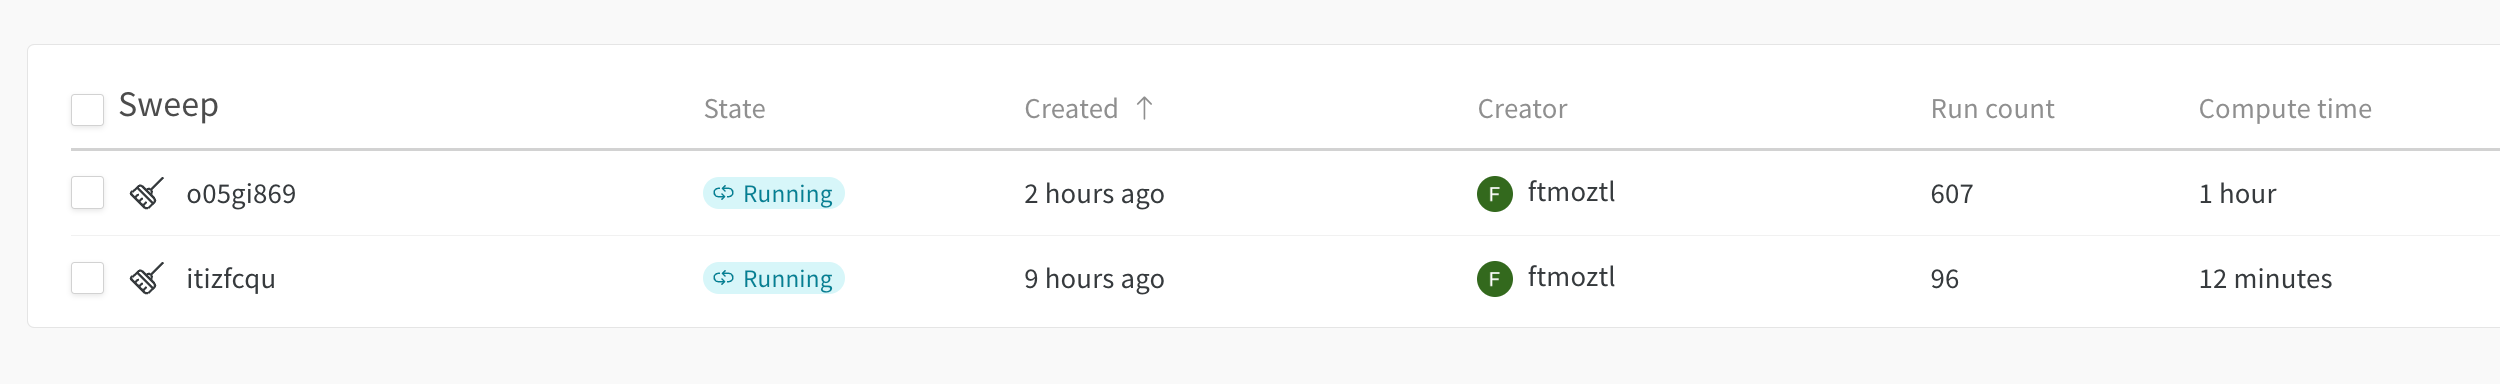

You can see the main screen which includes all runs inside the parameter tuning process. Each row represents a model with different parameters. You can track the models from this screen easily.

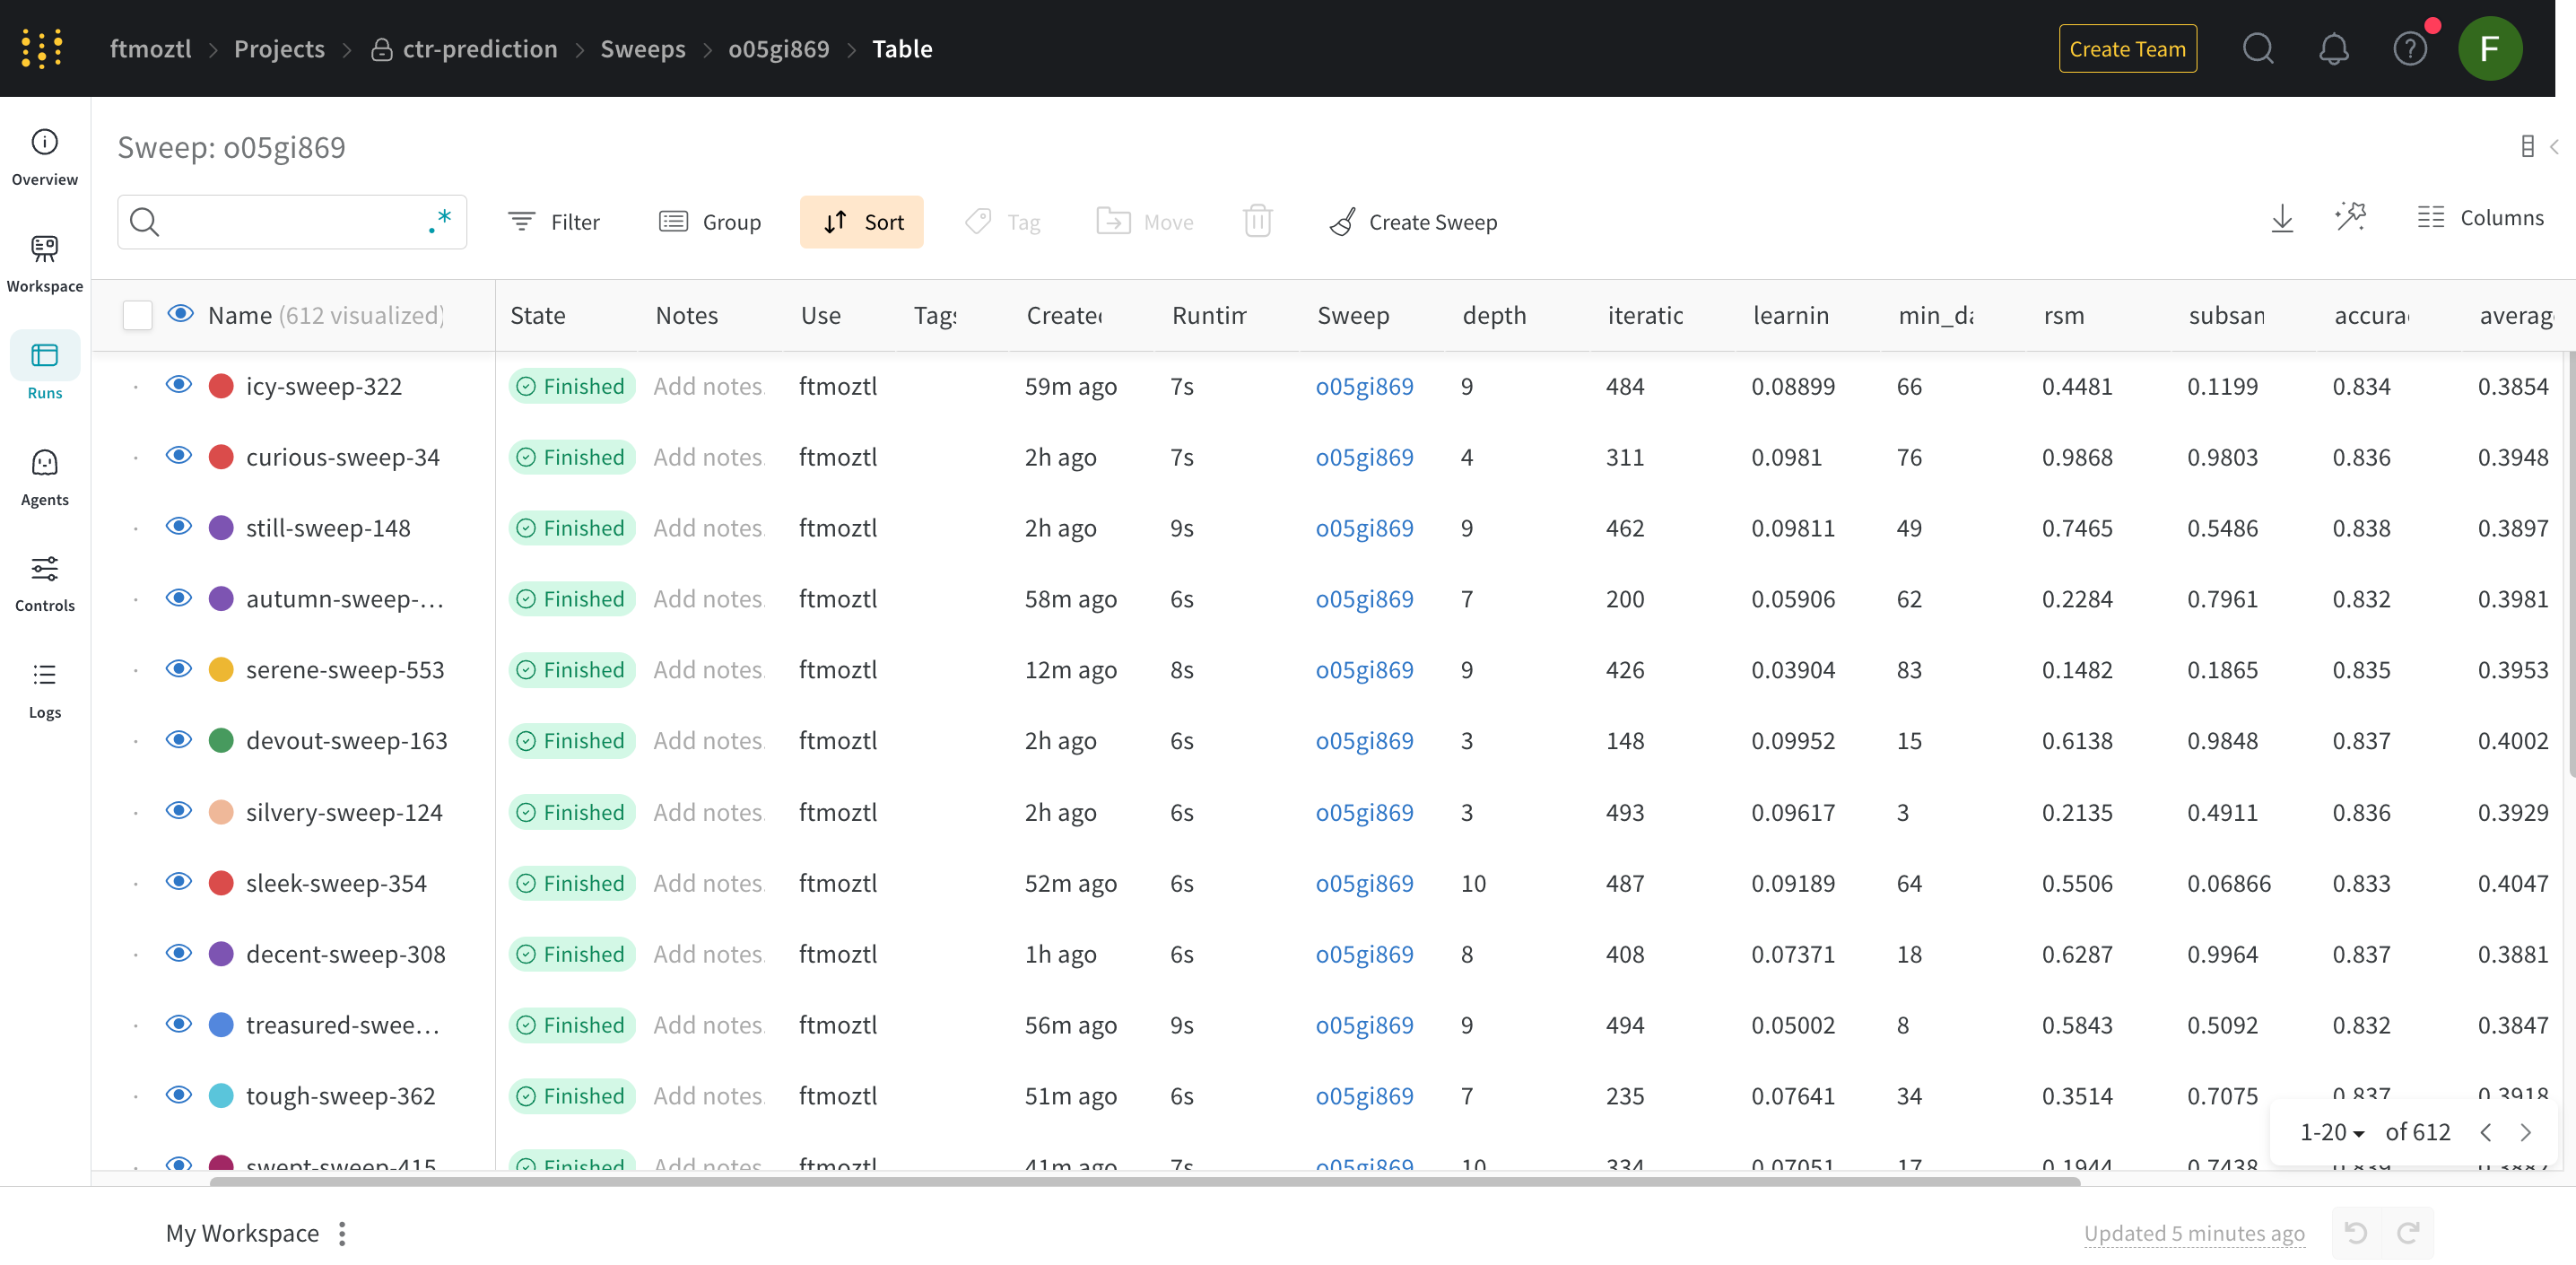

So,  you can check logged performance scores for each model on this screen, and you can filter and sort according to metrics. For example, the following screen is sorted by recall value in descending order. 

![sweep list.png](<attachment:sweep list.png>)
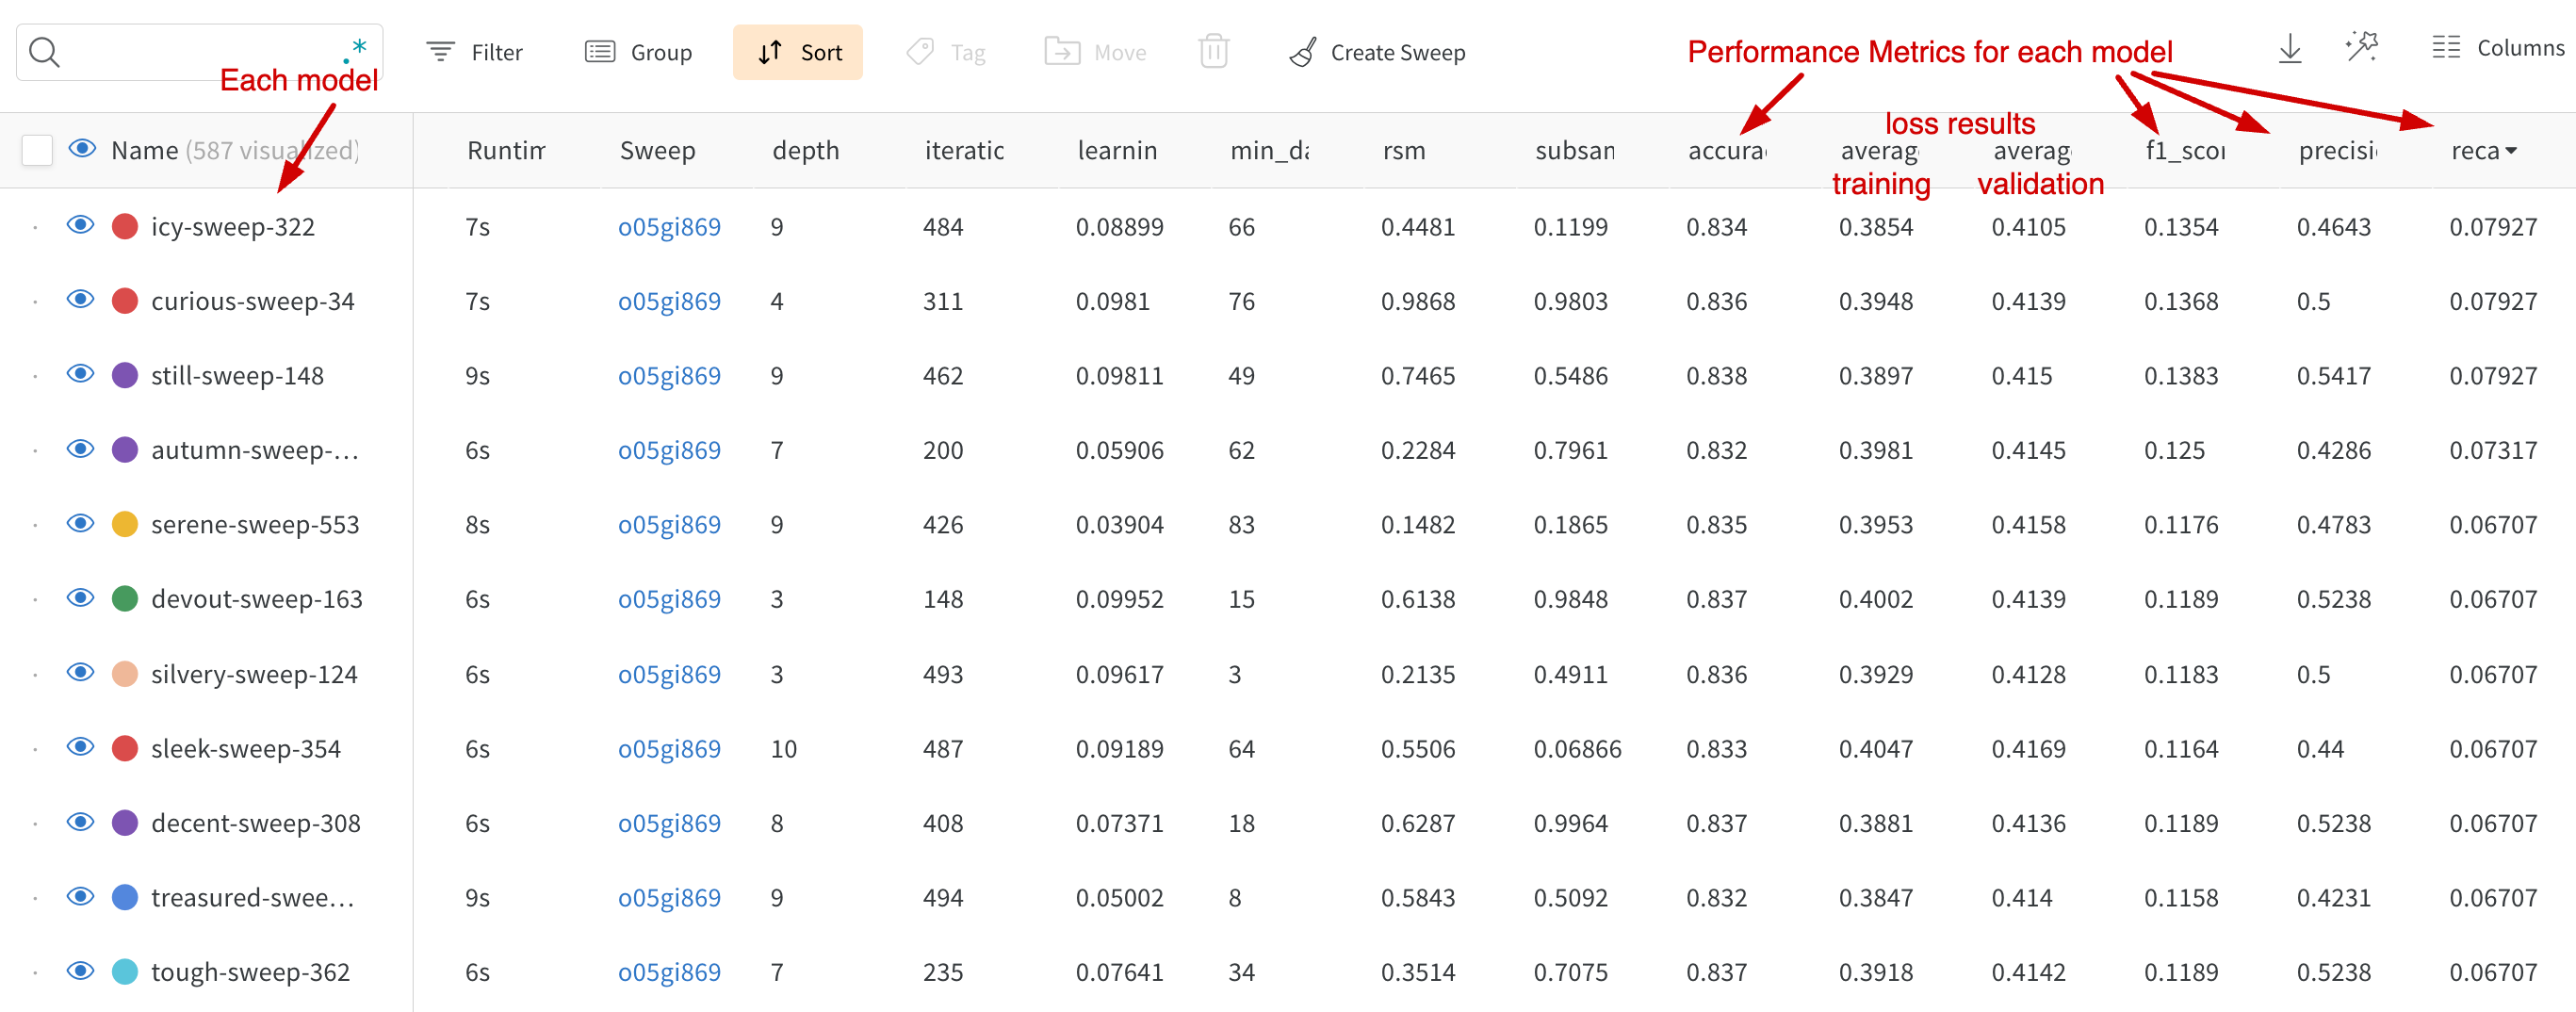

If you consider the recall, the icy-sweep-322 has the best recall score relative to the other runs. You can save this model in the tuning, or you can get the value of the parameter from this table and run the algorithm again with these parameters.

If you want to see the relationship between the parameters, W&B helps to visualize and create a report easily. For example, you can see the scatter plot validation loss, depth, and iteration. As mentioned above, minimum loss values were obtained from the high depth and iterations, which means that there can be the possibility of overfitting.

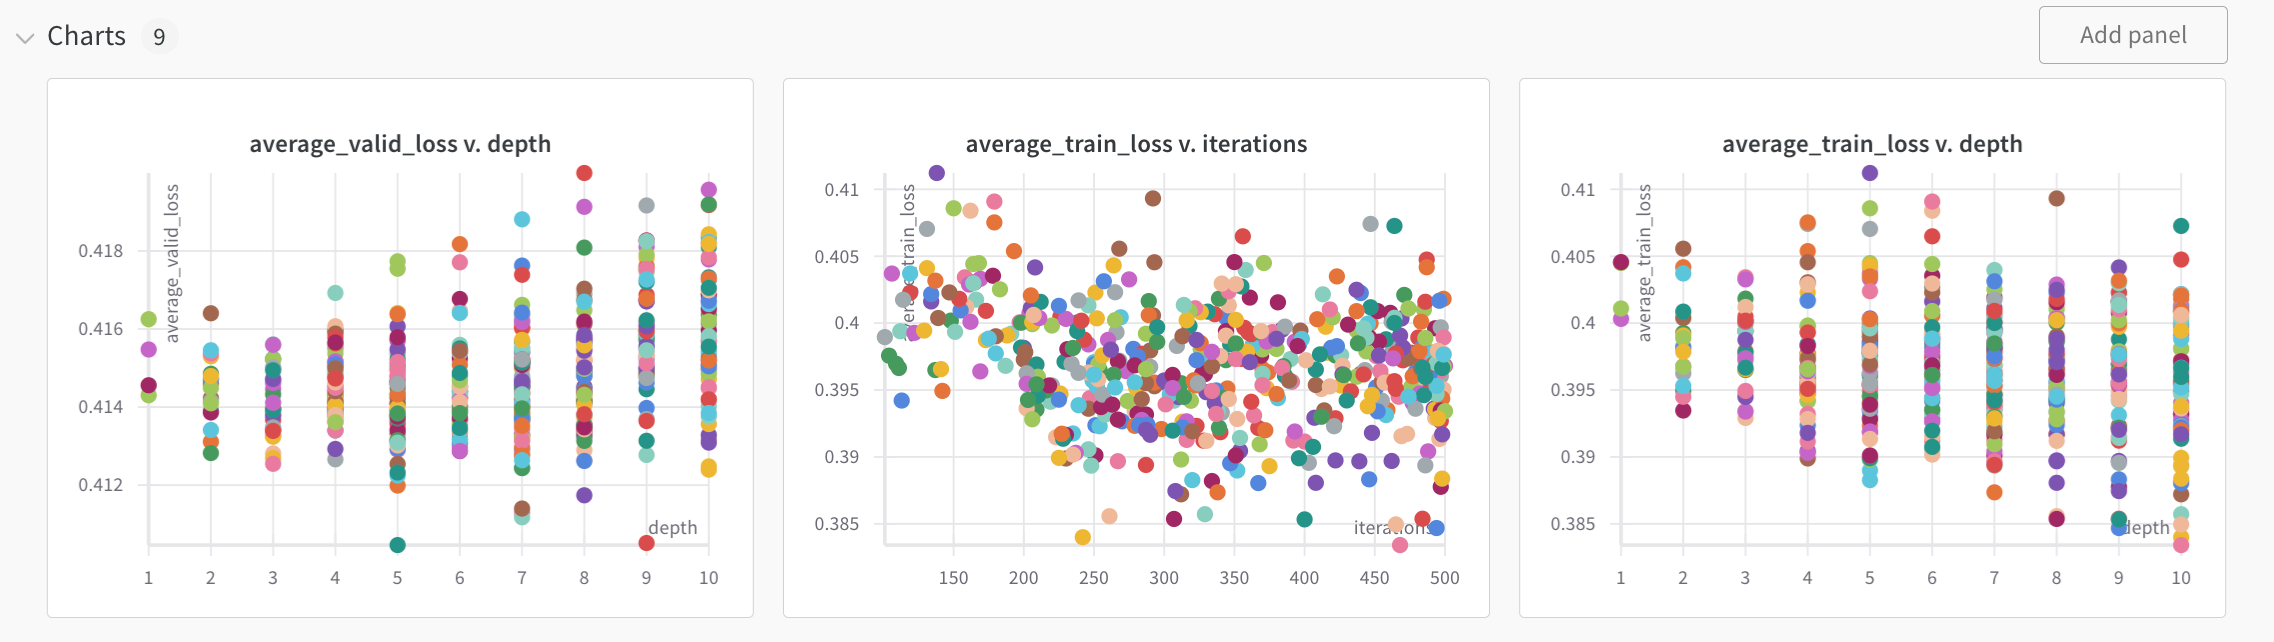

If you want to see the importance of the hyperparameters on the model performance, the W&B provides this info. You can find the table below, so the most important parameter which has the most effect on the model performance is 'subsample'. If the correlation is red, the parameter affects the performance in a reverse way. The second important factor is the learning rate (no surprise), so it should be tuned carefully.

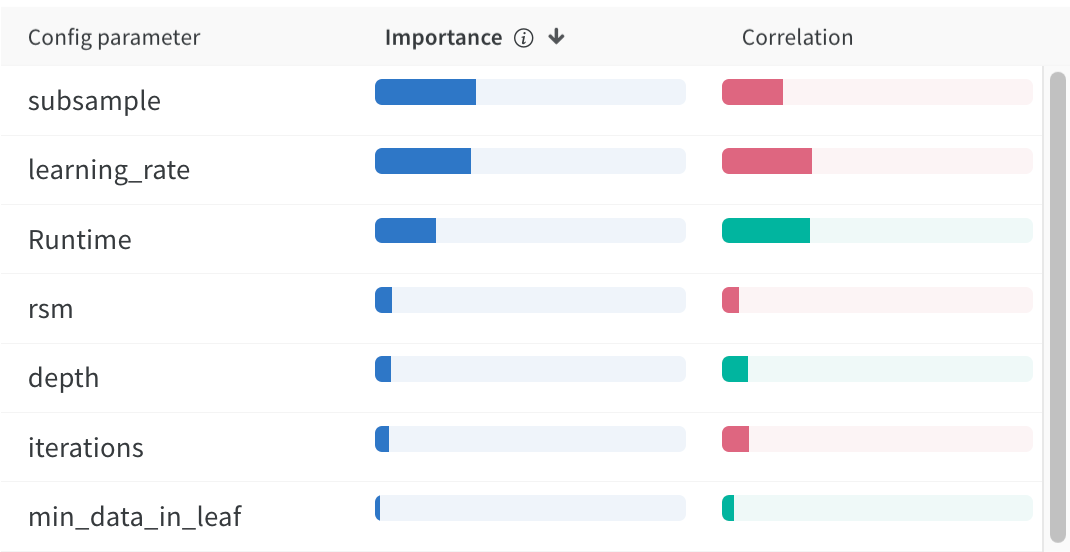

By creating a parallel coordinate graph, you can try to find the effect of the parameters on the loss or other results. You can find the example below, but it's hard to say such as high depth value decreases loss. But it's a good graph to see the obvious effects of parameters.

![parameter effect.png](<attachment:parameter effect.png>)
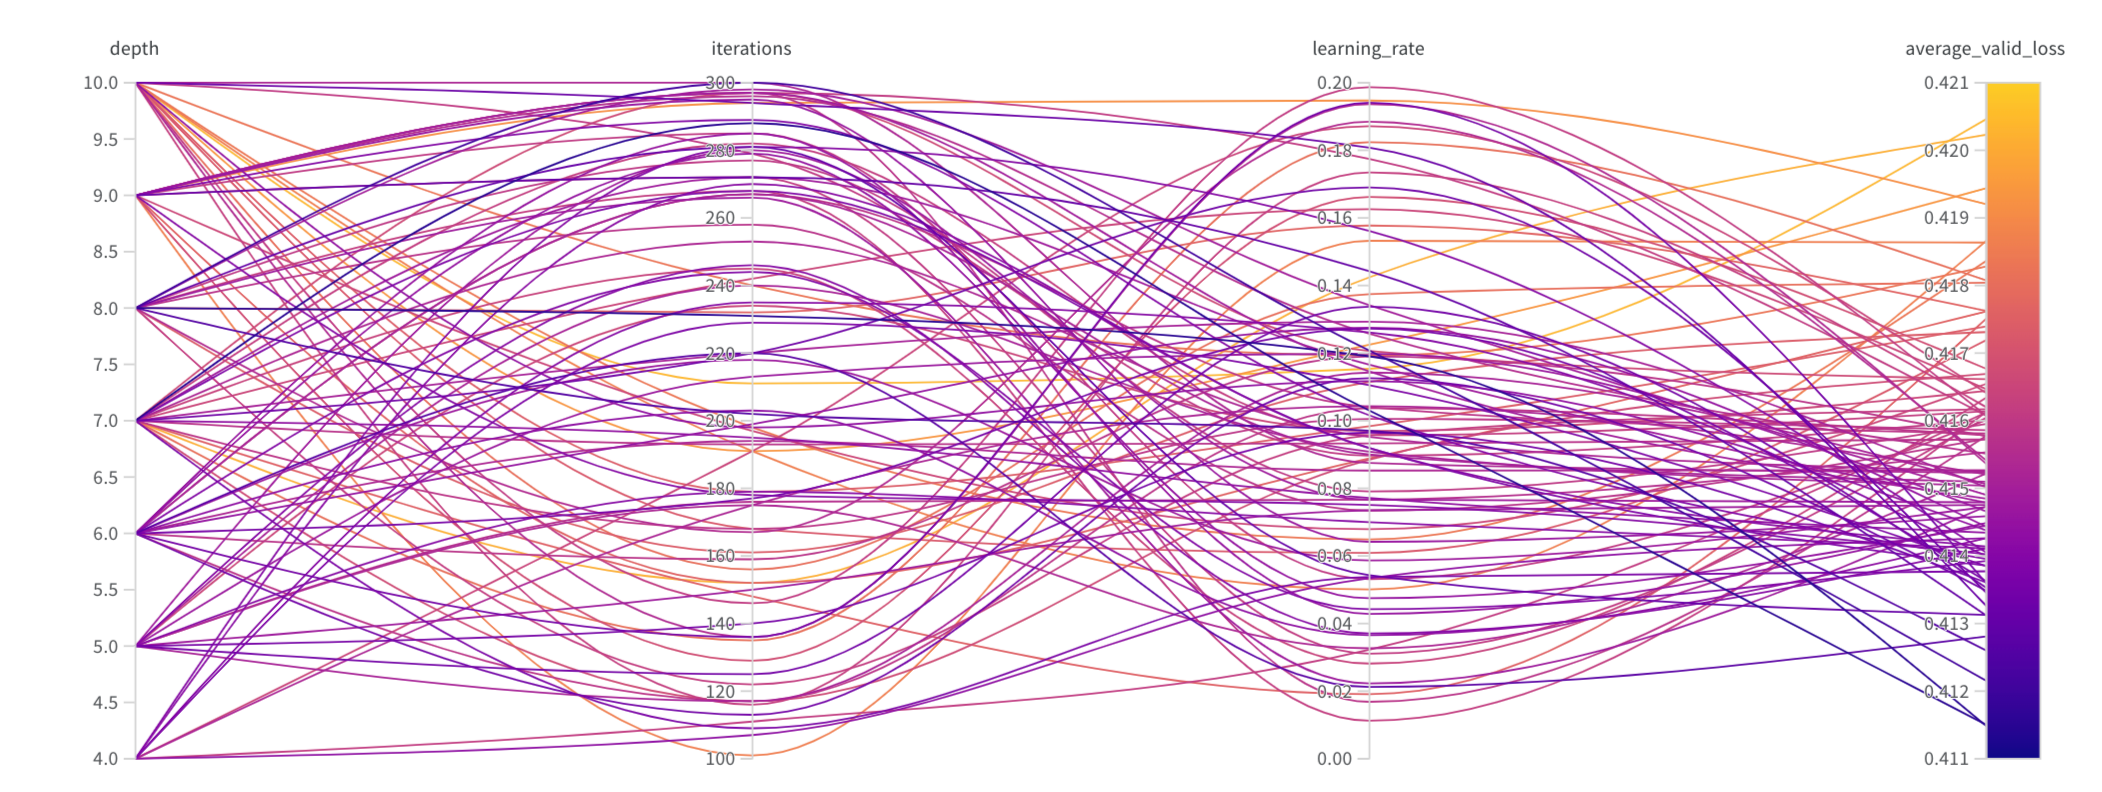

# OVERALL RESULTS

As a result of the training process, we couldn't get good recall results. The reason probably is using the imbalanced dataset. Also if we had used the whole dataset, we'd get more good results. But it's not the main purpose of this study, and computational power is the main restriction for this study. 

But if you want to improve the performance;
* You can use more data and a more balanced dataset. Or you can try techniques like oversampling the minority class, undersampling the majority class, or using synthetic data generation methods to balance the dataset. 
* You can continue fine-tuning the model's hyperparameters. Focus on optimizing for the best trade-off between precision and recall.
* As another choice, you can consider trying different algorithms or ensemble methods/algorithm.

**THANK YOU!**